In [453]:
import numpy as np
np.float=float
import nibabel
import glob
import os
import sys
import subprocess
import cifti
from brainspace.null_models import MoranRandomization
from brainspace.mesh import mesh_elements as me
#import scipy.io as sio

from scipy import sparse
import pickle
import time
import matplotlib.pyplot as plt
import pandas as pd
import seaborn
import scipy.stats

from scipy.stats import levene
from statsmodels.tools import add_constant
from statsmodels.formula.api import ols ## use formula api to make the tests easier
import matplotlib
from nibabel import cifti2 as ci
import copy
import nipy
#from nipy.modalities.fmri import hrf
#from nipy.modalities.fmri.utils import T, lambdify_t

import seaborn as sns

from scipy.signal import hilbert, chirp

import re
from datetime import date

import nilearn
import nilearn.plotting
import random
from sklearn.metrics import r2_score

In [454]:
from nipy.modalities.fmri import hrf
from nipy.modalities.fmri.utils import T, lambdify_t

# parameters for the database

In [3]:
# subject specific networks

#define network [as np.where(network==x) , x from 1 to 17]

#networks=[nibabel.load(path+'/Evan/CIMT/Subnetworks/'+s+'_precast_infomap_wacky2_subcortreg_ignoreverts/'+s+'_rawassn_minsize10_regularized_allcolumns_recolored.dscalar.nii').dataobj[7][:29696+29716] for s in sub]

networks=[
    nibabel.load(path+'/Evan/MSC/Analysis_V1/infomap/MSC02_infomap_p003_p005_p05/MSC02_rawassn_minsize400_regularized_recolored_cleaned.dscalar.nii').dataobj[0][:29696+29716],
    nibabel.load(path+'/Evan/MSC/Analysis_V1/infomap/MSC06_infomap_p003_p005_p05/MSC06_rawassn_minsize400_regularized_recolored_cleaned.dscalar.nii').dataobj[0][:29696+29716],
    nibabel.load(path+'/Dillan/cast/MSC_analyses/infomap/SIC03_sparse/SIC03_rawassn_minsize100_regularized_recolored_cleaned.dscalar.nii').dataobj[0][:29696+29716]
]


#networks=[np.array([int(i) for i in open(path+'/RosCha/Tools/nifti/MSC02/networks/MSC02_rawassn_minsize400_regularized_recolored_cleaned_values.txt','r').read().split('\n') if i!='']),
#         copy.deepcopy(nibabel.load(path+'/Evan/CIMT/Subnetworks/SIC02_precast_infomap_wacky2_subcortreg_ignoreverts/SIC02_rawassn_minsize10_regularized_recolored_minaud.dtseries.nii').dataobj[0]),#np.array([int(i) for i in open(path+'/RosCha/Tools/nifti/SIC02/SIC02_rawassn_minsize10_regularized_recolored_minaud.dtseriestxt','r').read().split('\n') if i!='']),
#         np.array([int(i) for i in open(path+'/RosCha/Tools/nifti/SIC03/SIC03_rawassn_minsize10_regularized_recolored_222.txt','r').read().split('\n') if i!=''])] 

#maskSNR=cifti.read(path+'/RosCha/Tools/nifti/MSCmean_badverts_cort.dtseries.nii')[0][0]
#for s in range(3):
#    networks[s][np.where(maskSNR!=0)]=13


networkname=['Default','Visual','Fronto-Parietal','PrimaryVisual','DorsalAttention','PreMotor','VentralAttentionLanguage','Salience','Cingulo-Opercular','MotorHand','MotorMouth','Auditory','AntMedialTemporal/SNR noise','PostMedialTemporal','Cingulo-Parietal','Parieto-Occipital','MotorFoot']
networkcolor=[[1,0,0],[0,0,0.6],[0.9,0.9,0],[1,0.7,0.4],[0,0.8,0],[1,0.6,1],[0,0.6,0.6],[0,0,0],[0.3,0,0.6],[0.2,1,1],[1,0.5,0],[0.6,0.2,1],[0,0.2,0.4],[0.2,1,0.2],[0,0,1],[0.85,0.85,0.85],[0,0.5,0]]

In [4]:
#color palette
mypal_net=dict()
for e,m in enumerate(networkname):
    mypal_net.update({m:np.array(networkcolor[e])})
provpal=dict()
provpal.update(mypal_net)


In [5]:
#precast task based
HandDillan=[
    np.array([int(i) for i in open(path+'/RosCha/Tools/nifti/MSC02/motor_spots/DillanMotorHand.txt','r').read().split('\n') if i!='']),
    np.array([int(i) for i in open(path+'/RosCha/Tools/nifti/SIC02/DillanMotorHand.txt','r').read().split('\n') if i!='']),
    np.array([int(i) for i in open(path+'/RosCha/Tools/nifti/SIC03/DillanMotorHand.txt','r').read().split('\n') if i!=''])
]
HandDillan[0][np.where(HandDillan[0]>6)]=0
HandDillan[1][np.where(HandDillan[1]>6)]=0
HandDillan[2][np.where(HandDillan[2]>6)]=0
HandDillanname=['L_M1','R_M1','L_sma','R_sma','Ltemp','Rtemp']

In [6]:
sub = ['SIC01','SIC02','SIC03']
# load task results from each subjects
#not needed

#taskname = ['motor','motordigit','armlocalizer','imaginedmotor', 'handlocalizer','imaginedmotor_vs_motor']

#secondlevel = ['precast_vs_postcast','precast_vs_postcast','all','all','all','all-imaginedmotor_vs_precast-motor']

In [7]:
# time plot pre post
#load the list of vc pre post : 
pplist=[[] for s in range(len(sub))]
for e,s in enumerate(sub):
    pplist[e]=[[i for i in open(path+'/RosCha/Data/Precision/motor/'+s+'/conditionlist/'+p+'cast.txt','r').read().split('\n') if i!=''] for p in ['pre','post']]+[[i for i in open(path+'/RosCha/Data/Precision/rest/'+s+'/conditionlist/during.txt','r').read().split('\n') if i!='']]
    for j in range(3):
        pplistorder=np.argsort([int(i.replace('vc','').replace('_motor','').replace('_rest_','')) for i in pplist[e][j]])
        if e==0 and j==2:
            pplistorder=np.concatenate([pplistorder[4:6],pplistorder[:4],pplistorder[6:]],0)
        pplist[e][j]=[pplist[e][j][i] for i in pplistorder]
    

In [8]:
datelist=[[] for s in range(len(sub))]
for e,s in enumerate(sub):
    datelist[e]=[i.split('_') for i in open(path+'/RosCha/Data/Precision/eventfiles/castsessions/'+s+'_session_date.txt','r').read().split('\n') if i!='']

In [9]:
import seaborn
def fdr(p_vals):

    from scipy.stats import rankdata
    ranked_p_values = rankdata(p_vals)
    fdr = p_vals * len(p_vals) / ranked_p_values
    fdr[fdr > 1] = 1

    return fdr

In [10]:
# do regression
def regression(data, design, mask='', demean=True, desnorm=False, resids=False):
    
    import numpy as np
        
    # Y = Xb + e
    # process Y
    
    Y = data[mask==1,:]
    
    # process X
    if design.shape[0] == Y.shape[1]:
        X = design
        
    else:
        X = design[mask==1,:]
        
    
    if demean == True:
        #demean Y
        if Y.shape[0] == X.shape[0]:
            Y = Y - np.average(Y,axis=0)
        else:
            # demean the data, subtract mean over time from each voxel
            Y = Y - np.tile(np.average(Y, axis=1), (Y.shape[1],1)).T
    
        # demean the design
        X = X - np.average(X,axis=0)#np.repeat(np.mean(X,0),len(X[0]))#.mean(axis=0)
    
    if desnorm == True:
        # variance normalize the design
        X = X/X.std(axis=0, ddof=1)

    # add constant to X
    constant = np.ones(X.shape[0])
    X = np.column_stack((constant,X))
    
    if Y.shape[1] == X.shape[0]:
        # put time in rows for regression against time course
        Y = Y.T
    
    # obtain betas
    B = np.linalg.pinv(X).dot(Y)
    # obtain residuals
    #print Y.shape, X.shape, B.shape
    eta = Y - X.dot(B)
    #print eta.shape
    
    # put betas back into image if needed
    if max(B.shape) == max(Y.shape):
        bi = np.zeros((B.shape[0],max(data.shape)))
        bi[:,mask==1] = B
        B = bi
    
    # put residuals back into image
    if resids == True:
        ei = np.zeros_like(data)
        ei[mask==1,:] = eta.T
        eta = ei
        
    # return betas and design
    # discard first beta, this is the constant
    if resids == True:
        return B[1:,:], eta
    else:
        return B[1:,:]

# Pulse shape

In [ ]:
# hurst from non fractal matlab toolbox
locBP=[path+'/RosCha/Data/Precision/rest/SIC01/vcXXX/boldrest_1/vcXXX_b*_faln_dbnd_xr3d_uwrp_atl_tr.dtseries.nii',
       path+'/RosCha/Data/Precision/rest/SIC02/vcXXX/boldrest_1/vcXXX_b*_faln_dbnd_xr3d_uwrp_atl_tr.dtseries.nii',
      path+'/RosCha/Data/Precision/rest/SIC03/vcXXX/boldrest_1/vcXXX_b*_faln_dbnd_xr3d_uwrp_atl_tr.dtseries.nii']

from sklearn.linear_model import LinearRegression
listname=['pre','post','during']
d0 = date(2014, 1, 1)
pulsecleandict=[]

TR=[2.2,1.1,1.1]
elapse=15.4
N2=0
for e,s in enumerate(sub):
    raw=nibabel.load([i for i in glob.glob(path+'/RosCha/Results/Tasks/rest/'+s+'/second_level_cifti_during_pulse-6-HRF_LR_fix_nolearning/cifti_cope1/zstat1_smooth6.0segment10_95perc_*.dtseries.nii') if i.find('mask')!=-1][0])
    axes = [raw.header.get_axis(i) for i in range(raw.ndim)]
    # You'll want the brain model axis
    time_axis, brain_model_axis = axes
    #left=[]
    #right=[]
    for e2,p2 in enumerate(pplist[e]):
        e2alt=np.array([0,2,1])[e2]

        print(s+' '+listname[e2])
        p5=np.unique([p3.split('_')[0] for p3 in p2])
        

        rh=np.where(HandDillan[e]==1)[0]
        lh=np.where(HandDillan[e]==2)[0]
        for e4,p4 in enumerate(p5):
            print(p4)
            file=glob.glob(locBP[e].replace('vcXXX',p4))
            
            signal2=nibabel.load(file[0]).get_fdata()
            

            mvt=np.array([i.split('\t') for i in open(path+'/RosCha/Data/Precision/rest/'+s+'/'+p4+'/boldrest_1/mc.par','r').read().split('\n') if i!='']).astype(np.float)

            [reg,signal3]=regression(signal2.T, mvt, np.ones(len(signal2.T)), demean=True, desnorm=False, resids=True)
            
            #std=np.std(signal3,1)
            #std[np.where(std)==0]=1
            #signal3=((signal3.T-np.mean(signal3,1))/std).T
            #load number of pulse
            vc=p4
            pulsecountLallreal=[np.float(i.split('\t')[0]) for i in open(path+'/RosCha/Data/Precision/eventfiles/NEW/'+s+'/'+vc+'/EV_'+vc+'_1_rest/EV_pulse-6-HRFpeak_simple.txt','r').read().split('\n') if i !='']
            pulsecountRallreal=[np.float(i.split('\t')[0]) for i in open(path+'/RosCha/Data/Precision/eventfiles/NEW/'+s+'/'+vc+'/EV_'+vc+'_1_rest/EV_pulse-6-HRFpeak_simple_contra.txt','r').read().split('\n') if i !='']
            
            
            pulsecountLall=[int(np.float(i.split('\t')[0])/TR[e]) for i in open(path+'/RosCha/Data/Precision/eventfiles/NEW/'+s+'/'+vc+'/EV_'+vc+'_1_rest/EV_pulse-6-HRFpeak_simple.txt','r').read().split('\n') if i !='']
            pulsecountRall=[int(np.float(i.split('\t')[0])/TR[e]) for i in open(path+'/RosCha/Data/Precision/eventfiles/NEW/'+s+'/'+vc+'/EV_'+vc+'_1_rest/EV_pulse-6-HRFpeak_simple_contra.txt','r').read().split('\n') if i !='']
            pulsecountL=[e5 for e5,i in enumerate(pulsecountLall) if sum(np.abs(np.array(pulsecountRall)-i)<int(elapse/TR[e]))==0 and sum(np.abs(np.array(pulsecountLall)-i)<int(elapse/TR[e]))==1 and i-elapse/TR[e]>=0 and int(np.ceil(10/TR[e])+int(i+elapse/TR[e]))+1<=len(signal3.T)]
            pulsecountR=[e5 for e5,i in enumerate(pulsecountRall) if sum(np.abs(np.array(pulsecountRall)-i)<int(elapse/TR[e]))==1 and sum(np.abs(np.array(pulsecountLall)-i)<int(elapse/TR[e]))==0 and i-elapse/TR[e]>=0 and int(np.ceil(10/TR[e])+int(i+elapse/TR[e]))+1<=len(signal3.T)]
            
            #read raw data
            data=signal3
            if len(pulsecountL)!=0 or len(pulsecountL)!=0:
                pointpulse=np.concatenate([np.arange(int(l-elapse/TR[e]),int(np.ceil(10/TR[e])+int(l+elapse/TR[e]))+1) for l in np.concatenate([np.array(pulsecountLall)[pulsecountL],np.array(pulsecountRall)[pulsecountR]],0)],0)
                mask=np.full(len(data.T),True,dtype=bool)
                mask[pointpulse]=False
                data=((data.T-np.mean(data.T[mask],0))/np.std(data.T[mask],0)).T
                data[np.where(np.isnan(data))]=0
            else:
                data=((data.T-np.mean(data.T,0))/np.std(data.T,0)).T
                data[np.where(np.isnan(data))]=0
            
            for l2 in pulsecountL:
                l=pulsecountLall[l2]
                lt=[pulsecountLallreal[l2]-l*TR[e]-elapse+l3*TR[e] for l3 in range(int(np.ceil(10/TR[e])+int(l+elapse/TR[e]))+1-int(l-elapse/TR[e]))]
                shift=(pulsecountLallreal[l2]-l*TR[e])/TR[e]
                
                print('left',l)
                tsL=data.T[int(l-elapse/TR[e]):int(np.ceil(10/TR[e])+int(l+elapse/TR[e]))+1]
                tsL=[tsL[i]*shift+tsL[i+1]*(1-shift) for i in range(len(tsL)-1)]
                lt=np.array(lt)-(pulsecountLallreal[l2]-l*TR[e])
                #left+=[tsL]
                #left+=[np.zeros((1,len(tsL[0])))]
                for t,ts in enumerate(tsL):
                    df=pd.DataFrame({
                        'values':ts,
                        'voxels':range(len(ts)),
                        'hem':['L-SM1' for i in range(len(ts))],
                        'sub':[s for i in range(len(ts))],
                        'list':[listname[e2] for i in range(len(ts))],
                        'pos':[e4 for i in range(len(ts))],
                        'time':[lt[t] for i in range(len(ts))],
                        'id':[listname[e2]+'_'+str(e4)+'_'+str(pulsecountLallreal[l2]) for i in range(len(ts))]
                    },
                    index=range(N2,N2+len(ts))
                                )
                    pulsecleandict+=[df]
                    N2=N2+len(ts)
                    if t!=len(tsL)-1:
                        df=pd.DataFrame({
                        'values':(ts+tsL[t+1])/2.,
                        'voxels':range(len(ts)),
                        'hem':['L-SM1' for i in range(len(ts))],
                        'sub':[s for i in range(len(ts))],
                        'list':[listname[e2] for i in range(len(ts))],
                        'pos':[e4 for i in range(len(ts))],
                        'time':[(lt[t]+lt[t+1])/2. for i in range(len(ts))],
                        'id':[listname[e2]+'_'+str(e4)+'_'+str(pulsecountLallreal[l2]) for i in range(len(ts))]
                        },
                        index=range(N2,N2+len(ts))
                                    )
                        pulsecleandict+=[df]
                        N2=N2+len(ts)
        
                
            for l2 in pulsecountR:
                print('right',l)
                l=pulsecountRall[l2]
                lt=[pulsecountRallreal[l2]-l*TR[e]-elapse+l3*TR[e] for l3 in range(int(np.ceil(10/TR[e])+int(l+elapse/TR[e]))+1-int(l-elapse/TR[e]))]
                shift=(pulsecountRallreal[l2]-l*TR[e])/TR[e]
                
                
                tsL=data.T[int(l-elapse/TR[e]):int(np.ceil(10/TR[e])+int(l+elapse/TR[e]))+1]
                tsL=[tsL[i]*shift+tsL[i+1]*(1-shift) for i in range(len(tsL)-1)]
                lt=np.array(lt)-(pulsecountRallreal[l2]-l*TR[e])
                
                #right+=[tsL]
                #right+=[np.zeros((1,len(tsL[0])))]
                for t,ts in enumerate(tsL):
                    df=pd.DataFrame({
                        'values':ts,
                        'voxels':range(len(ts)),
                        'hem':['R-SM1' for i in range(len(ts))],
                        'sub':[s for i in range(len(ts))],
                        'list':[listname[e2] for i in range(len(ts))],
                        'pos':[e4 for i in range(len(ts))],
                        'time':[lt[t] for i in range(len(ts))],
                        'id':[listname[e2]+'_'+str(e4)+'_'+str(pulsecountRallreal[l2]) for i in range(len(ts))]
                    },
                    index=range(N2,N2+len(ts))
                                )
                    pulsecleandict+=[df]
                    N2=N2+len(ts)
                    if t!=len(tsL)-1:
                        df=pd.DataFrame({
                        'values':(ts+tsL[t+1])/2.,
                        'voxels':range(len(ts)),
                        'hem':['R-SM1' for i in range(len(ts))],
                        'sub':[s for i in range(len(ts))],
                        'list':[listname[e2] for i in range(len(ts))],
                        'pos':[e4 for i in range(len(ts))],
                        'time':[(lt[t]+lt[t+1])/2. for i in range(len(ts))],
                        'id':[listname[e2]+'_'+str(e4)+'_'+str(pulsecountRallreal[l2]) for i in range(len(ts))]
                        },
                        index=range(N2,N2+len(ts))
                                    )
                        pulsecleandict+=[df]
                        N2=N2+len(ts)
        #right+=[np.zeros((2,len(tsL[0])))]
        
        #left+=[np.zeros((2,len(tsL[0])))]
        
    #left=np.concatenate(left,0)
    #right=np.concatenate(right,0)
    #time_axis2=nibabel.cifti2.cifti2_axes.SeriesAxis(1,1,len(left))

    #img=ci.Cifti2Image(np.array(left), header=(time_axis2, brain_model_axis),
    #                        nifti_header=raw.nifti_header)
    #ci.save(img,path+'/RosCha/Results/Tasks/rest/'+s+'/pulsetimeseries_start-'+str(elapse)+'_ALLcentered_L-SM1.dtseries.nii')
    
    #time_axis2=nibabel.cifti2.cifti2_axes.SeriesAxis(1,1,len(right))
    #img=ci.Cifti2Image(np.array(right), header=(time_axis2, brain_model_axis),
    #                        nifti_header=raw.nifti_header)
    #ci.save(img,path+'/RosCha/Results/Tasks/rest/'+s+'/pulsetimeseries_start-'+str(elapse)+'_ALLcentered_R-SM1.dtseries.nii')

pulsecleandict=pd.concat(pulsecleandict)

SIC01 pre
vc39790


<ipython-input-12-c386d2b3fcc8>:64: RuntimeWarning: invalid value encountered in true_divide
  data=((data.T-np.mean(data.T,0))/np.std(data.T,0)).T


vc39794
vc39798


In [288]:
#precomput mean and std across all session
#HERE0510
locBP=[path+'/Dillan/preproc_2018-07-03/SIC01/cifti_timeseries_normalwall/vcXXX_b1_faln_dbnd_xr3d_uwrp_atl_bpss_resid_LR_surf_subcort_333_32k_fsLR_surfsmooth2.55_volsmooth2.dtseries.nii',
       path+'/Dillan/preproc_2018-07-03/SIC02/cifti_timeseries_normalwall/vcXXX_b1_faln_dbnd_xr3d_uwrp_atl_bpss_resid_LR_surf_subcort_333_32k_fsLR_surfsmooth2.55_volsmooth2.dtseries.nii',
       path+'/Dillan/preproc_2018-07-03/SIC03/cifti_timeseries_normalwall/vcXXX_b1_faln_dbnd_xr3d_uwrp_atl_bpss_resid_LR_surf_subcort_333_32k_fsLR_surfsmooth2.55_volsmooth2.dtseries.nii']
locBPalt=[path+'/Laumann/MSC/MSC02/Cast/cifti_timeseries_normalwall/vcXXX_b1_faln_dbnd_xr3d_uwrp_atl_bpss_resid_LR_surf_subcort_333_32k_fsLR_surfsmooth2.55_volsmooth2.dtseries.nii']

TR=[2.2,1.1,1.1]
meanrh=[[] for s in range(len(sub))]
meanrhthal=[[] for s in range(len(sub))]
stdrh=[[] for s in range(len(sub))]
stdrhthal=[[] for s in range(len(sub))]
meanlh=[[] for s in range(len(sub))]
meanlhthal=[[] for s in range(len(sub))]
stdlhthalfc=[[] for s in range(len(sub))]
meanlhthalfc=[[] for s in range(len(sub))]

stdlhthalfull=[[] for s in range(len(sub))]
meanlhthalfull=[[] for s in range(len(sub))]

stdlhputfc=[[] for s in range(len(sub))]
meanlhputfc=[[] for s in range(len(sub))]
stdrhcereb=[[] for s in range(len(sub))]
meanrhcereb=[[] for s in range(len(sub))]
stdlh=[[] for s in range(len(sub))]
stdlhthal=[[] for s in range(len(sub))]
stddiff=[[] for s in range(len(sub))]
for e,s in enumerate(sub):
    rh=np.where(HandDillan[e]==1)[0]
    #rhthal=np.where(HandDillan[e]==3)[0]
    lh=np.where(HandDillan[e]==2)[0]
    #lhthal=np.where(HandDillan[e]==4)[0]
    basefile=path+'/RosCha/Results/Tasks/rest/'+s+'/pulsemodel'
    
    
    pathorig=basefile+'_Lsm1_amplitudeseries_during_tstats_smooth6.0_masked80N_timecut1.1.dtseries.nii'
    if e!=0:
        net=pathorig
        tag3='dtseries'

        subprocess.call(['wb_command','-cifti-separate-all',net,'-volume',net.replace('.'+tag3+'.nii','_vol.nii.gz'),'-left',net.replace('.'+tag3+'.nii','_L.func.gii'),'-right',net.replace('.'+tag3+'.nii','_R.func.gii')])


        netV=net.replace('.'+tag3+'.nii','_vol.nii.gz')

        #save-flirt-load
        subcorticaldir=path+'/Dillan/preproc_2018-07-03/'+sub[e]+'/subcortical_mask_222'
        #if s==0:
        subcorticalmask=path+'/Dillan/preproc_2018-07-03/'+sub[e]+'/subcortical_mask/subcortical_mask_LR_333.nii'


        #reshape
        subprocess.call(['flirt','-in',netV,'-ref',subcorticalmask,'-applyxfm','-usesqform','-out',netV.replace('.nii.gz','_333.nii.gz')])
        rightfile=net.replace('.'+tag3+'.nii','_R.func.gii')
        leftfile=net.replace('.'+tag3+'.nii','_L.func.gii')
        Subcortical=netV.replace('.nii.gz','_333.nii.gz')
        subprocess.call(['wb_command','-cifti-create-dense-timeseries',net.replace('.'+tag3+'.nii','_333.dtseries.nii'),'-volume',Subcortical,subcorticalmask,'-left-metric',leftfile,'-roi-left',subcorticaldir+'/L.atlasroi.32k_fs_LR.shape.gii','-right-metric',rightfile,'-roi-right',subcorticaldir+'/R.atlasroi.32k_fs_LR.shape.gii'])
        maskeddata=nibabel.load(net.replace('.'+tag3+'.nii','_333.dtseries.nii')).get_fdata()[0]
        subprocess.call(['rm',rightfile,leftfile,Subcortical,netV])
        
        pathorig=net.replace('.'+tag3+'.nii','_333.dtseries.nii')
    
    raw=nibabel.load(pathorig)
    axes = [raw.header.get_axis(i) for i in range(raw.ndim)]
    # You'll want the brain model axis
    time_axis, brain_model_axis = axes
    data=raw.get_fdata()[0]
    lhthal=np.where((brain_model_axis.name=='CIFTI_STRUCTURE_THALAMUS_LEFT')&(data!=0))[0]
    lhthalfull=np.where((brain_model_axis.name=='CIFTI_STRUCTURE_THALAMUS_LEFT'))[0]
    
    rhcereb=np.where((brain_model_axis.name=='CIFTI_STRUCTURE_CEREBELLUM_RIGHT')&(data!=0))[0]
    
    
    print(data.shape)
    pathtest=path+'/RosCha/RestProcessing/cast/smooth255/'+s+'/FC/'
    
    peak2=pathtest+'/cast-pre_Lsm1avg_dconn_cohensd_masked2cluster.dtseries.nii'
    
        

    raw=nibabel.load(peak2)
    data2=raw.get_fdata()[0]
    lhthalfc=np.where((brain_model_axis.name=='CIFTI_STRUCTURE_THALAMUS_LEFT')&(data2!=0))[0]
    
    #lhthalfc=np.where((brain_model_axis.name=='CIFTI_STRUCTURE_THALAMUS_LEFT'))[0]
    lhputfc=np.where((brain_model_axis.name=='CIFTI_STRUCTURE_PUTAMEN_LEFT')&(data2!=0))[0]#whole
    print(data.shape)
    
    
    #data=np.sign(data)
    
    
    if True:#for e2,p2 in enumerate(pplist[e]):
        e2=2
        p2=pplist[e][e2]
        p5=np.unique([p3.split('_')[0] for p3 in p2])
        for e4,p4 in enumerate(p5):
            vc=p4
            if os.path.exists(locBP[e].replace('vcXXX',p4)):
                test=cifti.read(locBP[e].replace('vcXXX',p4))[0]
            else:
                test=cifti.read(locBPalt[e].replace('vcXXX',p4))[0]
                                
            '''
            test=cifti.read(glob.glob(path+'/RosCha/Data/Precision/rest/'+s+'/'+vc+'/boldrest_1/'+vc+'_b*_faln_dbnd_xr3d_uwrp_atl_tr.dtseries.nii')[0])[0]
            
            
            mvt=np.array([i.split('\t') for i in open(path+'/RosCha/Data/Precision/rest/'+s+'/'+vc+'/boldrest_1/mc.par','r').read().split('\n') if i!='']).astype(np.float)
            '''
            print(test.shape)
            rhts=np.array([(i[rh]*data[rh])/np.mean(data[rh]) for i in test]).T
            #rhts=np.array([(i[rh]) for i in test]).T
            #rhtsthal=np.array([i[rhthal] for i in test]).T
            [reg,rhcleanedts]=[[],rhts]#regression(rhts, mvt, np.ones(len(rh)), demean=True, desnorm=False, resids=True)
            #[reg,rhcleanedtsthal]=regression(rhtsthal, mvt, np.ones(len(rhthal)), demean=True, desnorm=False, resids=True)
            rhcleanedts=np.mean(rhcleanedts,0)
            #rhcleanedtsthal=np.mean(rhcleanedtsthal,0)
            
            lhts=np.array([(i[lh]*data[lh])/np.mean(data[lh]) for i in test]).T
            lhtsthal=np.array([(i[lhthal]*data[lhthal])/np.mean(data[lhthal]) for i in test]).T
            lhtsthalfc=np.array([(i[lhthalfc]*data2[lhthalfc])/np.mean(data2[lhthalfc]) for i in test]).T
            lhtsthalfull=np.array([(i[lhthalfull]*data[lhthalfull])/np.mean(data[lhthalfull]) for i in test]).T
            rhtscereb=np.array([(i[rhcereb]*data[rhcereb])/np.mean(data[rhcereb]) for i in test]).T
            lhtsputfc=np.array([(i[lhputfc]*data2[lhputfc])/np.mean(data2[lhputfc]) for i in test]).T
            '''lhts=np.array([(i[lh]) for i in test]).T
            lhtsthal=np.array([(i[lhthal]) for i in test]).T
            lhtsthalfc=np.array([(i[lhthalfc]) for i in test]).T
            lhtsthalfull=np.array([(i[lhthalfull]) for i in test]).T
            rhtscereb=np.array([(i[rhcereb]) for i in test]).T
            lhtsputfc=np.array([(i[lhputfc]) for i in test]).T'''
            [reg,lhcleanedts]=[[],lhts]#regression(lhts, mvt, np.ones(len(lh)), demean=True, desnorm=False, resids=True)
            [reg,lhcleanedtsthal]=[[],lhtsthal]#regression(lhtsthal, mvt, np.ones(len(lhthal)), demean=True, desnorm=False, resids=True)
            [reg,lhcleanedtsthalfc]=[[],lhtsthalfc]#regression(lhtsthalfc, mvt, np.ones(len(lhthalfc)), demean=True, desnorm=False, resids=True)
            [reg,lhcleanedtsthalfull]=[[],lhtsthalfull]#regression(lhtsthalfc, mvt, np.ones(len(lhthalfc)), demean=True, desnorm=False, resids=True)
            [reg,rhcleanedtscereb]=[[],rhtscereb]#regression(lhtsthal, mvt, np.ones(len(lhthal)), demean=True, desnorm=False, resids=True)
            [reg,lhcleanedtsputfc]=[[],lhtsputfc]#regression(lhtsthalfc, mvt, np.ones(len(lhthalfc)), demean=True, desnorm=False, resids=True)
            lhcleanedts=np.mean(lhcleanedts,0)
            lhcleanedtsthal=np.mean(lhcleanedtsthal,0)
            lhcleanedtsthalfc=np.mean(lhcleanedtsthalfc,0)
            #lhcleanedtsthalfull=np.mean(lhcleanedtsthalfull,0)
            rhcleanedtscereb=np.mean(rhcleanedtscereb,0)
            lhcleanedtsputfc=np.mean(lhcleanedtsputfc,0)
            
            diff=rhcleanedts-lhcleanedts
            #diffthal=rhcleanedtsthal-lhcleanedtsthal
            
            meanrh[e]+=[np.mean(rhcleanedts)]
            stdrh[e]+=[np.std(rhcleanedts)]
            #meanrhthal[e]+=[np.mean(rhcleanedtsthal)]
            #stdrhthal[e]+=[np.std(rhcleanedtsthal)]
            meanlh[e]+=[np.mean(lhcleanedts)]
            stdlh[e]+=[np.std(lhcleanedts)]
            meanlhthal[e]+=[np.mean(lhcleanedtsthal)]
            stdlhthal[e]+=[np.std(lhcleanedtsthal)]
            meanlhthalfc[e]+=[np.mean(lhcleanedtsthalfc)]
            stdlhthalfc[e]+=[np.std(lhcleanedtsthalfc)]
            meanlhthalfull[e]+=[np.mean(lhcleanedtsthalfull,1)]
            stdlhthalfull[e]+=[np.std(lhcleanedtsthalfull,1)]
            meanlhputfc[e]+=[np.mean(lhcleanedtsputfc)]
            stdlhputfc[e]+=[np.std(lhcleanedtsputfc)]
            meanrhcereb[e]+=[np.mean(rhcleanedtscereb)]
            stdrhcereb[e]+=[np.std(rhcleanedtscereb)]
            
            stddiff[e]+=[np.std(diff)]
            #stddiffthal[e]+=[np.std(diffthal)]
    #testing significant in snr
    keepstd=np.array([stdlhthal[e],stdlh[e],stdrhcereb[e]])
    print(e)
    print([[scipy.stats.ttest_rel(keepstd[i],keepstd[j]).pvalue for i in range(j+1,len(keepstd))] for j in range(len(keepstd))])
    ###
    meanrh[e]=np.mean(meanrh[e])
    stdrh[e]=np.mean(stdrh[e])
    #meanrhthal[e]=np.mean(meanrhthal[e])
    #stdrhthal[e]=np.mean(stdrhthal[e])
    meanlh[e]=np.mean(meanlh[e])
    stdlh[e]=np.mean(stdlh[e])
    meanlhthal[e]=np.mean(meanlhthal[e])
    meanlhthalfc[e]=np.mean(meanlhthalfc[e])
    meanlhthalfull[e]=np.mean(meanlhthalfull[e],0)
    stdlhthal[e]=np.mean(stdlhthal[e])
    stdlhthalfc[e]=np.mean(stdlhthalfc[e])
    stdlhthalfull[e]=np.mean(stdlhthalfull[e],0)
    stddiff[e]=np.mean(stddiff[e])
    meanrhcereb[e]=np.mean(meanrhcereb[e])
    stdrhcereb[e]=np.mean(stdrhcereb[e])
    meanlhputfc[e]=np.mean(meanlhputfc[e])
    stdlhputfc[e]=np.mean(stdlhputfc[e])

(65906,)
(65906,)
(818, 65906)
(818, 65906)
(818, 65906)
(818, 65906)
(818, 65906)
(818, 65906)
(818, 65906)
(818, 65906)
(818, 65906)
(818, 65906)
(818, 65906)
(818, 65906)
(818, 65906)
(818, 65906)
0
[[0.00010034839146902703, 1.366654819849295e-10], [1.1370851322467522e-07], []]
(65242,)
(65242,)
(1636, 65242)
(1636, 65242)
(1636, 65242)
(1636, 65242)
(1636, 65242)
(1636, 65242)
(1636, 65242)
(1636, 65242)
(1636, 65242)
(1636, 65242)
(1636, 65242)
(1636, 65242)
1
[[9.266260647305118e-06, 0.5513755159089595], [4.4053521150109796e-07], []]
(66053,)
(66053,)
(1636, 66053)
(1636, 66053)
(1636, 66053)
(1636, 66053)
(1636, 66053)
(1636, 66053)
(1636, 66053)
(1636, 66053)
(1636, 66053)
(1636, 66053)
(1636, 66053)
(1636, 66053)
(1636, 66053)
(1636, 66053)
2
[[4.3768157794008584e-05, 1.840401282894534e-06], [0.0004490187474698887], []]


In [505]:
# real data pulses shapes
#HERE0510
TR=[2.2,1.1,1.1]
pulsevalues={'SIC01':dict(),'SIC02':dict(),'SIC03':dict()}
pulsevaluesL={'SIC01':dict(),'SIC02':dict(),'SIC03':dict()}

#pulsetiming=[[],[],[]]
#hrfparam=[[],[],[]]
for e,s in enumerate(sub):
    rh=np.where(HandDillan[e]==1)[0]
    
    lh=np.where(HandDillan[e]==2)[0]
    
    basefile=path+'/RosCha/Results/Tasks/rest/'+s+'/pulsemodel'
    
    #pathorig=basefile+'_Lsm1_amplitudeseries_during_tstats_smooth6.0_masked80N.dtseries.nii'
    #pathorig=basefile+'_Lsm1_peakseries_during_avg_smooth6.0_masked80N_cut1.1.dtseries.nii'
    pathorig=basefile+'_Lsm1_amplitudeseries_during_tstats_smooth6.0_masked80N_timecut1.1.dtseries.nii'
    #pathorig=basefile+'_Lsm1_amplitudeseries_during_tstats_smooth6.0_timecut1.1.dtseries.nii'
    #pathorig=basefile+'_Lsm1_amplitudeseries_during_N_smooth6.0.dtseries.nii'
    if e!=0:
        #to 222

        pathorig=pathorig.replace('.'+tag3+'.nii','_333.dtseries.nii')
    raw=nibabel.load(pathorig)
    axes = [raw.header.get_axis(i) for i in range(raw.ndim)]
    # You'll want the brain model axis
    time_axis, brain_model_axis = axes
    data=raw.get_fdata()[0]
    databis=copy.deepcopy(data)
    thalam=np.where((brain_model_axis.name=='CIFTI_STRUCTURE_THALAMUS_LEFT')&(data!=0))[0]
    #thalam=thalam[np.argsort(data[thalam][::-1][:10])]
    thalamfull=np.where((brain_model_axis.name=='CIFTI_STRUCTURE_THALAMUS_LEFT'))[0]
    
    cereb=np.where((brain_model_axis.name=='CIFTI_STRUCTURE_CEREBELLUM_RIGHT')&(data!=0))[0]
    #cereb=cereb[np.argsort(data[cereb][::-1][:10])]
   
    pathtest=path+'/RosCha/RestProcessing/cast/smooth255/'+s+'/FC/'
    peak2=pathtest+'/cast-pre_Lsm1avg_dconn_cohensd_masked2cluster.dtseries.nii'
    #if e!=0:
        #to 222

     #   peak2=peak2.replace('.'+tag3+'.nii','_222.dtseries.nii')

    
    
    raw=nibabel.load(peak2)
    data2=raw.get_fdata()[0]
    thalamfc=np.where((brain_model_axis.name=='CIFTI_STRUCTURE_THALAMUS_LEFT')&(data2!=0))[0]#&(data2!=0))[0]
    putfc=np.where((brain_model_axis.name=='CIFTI_STRUCTURE_PUTAMEN_LEFT')&(data2!=0))[0]
    
    #data=np.sign(data)
    
    #loc=nibabel.load(basefile+'_Lsm1_peakseries_during.dtseries.nii').get_fdata()
    #bad=np.where((peakdata<=9)|(peakdata>=20))[0]
    #loc=np.sign(np.abs(loc))[0]
    #loc[bad]=0
    Npulse=0
    if True:#for e2,p2 in enumerate(pplist[e]):
        e2=2
        p2=pplist[e][e2]
        p5=np.unique([p3.split('_')[0] for p3 in p2])
        for e4,p4 in enumerate(p5):
            data=copy.deepcopy(databis)
            #data=data*loc
            vc=p4
            if os.path.exists(locBP[e].replace('vcXXX',p4)):
                test=cifti.read(locBP[e].replace('vcXXX',p4))[0]
            else:
                test=cifti.read(locBPalt[e].replace('vcXXX',p4))[0]
            #test=cifti.read(glob.glob(path+'/RosCha/Data/Precision/rest/'+s+'/'+vc+'/boldrest_1/'+vc+'_b*_faln_dbnd_xr3d_uwrp_atl_tr.dtseries.nii')[0])[0]
            #mvt=np.array([i.split('\t') for i in open(path+'/RosCha/Data/Precision/rest/'+s+'/'+vc+'/boldrest_1/mc.par','r').read().split('\n') if i!='']).astype(np.float)
            
            rhts=np.array([(i[rh]*data[rh])/np.mean(data[rh]) for i in test]).T
            lhts=np.array([(i[lh]*data[lh])/np.mean(data[lh]) for i in test]).T
            #rhts=np.array([(i[rh]) for i in test]).T
            #lhts=np.array([(i[lh]) for i in test]).T
            [reg,rhcleanedts]=[[],rhts]#regression(rhts, mvt, np.ones(len(rh)), demean=True, desnorm=False, resids=True)
            [reg,lhcleanedts]=[[],lhts]#regression(lhts, mvt, np.ones(len(lh)), demean=True, desnorm=False, resids=True)
            rhcleanedts=np.mean(rhcleanedts,0)
            lhcleanedts=np.mean(lhcleanedts,0)
            diff=rhcleanedts-lhcleanedts
            
            #thalamts=np.array([(i[thalam]) for i in test]).T
            thalamts=np.array([(i[thalam]*data[thalam])/np.mean(data[thalam]) for i in test]).T
            [reg,thalamcleanedts]=[[],thalamts]#regression(thalamts, mvt, np.ones(len(thalam)), demean=True, desnorm=False, resids=True)
            thalamcleanedts=np.mean(thalamcleanedts,0)
            
            thalamtsfc=np.array([(i[thalamfc]*data2[thalamfc])/np.mean(data2[thalamfc]) for i in test]).T
            #thalamtsfc=np.array([(i[thalamfc]) for i in test]).T
            [reg,thalamcleanedtsfc]=[[],thalamtsfc]#regression(thalamtsfc, mvt, np.ones(len(thalamfc)), demean=True, desnorm=False, resids=True)
            thalamcleanedtsfc=np.mean(thalamcleanedtsfc,0)
            
            thalamtsfull=np.array([(i[thalamfull]*data[thalamfull])/np.mean(data[thalamfull]) for i in test]).T
            #thalamtsfull=np.array([(i[thalamfull]) for i in test]).T
            [reg,thalamcleanedtsfull]=[[],thalamtsfull]#regression(thalamtsfc, mvt, np.ones(len(thalamfc)), demean=True, desnorm=False, resids=True)
            #thalamcleanedtsfull=np.mean(thalamcleanedtsfull,0)
            
            cerebts=np.array([(i[cereb]*data[cereb])/np.mean(data[cereb]) for i in test]).T
            #cerebts=np.array([(i[cereb]) for i in test]).T
            [reg,cerebcleanedts]=[[],cerebts]#regression(thalamts, mvt, np.ones(len(thalam)), demean=True, desnorm=False, resids=True)
            cerebcleanedts=np.mean(cerebcleanedts,0)
            
            puttsfc=np.array([(i[putfc]*data2[putfc])/np.mean(data2[putfc]) for i in test]).T
            #puttsfc=np.array([(i[putfc]) for i in test]).T
            [reg,putcleanedtsfc]=[[],puttsfc]#regression(thalamtsfc, mvt, np.ones(len(thalamfc)), demean=True, desnorm=False, resids=True)
            putcleanedtsfc=np.mean(putcleanedtsfc,0)
            
            corth=np.corrcoef(rhcleanedts,lhcleanedts)[0][1]
            
            
            ##right hand
            prov=np.where((diff-2.3*stddiff[e]>=0)&(rhcleanedts-meanrh[e]>=2.3*stdrh[e])&(diff-2.3*np.std(diff)>=0)&(rhcleanedts-np.mean(rhcleanedts)>=2.3*np.std(rhcleanedts)))[0]
            if len(prov)!=0:
                prov2=[prov[0]]
                N=0
                N2=1
                for i in range(1,len(prov)):
                    if prov[i]==prov2[N]+N2:
                        if diff[prov[i]]>diff[prov2[N]]:
                            prov2[N]=prov[i]
                            N2=1

                        else:
                            N2+=1
                    else:
                        prov2+=[prov[i]]
                        N+=1
                        N2=1
                pulsewindowonset=[(i-17.6/TR[e]) for i in prov2 if i-17.6/TR[e]>=0]
                for i in pulsewindowonset:
                    val=[(rhcleanedts[j]-meanrh[e])/stdrh[e] for j in range(int(i),int(i+35.2/TR[e])) if len(rhcleanedts)>j]
                    valcontra=[(lhcleanedts[j]-meanlh[e])/stdlh[e] for j in range(int(i),int(i+35.2/TR[e])) if len(rhcleanedts)>j]
                    valthalam=[(thalamcleanedts[j]-meanlhthal[e])/stdlhthal[e] for j in range(int(i),int(i+35.2/TR[e])) if len(rhcleanedts)>j]
                    valthalamfc=[(thalamcleanedtsfc[j]-meanlhthalfc[e])/stdlhthalfc[e] for j in range(int(i),int(i+35.2/TR[e])) if len(rhcleanedts)>j]
                    valthalamfull=[(thalamcleanedtsfull.T[j]-meanlhthalfull[e])/stdlhthalfull[e] for j in range(int(i),int(i+35.2/TR[e])) if len(rhcleanedts)>j]
                    valcereb=[(cerebcleanedts[j]-meanrhcereb[e])/stdrhcereb[e] for j in range(int(i),int(i+35.2/TR[e])) if len(rhcleanedts)>j]
                    valputfc=[(putcleanedtsfc[j]-meanlhputfc[e])/stdlhputfc[e] for j in range(int(i),int(i+35.2/TR[e])) if len(rhcleanedts)>j]
                    
                    pulsetiming=[(j-i)*TR[e] for j in range(int(i),int(i+35.2/TR[e])) if len(rhcleanedts)>j]
                    try:
                        hrfparam=scipy.optimize.curve_fit(nipy.modalities.fmri.hrf.spm_hrf_compat,[(j-i)*TR[e] for j in range(int(i),int(i+35.2/TR[e])) if len(rhcleanedts)>j],[(rhcleanedts[j]-meanrh[e])/stdrh[e] for j in range(int(i),int(i+35.2/TR[e])) if len(rhcleanedts)>j],bounds=([15,25,0.1,0.1,0.1],[20,30,4,4,6]))[0]
                        timemax=np.argsort(val)[::-1][0]
                        thtimemax=np.argsort(valthalam[timemax:timemax+5])[::-1][0]
                        thlocmax=thalamfull[np.argsort(valthalamfull[timemax+thtimemax])[::-1][:3]]
                        thtimemax=pulsetiming[timemax+thtimemax]
                        
                        hrfparamth=scipy.optimize.curve_fit(nipy.modalities.fmri.hrf.spm_hrf_compat,[(j-i)*TR[e] for j in range(int(i),int(i+35.2/TR[e])) if len(rhcleanedts)>j],[(thalamcleanedts[j]-meanlhthal[e])/stdlhthal[e] for j in range(int(i),int(i+35.2/TR[e])) if len(rhcleanedts)>j],bounds=([15,25,0.1,0.1,0.1],[20,30,4,4,6]))[0]
                        hrfparamcer=scipy.optimize.curve_fit(nipy.modalities.fmri.hrf.spm_hrf_compat,[(j-i)*TR[e] for j in range(int(i),int(i+35.2/TR[e])) if len(rhcleanedts)>j],[(cerebcleanedts[j]-meanrhcereb[e])/stdrhcereb[e] for j in range(int(i),int(i+35.2/TR[e])) if len(rhcleanedts)>j],bounds=([15,25,0.1,0.1,0.1],[20,30,4,4,6]))[0]
                        
                    except:
                        hrfparam=[]
                        thtimemax=[]
                        thlocmax=[]
                        hrfparamth=[]
                        hrfparamcer=[]
                    
                    pulsevalues[s][vc+'_'+str(i)]={'corth':corth,'hrfparam':hrfparam,'val':val,'valcontra':valcontra,'valthalamfc':valthalamfc,'valthalam':valthalam,'valcereb':valcereb,'valputfc':valputfc,'time':pulsetiming,'thtimemax':thtimemax,'thlocmax':thlocmax,'hrfparamth':hrfparamth,'hrfparamcer':hrfparamcer}
                    Npulse+=1
            else:
                print('no pulses in '+s+p4)
    print(Npulse)
            
### decision to add a lower correlation than 0.6 in the 10s window around the pulse peak

sec=9
pulsevaluesclean={'SIC01':dict(),'SIC02':dict(),'SIC03':dict()}
pulsevaluesLclean={'SIC01':dict(),'SIC02':dict(),'SIC03':dict()}
#######

TR=[2.2,1.1,1.1]
listname=['pre','post','during']
for e,s in enumerate(sub):
    #e2=2
    #p2=pplist[e][e2]
    for e2,p2 in enumerate(pplist[e]):
        
        
        
        print(s+' '+listname[e2])
        p5=np.unique([p3.split('_')[0] for p3 in p2])
        for e4,p4 in enumerate(p5):
            pd=[]
            pdisp=[]
            ud=[]
            udisp=[]
            pur=[]
            
            vc=p4
            print(vc)
            
            index=[]
            for i in pulsevalues[s].keys():
                if i.find(vc)!=-1 and len(pulsevalues[s][i]['hrfparam'])!=0 and pulsevalues[s][i]['hrfparam'][0]+np.float(i.replace(vc+'_',''))*TR[e]-17.6>0 and pulsevalues[s][i]['hrfparam'][2]<3.5 and pulsevalues[s][i]['hrfparam'][3]<3.5:
                    windcenter=int(pulsevalues[s][i]['hrfparam'][0]/TR[e])
                    #print(np.corrcoef(np.array(pulsevalues[s][i]['val'])[windcenter-int(sec/TR[e]):windcenter+int(sec/TR[e])],np.array(pulsevalues[s][i]['valcontra'])[windcenter-int(sec/TR[e]):windcenter+int(sec/TR[e])])[0][1])
                    if np.corrcoef(np.array(pulsevalues[s][i]['val'])[windcenter-int(sec/TR[e]):windcenter+int(sec/TR[e])],np.array(pulsevalues[s][i]['valcontra'])[windcenter-int(sec/TR[e]):windcenter+int(sec/TR[e])])[0][1]<=np.max([0.8,pulsevalues[s][i]['corth']]):
                        index+=[i]
                        pulsevaluesclean[s][i]=pulsevalues[s][i]
            indexL=[]
            for i in pulsevaluesL[s].keys():
                if i.find(vc)!=-1 and len(pulsevaluesL[s][i]['hrfparam'])!=0 and pulsevaluesL[s][i]['hrfparam'][0]+np.float(i.replace(vc+'_',''))*TR[e]-17.6>0 and pulsevaluesL[s][i]['hrfparam'][2]<3.5 and pulsevaluesL[s][i]['hrfparam'][3]<3.5:
                    windcenter=int(pulsevaluesL[s][i]['hrfparam'][0]/TR[e])
                    if np.corrcoef(np.array(pulsevaluesL[s][i]['val'])[windcenter-int(sec/TR[e]):windcenter+int(sec/TR[e])],np.array(pulsevaluesL[s][i]['valcontra'])[windcenter-int(sec/TR[e]):windcenter+int(sec/TR[e])])[0][1]<=np.max([0.8,pulsevaluesL[s][i]['corth']]):
                        indexL+=[i]
                        pulsevaluesLclean[s][i]=pulsevaluesL[s][i]
            
            
            
       
    

/tmp/ipykernel_2274/2055691365.py:136: RuntimeWarning: invalid value encountered in divide
  valthalamfull=[(thalamcleanedtsfull.T[j]-meanlhthalfull[e])/stdlhthalfull[e] for j in range(int(i),int(i+35.2/TR[e])) if len(rhcleanedts)>j]


no pulses in SIC01vc0004
no pulses in SIC01vc39950
no pulses in SIC01vc39995
no pulses in SIC01vc39999
no pulses in SIC01vc40011
17
no pulses in SIC02vc41598
54
no pulses in SIC03vc45335
no pulses in SIC03vc45340
no pulses in SIC03vc45343
29
SIC01 pre
vc39790
vc39794
vc39798
vc39801
vc39805
vc39810
vc39821
vc39830
vc39836
SIC01 post
vc40016
vc40026
vc40030
vc40039
vc40044
vc40058
vc40066
vc40073
vc40085
SIC01 during
vc0001
vc0002
vc0003
vc0004
vc39950
vc39961
vc39973
vc39979
vc39982
vc39991
vc39995
vc39999
vc40004
vc40011
SIC02 pre
vc41546
vc41547
vc41548
vc41549
vc41550
vc41551
vc41552
vc41553
vc41554
vc41555
vc41556
vc41557
SIC02 post
vc41676
vc41677
vc41678
vc41679
vc41680
vc41681
vc41682
vc41683
vc41684
vc41685
vc41686
vc41687
SIC02 during
vc41598
vc41599
vc41600
vc41601
vc41602
vc41603
vc41604
vc41605
vc41608
vc41609
vc41610
vc41611
SIC03 pre
vc45319
vc45320
vc45321
vc45322
vc45323
vc45324
vc45325
vc45326
vc45327
vc45328
vc45329
vc45330
vc45331
vc45332
SIC03 post
vc45347
vc45348
v

1.0

/tmp/ipykernel_2274/2089264327.py:20: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3,2,1)


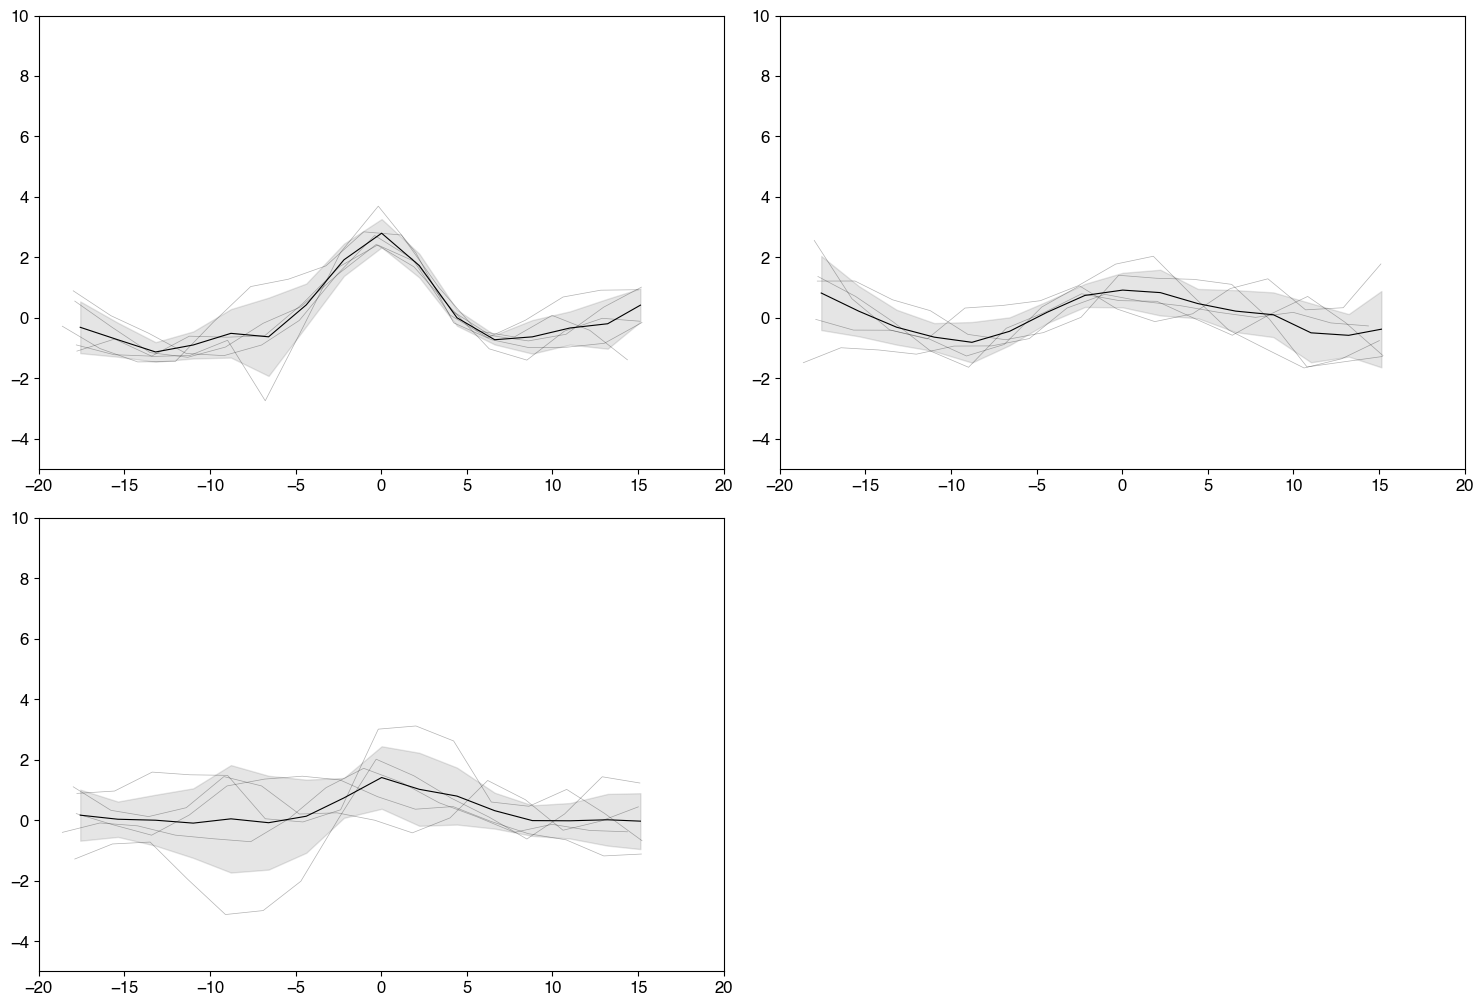

nope th


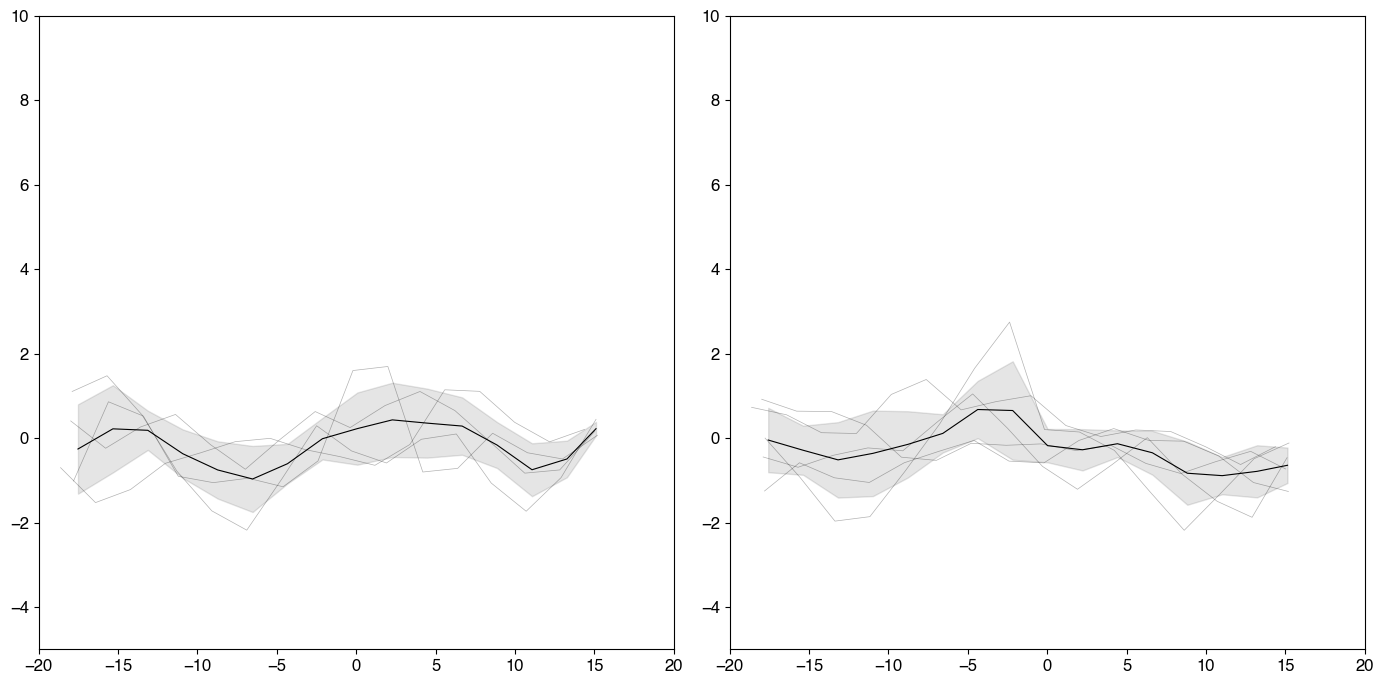

/tmp/ipykernel_2274/2089264327.py:20: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3,2,1)


nope th
nope th


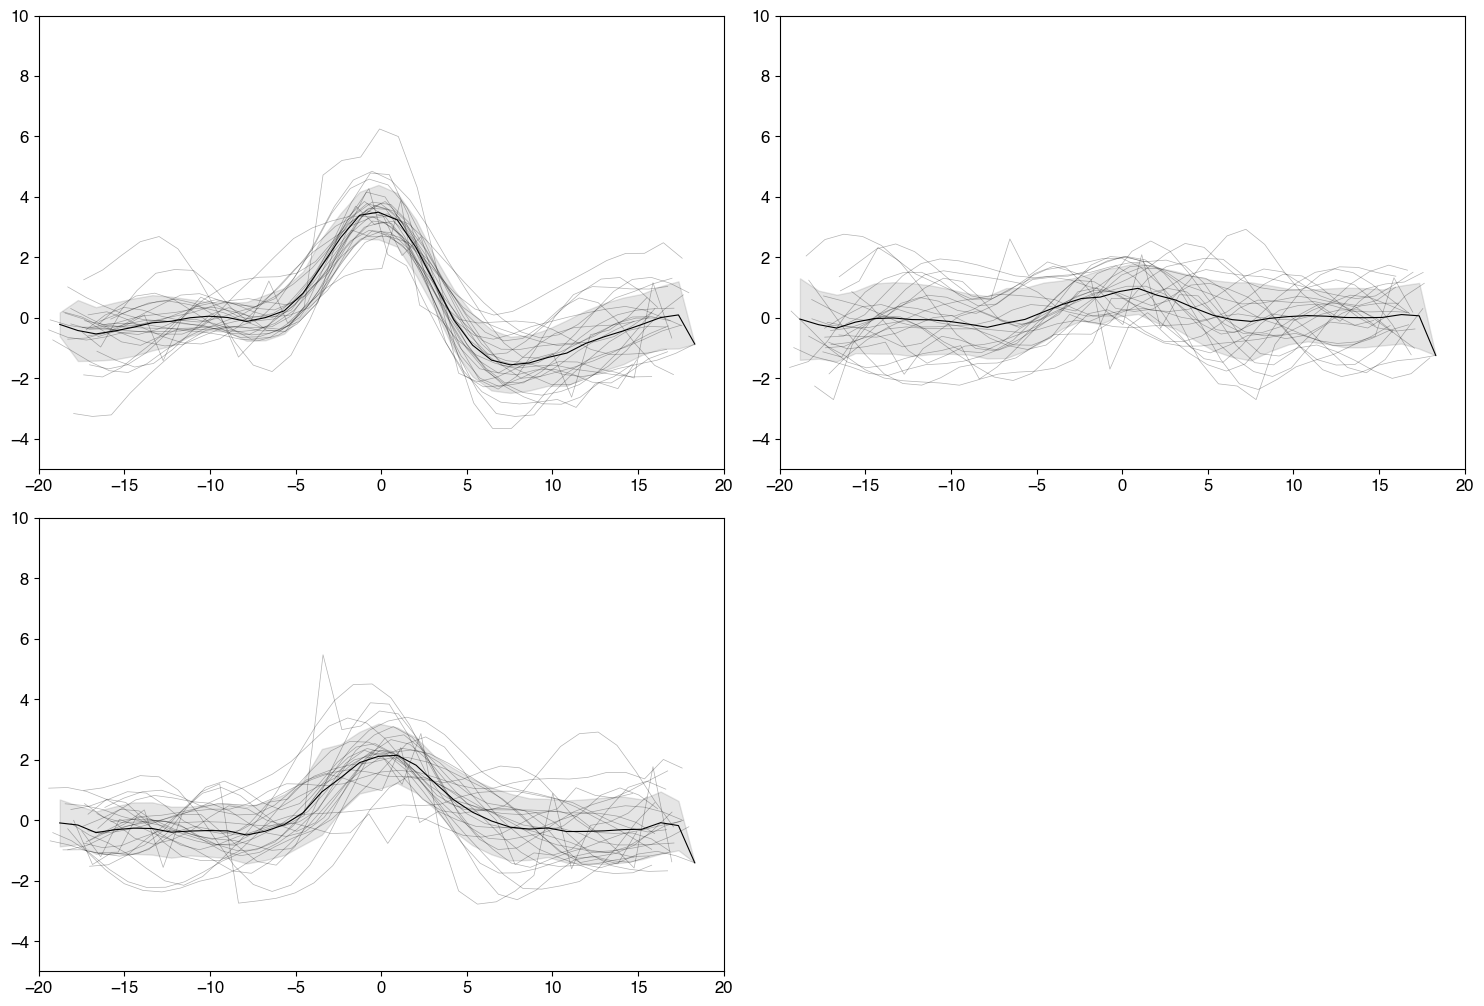

nope th
nope th


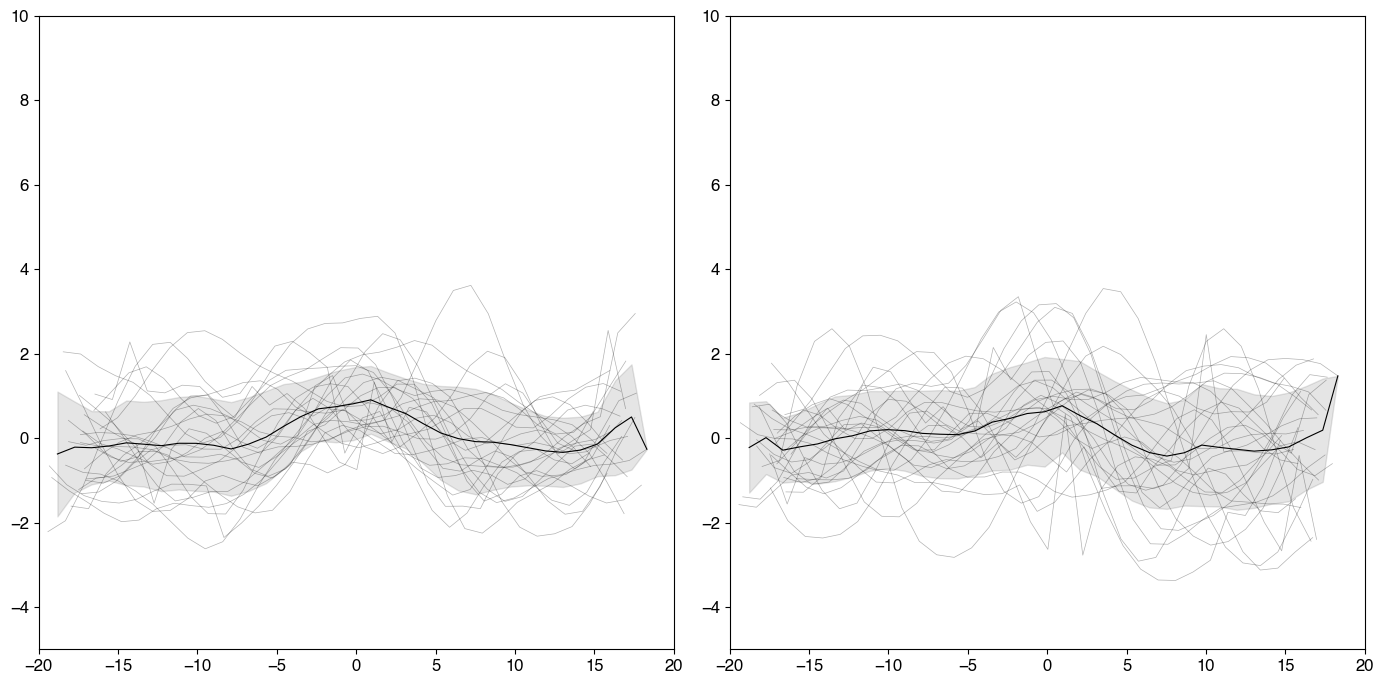

/tmp/ipykernel_2274/2089264327.py:20: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3,2,1)


nope
nope th
nope cereb


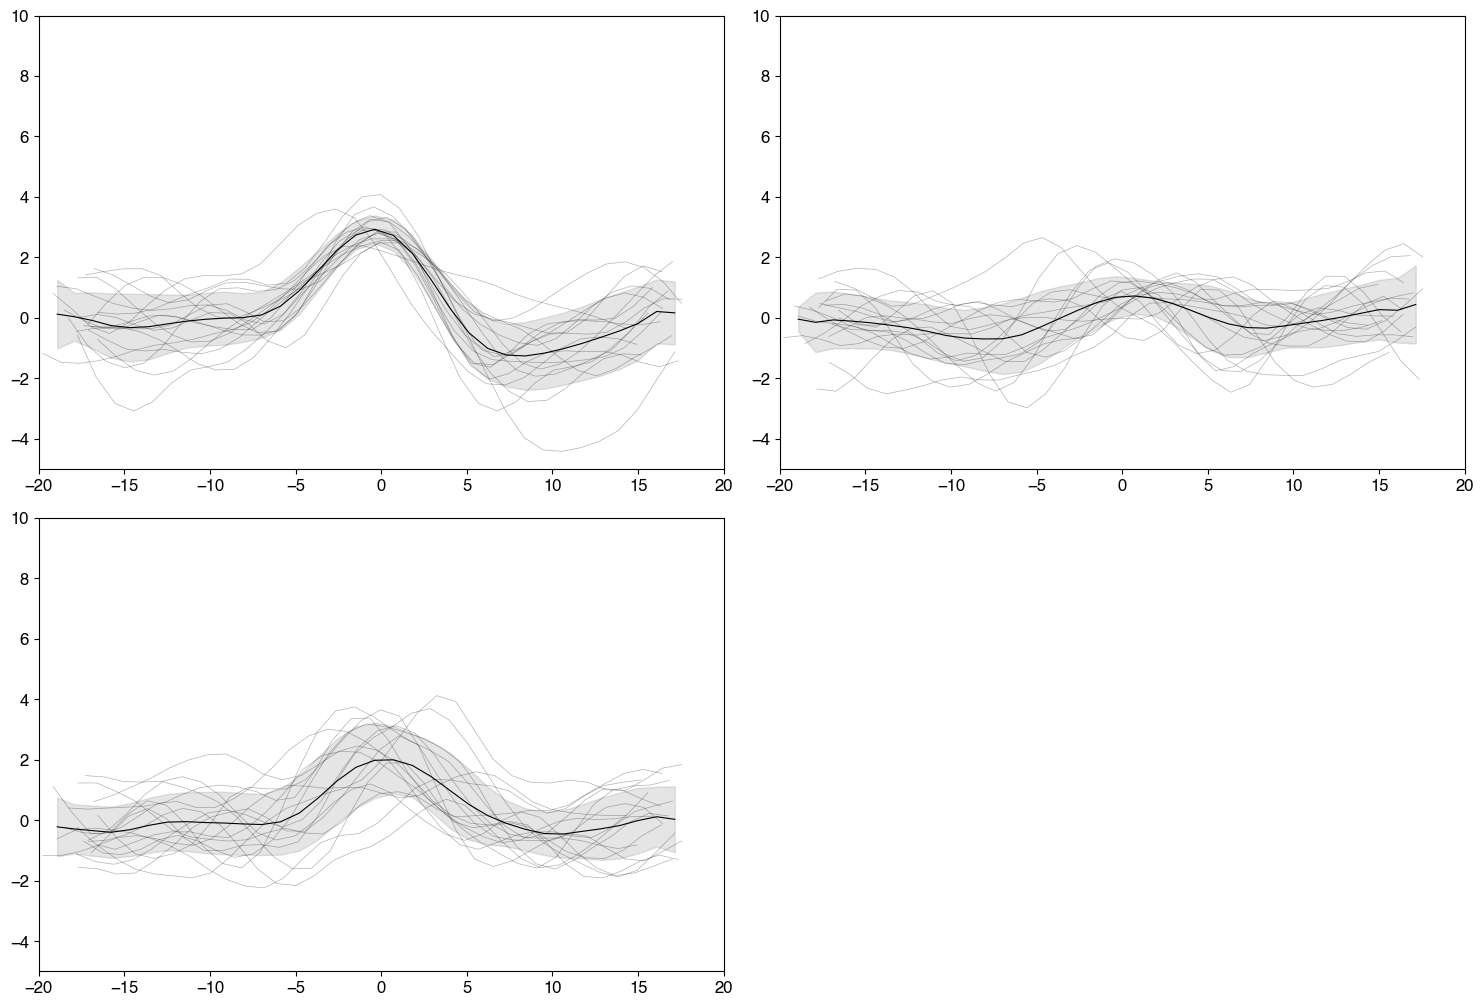

nope th
nope cereb


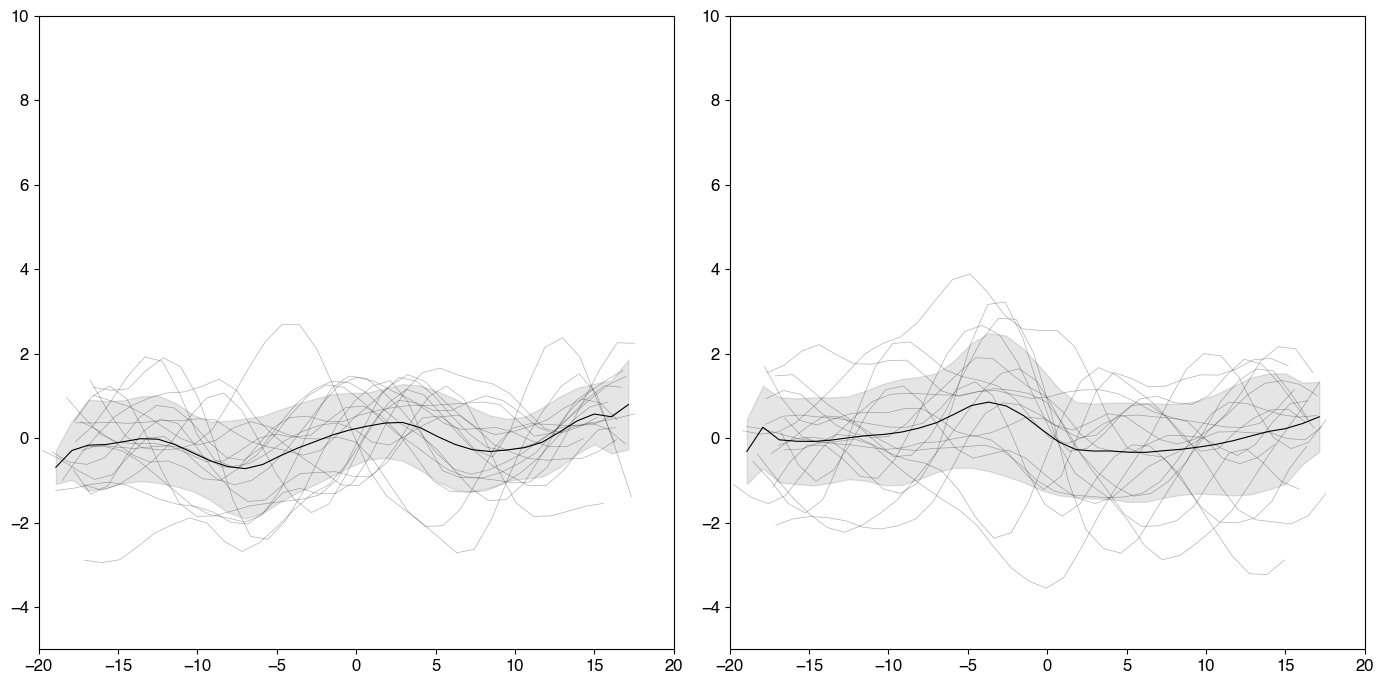

In [91]:
#HERE0510        
            
TR=[2.2,1.1,1.1]
listname=['pre','post','during']
for e,s in enumerate(sub):

    N=0
    realtime=0
    e2=2
    p2=pplist[e][e2]
    plt.figure(figsize=(15,15))
    plt.title(s+' '+listname[e2])
    
    
    p5=np.unique([p3.split('_')[0] for p3 in p2])
    keept=[]
    keepv=[]
    keept2=[]
    keepv2=[]
    plt.subplot(3,2,1)
    for e4,p4 in enumerate(p5):
        
        vc=p4
        allpulseR=[i for i in pulsevaluesclean[s].keys() if i.find(vc)!=-1]
        removepulse=[i for i in pulsevaluesLclean[s].keys() if i.find(vc)!=-1]#[i for i in pulsevalues[s].keys() if i.find(vc)!=-1 and len(pulsevalues[s][i]['hrfparam'])!=0]
        
        for e3,i in enumerate(allpulseR):
            if np.max(np.abs(np.diff(np.diff(np.array(pulsevaluesclean[s][i]['val'])))))>8:#(e4==5)&(e3==3)&(e==2):
                print('nope')
            else:
                param=pulsevaluesclean[s][i]['hrfparam']

                time=np.array(pulsevaluesclean[s][i]['time'])#np.array([j/4. for j in range(120)])-param[0]
                val=np.array(pulsevaluesclean[s][i]['val'])
                
                seaborn.lineplot(x=time-param[0]+param[2]/2.,y=val,color='k',linewidth = 0.5,alpha=0.3)
                keept+=[time-param[0]+param[2]/2.]
                keepv+=[val]
    keept=np.concatenate(keept,0)
    keepv=np.concatenate(keepv,0)
    bins=np.concatenate([[np.min(keept)+TR[e]*i for i in range(60) if np.min(keept)+TR[e]*i<np.max(keept)],[np.max(keept)]],0)
    keeptbin=[np.mean(keept[np.where((keept<=bins[i]) & (keept>bins[i-1]))[0]]) for i in range(1,len(bins))]
    
    keepvbin=np.array([np.mean(keepv[np.where((keept<=bins[i]) & (keept>bins[i-1]))[0]]) for i in range(1,len(bins))])
    keepsdbin=np.array([np.std(keepv[np.where((keept<=bins[i]) & (keept>bins[i-1]))[0]]) for i in range(1,len(bins))])
    #param=scipy.optimize.curve_fit(nipy.modalities.fmri.hrf.spm_hrf_compat,keeptbin,keepvbin,bounds=([15,25,0.1,0.1,0.1],[20,30,4,4,6]))[0]
    #val=nipy.modalities.fmri.hrf.spm_hrf_compat(np.array(keeptbin),param[0],param[1],param[2],param[3],param[4],1) 
    plt.ylim([-5,10])
    plt.xlim([-20,20])
    seaborn.lineplot(x=keeptbin,y=keepvbin,color='k',linewidth = 0.8)
    plt.fill_between(x=keeptbin,y1=keepvbin-keepsdbin,y2=keepvbin+keepsdbin,color='k',alpha=0.1)
    plt.subplot(3,2,2)
    for e4,p4 in enumerate(p5):
        
        vc=p4
        allpulseR=[i for i in pulsevaluesclean[s].keys() if i.find(vc)!=-1]
        removepulse=[i for i in pulsevaluesLclean[s].keys() if i.find(vc)!=-1]#[i for i in pulsevalues[s].keys() if i.find(vc)!=-1 and len(pulsevalues[s][i]['hrfparam'])!=0]
        
        for e3,i in enumerate(allpulseR):
            if np.max(np.abs(np.diff(np.diff(np.array(pulsevaluesclean[s][i]['valthalam'])))))>5:#(e4==5)&(e3==3)&(e==2):
                print('nope th')
            else:
                param=pulsevaluesclean[s][i]['hrfparam']

                time=np.array(pulsevaluesclean[s][i]['time'])#np.array([j/4. for j in range(120)])-param[0]
                val=np.array(pulsevaluesclean[s][i]['valthalam'])

                ax2=seaborn.lineplot(x=time-param[0]+param[2]/2.,y=val,color='k',linewidth = 0.5,alpha=0.3)
                keept2+=[time-param[0]+param[2]/2.]
                keepv2+=[val]
    
    keept2=np.concatenate(keept2,0)
    keepv2=np.concatenate(keepv2,0)
    bins=np.concatenate([[np.min(keept2)+TR[e]*i for i in range(60) if np.min(keept2)+TR[e]*i<np.max(keept2)],[np.max(keept2)]],0)
    keeptbin=[np.mean(keept2[np.where((keept2<=bins[i]) & (keept2>bins[i-1]))[0]]) for i in range(1,len(bins))]
    
    keepvbin=np.array([np.mean(keepv2[np.where((keept2<=bins[i]) & (keept2>bins[i-1]))[0]]) for i in range(1,len(bins))])
    keepsdbin=np.array([np.std(keepv2[np.where((keept2<=bins[i]) & (keept2>bins[i-1]))[0]]) for i in range(1,len(bins))])
    #param=scipy.optimize.curve_fit(nipy.modalities.fmri.hrf.spm_hrf_compat,keeptbin,keepvbin,bounds=([15,25,0.1,0.1,0.1],[20,30,4,4,6]))[0]
    #val=nipy.modalities.fmri.hrf.spm_hrf_compat(np.array(keeptbin),param[0],param[1],param[2],param[3],param[4],1) 
    
    seaborn.lineplot(x=keeptbin,y=keepvbin,color='k',linewidth = 0.8)
    plt.fill_between(x=keeptbin,y1=keepvbin-keepsdbin,y2=keepvbin+keepsdbin,color='k',alpha=0.1)
    plt.ylim([-5,10])
    plt.xlim([-20,20])
    
    
    plt.subplot(3,2,3)
    keept2=[]
    keepv2=[]
    for e4,p4 in enumerate(p5):
        
        vc=p4
        allpulseR=[i for i in pulsevaluesclean[s].keys() if i.find(vc)!=-1]
        removepulse=[i for i in pulsevaluesLclean[s].keys() if i.find(vc)!=-1]#[i for i in pulsevalues[s].keys() if i.find(vc)!=-1 and len(pulsevalues[s][i]['hrfparam'])!=0]
        
        for e3,i in enumerate(allpulseR):
            
            if np.max(np.abs(np.diff(np.diff(np.array(pulsevaluesclean[s][i]['valcereb'])))))>8:#(e4==5)&(e3==3)&(e==2):
                print('nope cereb')
            else:
                param=pulsevaluesclean[s][i]['hrfparam']

                time=np.array(pulsevaluesclean[s][i]['time'])#np.array([j/4. for j in range(120)])-param[0]
                val=np.array(pulsevaluesclean[s][i]['valcereb'])

                ax2=seaborn.lineplot(x=time-param[0]+param[2]/2.,y=val,color='k',linewidth = 0.5,alpha=0.3)
                keept2+=[time-param[0]+param[2]/2.]
                keepv2+=[val]
    
    keept2=np.concatenate(keept2,0)
    keepv2=np.concatenate(keepv2,0)
    bins=np.concatenate([[np.min(keept2)+TR[e]*i for i in range(60) if np.min(keept2)+TR[e]*i<np.max(keept2)],[np.max(keept2)]],0)
    keeptbin=[np.mean(keept2[np.where((keept2<=bins[i]) & (keept2>bins[i-1]))[0]]) for i in range(1,len(bins))]
    keepvbin=np.array([np.mean(keepv2[np.where((keept2<=bins[i]) & (keept2>bins[i-1]))[0]]) for i in range(1,len(bins))])
    keepsdbin=np.array([np.std(keepv2[np.where((keept2<=bins[i]) & (keept2>bins[i-1]))[0]]) for i in range(1,len(bins))])
    #param=scipy.optimize.curve_fit(nipy.modalities.fmri.hrf.spm_hrf_compat,keeptbin,keepvbin,bounds=([15,25,0.1,0.1,0.1],[20,30,4,4,6]))[0]
    #val=nipy.modalities.fmri.hrf.spm_hrf_compat(np.array(keeptbin),param[0],param[1],param[2],param[3],param[4],1) 
    
    seaborn.lineplot(x=keeptbin,y=keepvbin,color='k',linewidth = 0.8)
    plt.fill_between(x=keeptbin,y1=keepvbin-keepsdbin,y2=keepvbin+keepsdbin,color='k',alpha=0.1)
    plt.ylim([-5,10])
    plt.xlim([-20,20])
    
    plt.savefig(path+'/RosCha/Results/figures/plasticitypulses/pulseshape'+s+'_LSM1_top20N.pdf')
    plt.show()
    

# visu function

In [42]:

def plotsurfwithcont(ciftiloc,img_contour,contval,contcolor,vmin=None,vmax=None,palette='',savefig='', threshold=None, cbar_vmin=None, cbar_vmax=None,background=True,avg='mean',rollZ=0,rollX=0,scale=0.8):
    if ciftiloc[len(ciftiloc)-len('dtseries.nii'):]=='dtseries.nii':
        tag='dtseries'
    else:
        tag='dscalar'
    if img_contour[len(img_contour)-len('dtseries.nii'):]=='dtseries.nii':
        tag2='dtseries'
    else:
        tag2='dscalar'
    if palette=='':
        palette=sns.diverging_palette(250, 30, l=65, as_cmap=True)
    subprocess.call(['wb_command','-cifti-separate-all',ciftiloc,'-volume',ciftiloc.replace('.'+tag+'.nii','_vol.nii.gz'),'-left',ciftiloc.replace('.'+tag+'.nii','_L.func.gii'),'-right',ciftiloc.replace('.'+tag+'.nii','_R.func.gii')])

    figure, axes = plt.subplots(2,2,subplot_kw={'projection': '3d'},figsize=(35,25))

    mapL="/data/nil-bluearc/GMT/Evan/Atlases/32k_ConteAtlas_v2_distribute/Conte69.L.inflated.32k_fs_LR.surf.gii"
    mapR="/data/nil-bluearc/GMT/Evan/Atlases/32k_ConteAtlas_v2_distribute/Conte69.R.inflated.32k_fs_LR.surf.gii"
    bgL="/data/nil-bluearc/GMT/Evan/Atlases/32k_ConteAtlas_v2_distribute/Conte69.L.32k_fs_LR.shape.gii"
    bgR="/data/nil-bluearc/GMT/Evan/Atlases/32k_ConteAtlas_v2_distribute/Conte69.R.32k_fs_LR.shape.gii"
    

    
    
    nilearn.plotting.plot_surf(mapL,surf_map=ciftiloc.replace('.'+tag+'.nii','_L.func.gii'),vmin=vmin,vmax=vmax,hemi='left', view='lateral',cmap=palette, bg_map=bgL,bg_on_data=background, darkness=0.4,axes=axes[0][0],figure=figure, threshold=threshold, cbar_vmin=cbar_vmin, cbar_vmax=cbar_vmax,avg_method=avg,alpha=1)

    nilearn.plotting.plot_surf(mapL, surf_map=ciftiloc.replace('.'+tag+'.nii','_L.func.gii'),vmin=vmin,vmax=vmax,hemi='left', view='medial',cmap=palette, bg_map=bgL,bg_on_data=background, darkness=0.4,axes=axes[1][0],figure=figure, threshold=threshold, cbar_vmin=cbar_vmin, cbar_vmax=cbar_vmax,avg_method=avg,alpha=1)

    
    
    nilearn.plotting.plot_surf(mapR, surf_map=ciftiloc.replace('.'+tag+'.nii','_R.func.gii'),vmin=vmin,vmax=vmax,hemi='right', view='lateral',cmap=palette, bg_map=bgR,bg_on_data=background, darkness=0.4,axes=axes[0][1],figure=figure, threshold=threshold, cbar_vmin=cbar_vmin, cbar_vmax=cbar_vmax,avg_method=avg,alpha=1)

    nilearn.plotting.plot_surf(mapR, surf_map=ciftiloc.replace('.'+tag+'.nii','_R.func.gii'),vmin=vmin,vmax=vmax,hemi='right', view='medial',cmap=palette, bg_map=bgR,bg_on_data=background, darkness=0.4,axes=axes[1][1],figure=figure, threshold=threshold, cbar_vmin=cbar_vmin, cbar_vmax=cbar_vmax,avg_method=avg,alpha=1)
    
    subprocess.call(['wb_command','-cifti-separate-all',img_contour,'-volume',img_contour.replace('.'+tag2+'.nii','_vol.nii.gz'),'-left',img_contour.replace('.'+tag2+'.nii','_L.func.gii'),'-right',img_contour.replace('.'+tag2+'.nii','_R.func.gii')])
    for c in range(len(contcolor)):
        try:
            nilearn.plotting.plot_surf_contours(mapL,img_contour.replace('.'+tag2+'.nii','_L.func.gii'), levels=[contval[c]], colors=[contcolor[c]],axes=axes[0][0],figure=figure,alpha=1)
        except:
            print('Llat')#a=1
        #(surf_mesh, roi_map, axes=None, figure=None, levels=None, labels=None, colors=None, legend=False, cmap='tab20', title=None, output_file=None, **kwargs)[source]
        try:
            nilearn.plotting.plot_surf_contours(mapR,img_contour.replace('.'+tag2+'.nii','_R.func.gii'), levels=[contval[c]], colors=[contcolor[c]],axes=axes[0][1],figure=figure,alpha=1)
        except:
            print('Rlat')#a=1
        try:
            nilearn.plotting.plot_surf_contours(mapL,img_contour.replace('.'+tag2+'.nii','_L.func.gii'), levels=[contval[c]], colors=[contcolor[c]],axes=axes[1][0],figure=figure,alpha=1)
        except:
            print('Lmed')#a=1
        try:
            nilearn.plotting.plot_surf_contours(mapR,img_contour.replace('.'+tag2+'.nii','_R.func.gii'), levels=[contval[c]], colors=[contcolor[c]],axes=axes[1][1],figure=figure,alpha=1)
        except:
            print('Rmed')#a=1
    plt.tight_layout()
    
    for ax in range(len(axes)):
        for ax2 in range(len(axes[0])):
            elev=axes[ax][ax2].elev+rollZ*(-1*ax+1*(np.abs(ax-1)))
            azim=axes[ax][ax2].azim+rollX*(-1*ax2+1*(np.abs(ax2-1)))
            axes[ax][ax2].view_init(elev,azim)
            prov=axes[ax][ax2].get_xlim()
            axes[ax][ax2].set_xlim3d(prov[0]*scale,prov[1]*scale)
            prov=axes[ax][ax2].get_zlim()
            axes[ax][ax2].set_zlim3d(prov[0]*scale,prov[1]*scale)
            prov=axes[ax][ax2].get_ylim()
            axes[ax][ax2].set_ylim3d(prov[0]*scale,prov[1]*scale)
            
    if savefig!='':
        plt.savefig(savefig)
    plt.show()
    
    nilearn.plotting.plot_surf(mapR, surf_map=ciftiloc.replace('.'+tag+'.nii','_R.func.gii'),vmin=vmin,vmax=vmax,hemi='right', view='medial',cmap=palette, bg_map=bgR,bg_on_data=background, darkness=0.4,colorbar=True, threshold=threshold, cbar_vmin=cbar_vmin, cbar_vmax=cbar_vmax,avg_method=avg)
    if savefig!='':
        plt.savefig(savefig[:savefig.rfind('.')]+'-colorbar'+savefig[savefig.rfind('.'):])
    plt.show()
    subprocess.call(['rm',ciftiloc.replace('.'+tag+'.nii','_vol.nii.gz'),ciftiloc.replace('.'+tag+'.nii','_L.func.gii'),ciftiloc.replace('.'+tag+'.nii','_R.func.gii')])
    subprocess.call(['rm',img_contour.replace('.'+tag2+'.nii','_vol.nii.gz'),img_contour.replace('.'+tag2+'.nii','_L.func.gii'),img_contour.replace('.'+tag2+'.nii','_R.func.gii')])

In [43]:
def plotsurf(ciftiloc,vmin=None,vmax=None,palette='',savefig='', threshold=None, cbar_vmin=None, cbar_vmax=None,background=True,avg='mean',rollZ=0,rollX=0,scale=0.8):
    if ciftiloc[len(ciftiloc)-len('dtseries.nii'):]=='dtseries.nii':
        tag='dtseries'
    else:
        tag='dscalar'
    if palette=='':
        palette=sns.diverging_palette(250, 30, l=65, as_cmap=True)
    subprocess.call(['wb_command','-cifti-separate-all',ciftiloc,'-volume',ciftiloc.replace('.'+tag+'.nii','_vol.nii.gz'),'-left',ciftiloc.replace('.'+tag+'.nii','_L.func.gii'),'-right',ciftiloc.replace('.'+tag+'.nii','_R.func.gii')])

    figure, axes = plt.subplots(2,2,subplot_kw={'projection': '3d'},figsize=(35,25))

    mapL="/data/nil-bluearc/GMT/Evan/Atlases/32k_ConteAtlas_v2_distribute/Conte69.L.inflated.32k_fs_LR.surf.gii"
    mapR="/data/nil-bluearc/GMT/Evan/Atlases/32k_ConteAtlas_v2_distribute/Conte69.R.inflated.32k_fs_LR.surf.gii"
    bgL="/data/nil-bluearc/GMT/Evan/Atlases/32k_ConteAtlas_v2_distribute/Conte69.L.32k_fs_LR.shape.gii"
    bgR="/data/nil-bluearc/GMT/Evan/Atlases/32k_ConteAtlas_v2_distribute/Conte69.R.32k_fs_LR.shape.gii"
    nilearn.plotting.plot_surf(mapL,surf_map=ciftiloc.replace('.'+tag+'.nii','_L.func.gii'),vmin=vmin,vmax=vmax,hemi='left', view='lateral',cmap=palette, bg_map=bgL,bg_on_data=background, darkness=0.4,axes=axes[0][0],figure=figure, threshold=threshold, cbar_vmin=cbar_vmin, cbar_vmax=cbar_vmax,avg_method=avg,alpha=1)
    
    nilearn.plotting.plot_surf(mapR, surf_map=ciftiloc.replace('.'+tag+'.nii','_R.func.gii'),vmin=vmin,vmax=vmax,hemi='right', view='lateral',cmap=palette, bg_map=bgR,bg_on_data=background, darkness=0.4,axes=axes[0][1],figure=figure, threshold=threshold, cbar_vmin=cbar_vmin, cbar_vmax=cbar_vmax,avg_method=avg,alpha=1)

    nilearn.plotting.plot_surf(mapL, surf_map=ciftiloc.replace('.'+tag+'.nii','_L.func.gii'),vmin=vmin,vmax=vmax,hemi='left', view='medial',cmap=palette, bg_map=bgL,bg_on_data=background, darkness=0.4,axes=axes[1][0],figure=figure, threshold=threshold, cbar_vmin=cbar_vmin, cbar_vmax=cbar_vmax,avg_method=avg,alpha=1)

    nilearn.plotting.plot_surf(mapR, surf_map=ciftiloc.replace('.'+tag+'.nii','_R.func.gii'),vmin=vmin,vmax=vmax,hemi='right', view='medial',cmap=palette, bg_map=bgR,bg_on_data=background, darkness=0.4,axes=axes[1][1],figure=figure, threshold=threshold, cbar_vmin=cbar_vmin, cbar_vmax=cbar_vmax,avg_method=avg,alpha=1)
    plt.tight_layout()
    
    for ax in range(len(axes)):
        for ax2 in range(len(axes[0])):
            elev=axes[ax][ax2].elev+rollZ*(-1*ax+1*(np.abs(ax-1)))
            azim=axes[ax][ax2].azim+rollX*(-1*ax2+1*(np.abs(ax2-1)))
            axes[ax][ax2].view_init(elev,azim)
            prov=axes[ax][ax2].get_xlim()
            axes[ax][ax2].set_xlim3d(prov[0]*scale,prov[1]*scale)
            prov=axes[ax][ax2].get_zlim()
            axes[ax][ax2].set_zlim3d(prov[0]*scale,prov[1]*scale)
            prov=axes[ax][ax2].get_ylim()
            axes[ax][ax2].set_ylim3d(prov[0]*scale,prov[1]*scale)
            
    if savefig!='':
        plt.savefig(savefig)
    plt.show()
    
    nilearn.plotting.plot_surf(mapR, surf_map=ciftiloc.replace('.'+tag+'.nii','_R.func.gii'),vmin=vmin,vmax=vmax,hemi='right', view='medial',cmap=palette, bg_map=bgR,bg_on_data=background, darkness=0.4,colorbar=True, threshold=threshold, cbar_vmin=cbar_vmin, cbar_vmax=cbar_vmax,avg_method=avg)
    if savefig!='':
        plt.savefig(savefig[:savefig.rfind('.')]+'-colorbar'+savefig[savefig.rfind('.'):])
    plt.show()
    subprocess.call(['rm',ciftiloc.replace('.'+tag+'.nii','_vol.nii.gz'),ciftiloc.replace('.'+tag+'.nii','_L.func.gii'),ciftiloc.replace('.'+tag+'.nii','_R.func.gii')])

In [44]:
def plotsurfwithroi(ciftiloc,roi,roival=1,vmin=None,vmax=None,palette='',savefig='', threshold=None, cbar_vmin=None, cbar_vmax=None,background=True,avg='mean',rollZ=0,rollX=0,scale=0.8):
    if roi[len(roi)-len('dtseries.nii'):]=='dtseries.nii':
        tag3='dtseries'
    else:
        tag3='dscalar'
    raw=nibabel.load(roi)
    data=copy.deepcopy(np.array(raw.dataobj[0]))
    data[np.where(data!=roival)]=0
    data[np.where(data==roival)]=1
    
    
    axes = [raw.header.get_axis(i) for i in range(raw.ndim)]
    # You'll want the brain model axis
    time_axis, brain_model_axis = axes
    
    if tag3=='dscalar':
        time_axis2=nibabel.cifti2.cifti2_axes.ScalarAxis(['val'])
    else:
        time_axis2=nibabel.cifti2.cifti2_axes.SeriesAxis(1,1,1)
    img=ci.Cifti2Image(np.array([data]), header=(time_axis2, brain_model_axis),
            nifti_header=raw.nifti_header)
    ci.save(img,roi.replace('.'+tag3+'.nii','_valselect.'+tag3+'.nii'))
     
    
    roi=roi.replace('.'+tag3+'.nii','_valselect.'+tag3+'.nii')
    print(roi)
    if ciftiloc[len(ciftiloc)-len('dtseries.nii'):]=='dtseries.nii':
        tag='dtseries'
    else:
        tag='dscalar'
    
    
    if palette=='':
        palette=sns.diverging_palette(250, 30, l=65, as_cmap=True)
    subprocess.call(['wb_command','-cifti-separate-all',ciftiloc,'-volume',ciftiloc.replace('.'+tag+'.nii','_vol.nii.gz'),'-left',ciftiloc.replace('.'+tag+'.nii','_L.func.gii'),'-right',ciftiloc.replace('.'+tag+'.nii','_R.func.gii')])

    figure, axes = plt.subplots(2,2,subplot_kw={'projection': '3d'},figsize=(35,15),layout='compressed')#,figsize=(35,25))
    plt.rcParams["figure.autolayout"] = True
    mapL="/data/nil-bluearc/GMT/Evan/Atlases/32k_ConteAtlas_v2_distribute/Conte69.L.inflated.32k_fs_LR.surf.gii"
    mapR="/data/nil-bluearc/GMT/Evan/Atlases/32k_ConteAtlas_v2_distribute/Conte69.R.inflated.32k_fs_LR.surf.gii"
    bgL="/data/nil-bluearc/GMT/Evan/Atlases/32k_ConteAtlas_v2_distribute/Conte69.L.32k_fs_LR.shape.gii"
    bgR="/data/nil-bluearc/GMT/Evan/Atlases/32k_ConteAtlas_v2_distribute/Conte69.R.32k_fs_LR.shape.gii"
    nilearn.plotting.plot_surf(mapL,surf_map=ciftiloc.replace('.'+tag+'.nii','_L.func.gii'),vmin=vmin,vmax=vmax,hemi='left', view='lateral',cmap=palette, bg_map=bgL,bg_on_data=background, darkness=0.4,axes=axes[0][0],figure=figure, threshold=threshold, cbar_vmin=cbar_vmin, cbar_vmax=cbar_vmax,avg_method=avg,alpha=1)

    nilearn.plotting.plot_surf(mapR, surf_map=ciftiloc.replace('.'+tag+'.nii','_R.func.gii'),vmin=vmin,vmax=vmax,hemi='right', view='lateral',cmap=palette, bg_map=bgR,bg_on_data=background, darkness=0.4,axes=axes[0][1],figure=figure, threshold=threshold, cbar_vmin=cbar_vmin, cbar_vmax=cbar_vmax,avg_method=avg,alpha=1)

    nilearn.plotting.plot_surf(mapL, surf_map=ciftiloc.replace('.'+tag+'.nii','_L.func.gii'),vmin=vmin,vmax=vmax,hemi='left', view='medial',cmap=palette, bg_map=bgL,bg_on_data=background, darkness=0.4,axes=axes[1][0],figure=figure, threshold=threshold, cbar_vmin=cbar_vmin, cbar_vmax=cbar_vmax,avg_method=avg,alpha=1)

    nilearn.plotting.plot_surf(mapR, surf_map=ciftiloc.replace('.'+tag+'.nii','_R.func.gii'),vmin=vmin,vmax=vmax,hemi='right', view='medial',cmap=palette, bg_map=bgR,bg_on_data=background, darkness=0.4,axes=axes[1][1],figure=figure, threshold=threshold, cbar_vmin=cbar_vmin, cbar_vmax=cbar_vmax,avg_method=avg,alpha=1)
    
    subprocess.call(['wb_command','-cifti-separate-all',roi,'-volume',roi.replace('.'+tag3+'.nii','_vol.nii.gz'),'-left',roi.replace('.'+tag3+'.nii','_L.func.gii'),'-right',roi.replace('.'+tag3+'.nii','_R.func.gii')])
    try:       
        nilearn.plotting.plot_surf_contours(mapL,roi.replace('.'+tag3+'.nii','_L.func.gii'), axes=axes[0][0],figure=figure, levels=[1],colors=['k'],filled=True)
        nilearn.plotting.plot_surf_contours(mapL, roi.replace('.'+tag3+'.nii','_L.func.gii'),axes=axes[1][0],figure=figure, levels=[1],colors=['k'],filled=True)
    except:
        print('nothing on left hemi roi')
    try:
        nilearn.plotting.plot_surf_contours(mapR, roi.replace('.'+tag3+'.nii','_R.func.gii'), axes=axes[0][1],figure=figure, levels=[1],colors=['k'],filled=True)
        nilearn.plotting.plot_surf_contours(mapR,roi.replace('.'+tag3+'.nii','_R.func.gii'),axes=axes[1][1],figure=figure, levels=[1],colors=['k'],filled=True)
    except:
        print('nothing on right hemi roi')
    
    #plt.tight_layout()
    
    for ax in range(len(axes)):
        for ax2 in range(len(axes[0])):
            elev=axes[ax][ax2].elev+rollZ*(-1*ax+1*(np.abs(ax-1)))
            azim=axes[ax][ax2].azim+rollX*(-1*ax2+1*(np.abs(ax2-1)))
            axes[ax][ax2].view_init(elev,azim)
            axes[ax][ax2].set_box_aspect((1,1,5/7.))
            axes[ax][ax2].set_adjustable('box')
            prov=axes[ax][ax2].get_xlim()
            axes[ax][ax2].set_xlim3d(prov[0]*scale,prov[1]*scale)
            prov=axes[ax][ax2].get_zlim()
            axes[ax][ax2].set_zlim3d(prov[0]*scale,prov[1]*scale)
            prov=axes[ax][ax2].get_ylim()
            axes[ax][ax2].set_ylim3d(prov[0]*scale,prov[1]*scale)
            
    if savefig!='':
        plt.savefig(savefig)
    
    plt.show()
    
    nilearn.plotting.plot_surf(mapR, surf_map=ciftiloc.replace('.'+tag+'.nii','_R.func.gii'),vmin=vmin,vmax=vmax,hemi='right', view='medial',cmap=palette, bg_map=bgR,bg_on_data=background, darkness=0.4,colorbar=True, threshold=threshold, cbar_vmin=cbar_vmin, cbar_vmax=cbar_vmax,avg_method=avg)
    if savefig!='':
        plt.savefig(savefig[:savefig.rfind('.')]+'-colorbar'+savefig[savefig.rfind('.'):])
    plt.show()
    subprocess.call(['rm',ciftiloc.replace('.'+tag+'.nii','_vol.nii.gz'),ciftiloc.replace('.'+tag+'.nii','_L.func.gii'),ciftiloc.replace('.'+tag+'.nii','_R.func.gii')])
    subprocess.call(['rm',roi.replace('.'+tag3+'.nii','_vol.nii.gz'),roi.replace('.'+tag3+'.nii','_L.func.gii'),roi.replace('.'+tag3+'.nii','_R.func.gii')])

In [45]:
def plotsurfwithcontNroi(ciftiloc,img_contour,roi,contval,contcolor,roival=1,vmin=None,vmax=None,palette='',savefig='', threshold=None, cbar_vmin=None, cbar_vmax=None,background=True,avg='mean',rollZ=0,rollX=0,scale=0.8):
    if roi[len(roi)-len('dtseries.nii'):]=='dtseries.nii':
        tag3='dtseries'
    else:
        tag3='dscalar'
    raw=nibabel.load(roi)
    data=copy.deepcopy(np.array(raw.dataobj[0]))
    data[np.where(data!=roival)]=0
    data[np.where(data==roival)]=1
    
    
    axes = [raw.header.get_axis(i) for i in range(raw.ndim)]
    # You'll want the brain model axis
    time_axis, brain_model_axis = axes
    
    if tag3=='dscalar':
        time_axis2=nibabel.cifti2.cifti2_axes.ScalarAxis(['val'])
    else:
        time_axis2=nibabel.cifti2.cifti2_axes.SeriesAxis(1,1,1)
    img=ci.Cifti2Image(np.array([data]), header=(time_axis2, brain_model_axis),
            nifti_header=raw.nifti_header)
    ci.save(img,roi.replace('.'+tag3+'.nii','_valselect.'+tag3+'.nii'))
     
    
    roi=roi.replace('.'+tag3+'.nii','_valselect.'+tag3+'.nii')
    
    if ciftiloc[len(ciftiloc)-len('dtseries.nii'):]=='dtseries.nii':
        tag='dtseries'
    else:
        tag='dscalar'
    if img_contour[len(img_contour)-len('dtseries.nii'):]=='dtseries.nii':
        tag2='dtseries'
    else:
        tag2='dscalar'
    
    if palette=='':
        palette=sns.diverging_palette(250, 30, l=65, as_cmap=True)
    subprocess.call(['wb_command','-cifti-separate-all',ciftiloc,'-volume',ciftiloc.replace('.'+tag+'.nii','_vol.nii.gz'),'-left',ciftiloc.replace('.'+tag+'.nii','_L.func.gii'),'-right',ciftiloc.replace('.'+tag+'.nii','_R.func.gii')])

    figure, axes = plt.subplots(2,2,subplot_kw={'projection': '3d'},figsize=(35,25))
    
    mapL="/data/nil-bluearc/GMT/Evan/Atlases/32k_ConteAtlas_v2_distribute/Conte69.L.inflated.32k_fs_LR.surf.gii"
    mapR="/data/nil-bluearc/GMT/Evan/Atlases/32k_ConteAtlas_v2_distribute/Conte69.R.inflated.32k_fs_LR.surf.gii"
    bgL="/data/nil-bluearc/GMT/Evan/Atlases/32k_ConteAtlas_v2_distribute/Conte69.L.32k_fs_LR.shape.gii"
    bgR="/data/nil-bluearc/GMT/Evan/Atlases/32k_ConteAtlas_v2_distribute/Conte69.R.32k_fs_LR.shape.gii"
    nilearn.plotting.plot_surf(mapL,surf_map=ciftiloc.replace('.'+tag+'.nii','_L.func.gii'),vmin=vmin,vmax=vmax,hemi='left', view='lateral',cmap=palette, bg_map=bgL,bg_on_data=background, darkness=0.4,axes=axes[0][0],figure=figure, threshold=threshold, cbar_vmin=cbar_vmin, cbar_vmax=cbar_vmax,avg_method=avg,alpha=1)

    nilearn.plotting.plot_surf(mapR, surf_map=ciftiloc.replace('.'+tag+'.nii','_R.func.gii'),vmin=vmin,vmax=vmax,hemi='right', view='lateral',cmap=palette, bg_map=bgR,bg_on_data=background, darkness=0.4,axes=axes[0][1],figure=figure, threshold=threshold, cbar_vmin=cbar_vmin, cbar_vmax=cbar_vmax,avg_method=avg,alpha=1)

    nilearn.plotting.plot_surf(mapL, surf_map=ciftiloc.replace('.'+tag+'.nii','_L.func.gii'),vmin=vmin,vmax=vmax,hemi='left', view='medial',cmap=palette, bg_map=bgL,bg_on_data=background, darkness=0.4,axes=axes[1][0],figure=figure, threshold=threshold, cbar_vmin=cbar_vmin, cbar_vmax=cbar_vmax,avg_method=avg,alpha=1)

    nilearn.plotting.plot_surf(mapR, surf_map=ciftiloc.replace('.'+tag+'.nii','_R.func.gii'),vmin=vmin,vmax=vmax,hemi='right', view='medial',cmap=palette, bg_map=bgR,bg_on_data=background, darkness=0.4,axes=axes[1][1],figure=figure, threshold=threshold, cbar_vmin=cbar_vmin, cbar_vmax=cbar_vmax,avg_method=avg,alpha=1)
    
    subprocess.call(['wb_command','-cifti-separate-all',roi,'-volume',roi.replace('.'+tag3+'.nii','_vol.nii.gz'),'-left',roi.replace('.'+tag3+'.nii','_L.func.gii'),'-right',roi.replace('.'+tag3+'.nii','_R.func.gii')])
    try:       
        nilearn.plotting.plot_surf_contours(mapL,roi.replace('.'+tag3+'.nii','_L.func.gii'), axes=axes[0][0],figure=figure, levels=[1],colors=['k'],filled=True)
        nilearn.plotting.plot_surf_contours(mapL, roi.replace('.'+tag3+'.nii','_L.func.gii'),axes=axes[1][0],figure=figure, levels=[1],colors=['k'],filled=True)
    except:
        print('nothing on left hemi roi')
    try:
        nilearn.plotting.plot_surf_contours(mapR, roi.replace('.'+tag3+'.nii','_R.func.gii'), axes=axes[0][1],figure=figure, levels=[1],colors=['k'],filled=True)
        nilearn.plotting.plot_surf_contours(mapR,roi.replace('.'+tag3+'.nii','_R.func.gii'),axes=axes[1][1],figure=figure, levels=[1],colors=['k'],filled=True)
    except:
        print('nothing on right hemi roi')
    
    subprocess.call(['wb_command','-cifti-separate-all',img_contour,'-volume',img_contour.replace('.'+tag2+'.nii','_vol.nii.gz'),'-left',img_contour.replace('.'+tag2+'.nii','_L.func.gii'),'-right',img_contour.replace('.'+tag2+'.nii','_R.func.gii')])
    for c in range(len(contcolor)):
        
        nilearn.plotting.plot_surf_contours(mapL,img_contour.replace('.'+tag2+'.nii','_L.func.gii'), levels=[contval[c]], colors=[contcolor[c]],axes=axes[0][0],figure=figure,alpha=1)#,alpha=0.5)
        nilearn.plotting.plot_surf_contours(mapR,img_contour.replace('.'+tag2+'.nii','_R.func.gii'), levels=[contval[c]], colors=[contcolor[c]],axes=axes[0][1],figure=figure,alpha=1)#,alpha=0.5)
        nilearn.plotting.plot_surf_contours(mapL,img_contour.replace('.'+tag2+'.nii','_L.func.gii'), levels=[contval[c]], colors=[contcolor[c]],axes=axes[1][0],figure=figure,alpha=1)#,alpha=0.5)
        nilearn.plotting.plot_surf_contours(mapR,img_contour.replace('.'+tag2+'.nii','_R.func.gii'), levels=[contval[c]], colors=[contcolor[c]],axes=axes[1][1],figure=figure,alpha=1)#,alpha=0.5)
    for ax in range(len(axes)):
        for ax2 in range(len(axes[0])):
            elev=axes[ax][ax2].elev+rollZ*(-1*ax+1*(np.abs(ax-1)))
            azim=axes[ax][ax2].azim+rollX*(-1*ax2+1*(np.abs(ax2-1)))
            axes[ax][ax2].view_init(elev,azim)
    plt.tight_layout()
    
    for ax in range(len(axes)):
        for ax2 in range(len(axes[0])):
            prov=axes[ax][ax2].get_xlim()
            axes[ax][ax2].set_xlim3d(prov[0]*scale,prov[1]*scale)
            prov=axes[ax][ax2].get_zlim()
            axes[ax][ax2].set_zlim3d(prov[0]*scale,prov[1]*scale)
            prov=axes[ax][ax2].get_ylim()
            axes[ax][ax2].set_ylim3d(prov[0]*scale,prov[1]*scale)
            
    if savefig!='':
        plt.savefig(savefig)
    
    plt.show()
    
    nilearn.plotting.plot_surf(mapR, surf_map=ciftiloc.replace('.'+tag+'.nii','_R.func.gii'),vmin=vmin,vmax=vmax,hemi='right', view='medial',cmap=palette, bg_map=bgR,bg_on_data=background, darkness=0.4,colorbar=True, threshold=threshold, cbar_vmin=cbar_vmin, cbar_vmax=cbar_vmax,avg_method=avg)
    if savefig!='':
        plt.savefig(savefig[:savefig.rfind('.')]+'-colorbar'+savefig[savefig.rfind('.'):])
    plt.show()
    subprocess.call(['rm',ciftiloc.replace('.'+tag+'.nii','_vol.nii.gz'),ciftiloc.replace('.'+tag+'.nii','_L.func.gii'),ciftiloc.replace('.'+tag+'.nii','_R.func.gii')])
    subprocess.call(['rm',img_contour.replace('.'+tag2+'.nii','_vol.nii.gz'),img_contour.replace('.'+tag2+'.nii','_L.func.gii'),img_contour.replace('.'+tag2+'.nii','_R.func.gii')])
    subprocess.call(['rm',roi.replace('.'+tag3+'.nii','_vol.nii.gz'),roi.replace('.'+tag3+'.nii','_L.func.gii'),roi.replace('.'+tag3+'.nii','_R.func.gii')])

In [31]:
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
def hex_to_rgb(value):
    '''
    Converts hex to rgb colours
    value: string of 6 characters representing a hex colour.
    Returns: list length 3 of RGB values'''
    value = value.strip("#") # removes hash symbol if present
    lv = len(value)
    return tuple(int(value[i:i + lv // 3], 16) for i in range(0, lv, lv // 3))


def rgb_to_dec(value):
    '''
    Converts rgb to decimal colours (i.e. divides each value by 256)
    value: list (length 3) of RGB values
    Returns: list (length 3) of decimal values'''
    return [v/256 for v in value]
def get_continuous_cmap(hex_list, float_list=None,N=256):
    ''' creates and returns a color map that can be used in heat map figures.
        If float_list is not provided, colour map graduates linearly between each color in hex_list.
        If float_list is provided, each color in hex_list is mapped to the respective location in float_list. 
        
        Parameters
        ----------
        hex_list: list of hex code strings
        
        float_list: list of floats between 0 and 1, same length as hex_list. Must start with 0 and end with 1.
        
        Returns
        ----------
        colour map'''
    rgb_list = [rgb_to_dec(hex_to_rgb(i)) for i in hex_list]
    if float_list:
        pass
    else:
        float_list = list(np.linspace(0,1,len(rgb_list)))
        
    cdict = dict()
    for num, col in enumerate(['red', 'green', 'blue']):
        col_list = [[float_list[i], rgb_list[i][num], rgb_list[i][num]] for i in range(len(float_list))]
        cdict[col] = col_list
    cmp = LinearSegmentedColormap('my_cmp', segmentdata=cdict, N=N)
    return cmp

In [32]:

black=np.array([0,0,0])
white=np.array([1,1,1])
grayscale=get_continuous_cmap(sns.color_palette([black,white]).as_hex())
grayscale2=get_continuous_cmap(sns.color_palette([white,white]).as_hex())

def plotZslices_alloption(niftipath,mnipath='',ortho='z',cut_coords='',Nraw=1,smoothing=None,LR=False,outdir='',colorpos='r',colorneg='b',Zannotate=False,thresholdpos='def',Zannotates='def',thresholdneg=False,alphamap=1,alphabrain=1):
    "niftipath: path to the nifti file, can be a 3D - if activation map, specify thresholds,"
    "mnipath : path to the mni T1 brain"
    "cut_coords can be a int as the number of zslices to display of a list of slices number (in MNI) (even list of one to get one specific slice)"
    "Nraw: the number of raw"
    "smoothing: number of voxel to smooth; LR:annotate left and right"
    "outdir:path to save the file"
    "color:list of color for each volume, or only one color, neg or pos if corresponding threshold to display"
    "Zannotate : Number=annotate z number, False=not annotate, Brain=on a X slice, with lign, or Both"
    "thresholdpos: specify threshold to cut and see above (can be a list for activation map: layer effect) or False will not be displayed or 'def' as 0.5 on normalized file"
    "thresholdneg: specify threshold to cut and see bellow (can be a list for activation map: layer effect) or False will not be displayed "
    import matplotlib.pyplot as plt
    import numpy as np
    import nilearn.plotting
    import nilearn.image   
    from nilearn.plotting import plot_roi, plot_stat_map
    from nilearn.plotting.find_cuts import find_cut_slices
    from nilearn.image.image import mean_img
    import nibabel
    import seaborn as sns
    initialcol=sns.light_palette((0,0,0), as_cmap=True)#'Greys'
    data=nibabel.load(niftipath)
    datasize=data.shape
    lineW=1./(Nraw+int((Zannotate=='Brain' or Zannotate=='Both')))
    mnipathtour='/opt/fsl/data/standard/MNI152_T1_1mm_brain.nii.gz'
    if mnipath=='':
        mnipath='/opt/fsl/data/standard/MNI152_T1_1mm_brain.nii.gz' ##this only works for the donders institute (Nijmegen, The Neterlands)
        valmni=[5000]
    else:
        valmni=[i for i in np.unique(nibabel.load(mnipath).get_fdata()) if i!=0]
    if type(cut_coords)==int or cut_coords=='':
        if cut_coords=='':
            cut_coords=6
        #find best cut
        if len(datasize)==4:
            #for 4D nifti
            cut_coords=find_cut_slices(mean_img(nibabel.nifti1.Nifti1Image(np.sign(np.abs(data.get_fdata())),data.affine)), n_cuts=cut_coords)
            print(cut_coords)
        else:
            #for 3D nifti
            cut_coords=find_cut_slices(data, n_cuts=cut_coords)
            print(cut_coords)
    
    #split in N raw
    if cut_coords!=(0,0,0):
        cut_coords=np.array(cut_coords)
        cc=cut_coords
        cut_coords=[cut_coords[int(i*len(cut_coords)/np.float(Nraw)):int((i+1)*len(cut_coords)/np.float(Nraw))] for i in range(Nraw)]
    else:
        cut_coords=[cut_coords]
    #define color as a vector (length :the number of volume):
    #if not enought color are proveded, the last of them is repeated
    #color are defined independantly for negative value display and positive value display
    if type(colorneg)==str:
        colorneg=[colorneg]
    if type(colorpos)==str:
        colorpos=[colorpos]
    if len(datasize)==4 and len(colorpos)!=datasize[3]:
        provcol=colorpos[len(colorpos)-1]
        colorpos=np.concatenate([colorpos,[provcol for i in range(datasize[3]-len(colorpos))]])
    if len(datasize)==4 and len(colorneg)!=datasize[3]:
        provcol=colorneg[len(colorneg)-1]
        colorneg=np.concatenate([colorneg,[provcol for i in range(datasize[3]-len(colorneg))]])

    #adjust threshold by normalizing image in the default version and taking 0.5
    if type(thresholdpos)==str:
        data=nibabel.nifti1.Nifti1Image(data.get_fdata()/np.float(np.max(data.get_fdata())),data.affine)
        thresholdpos=[0.5]
    #organize thresholds, more than 1 threshold to make a layer effect,
    #positive and negative values display are treated independantly:
    if type(thresholdpos)!=bool: thresholdpos=[i for i in np.sort(thresholdpos)]
    if type(thresholdneg)!=bool: 
        if np.sum(thresholdneg)<0:
            thresholdneg=[i for i in -np.sort(-1*np.array(thresholdneg))]
        else:
            thresholdneg=[i for i in np.sort(thresholdneg)]
    #load data to create a white backgroung
    func=mean_img(nibabel.nifti1.Nifti1Image(np.sign(np.abs(data.get_fdata())),data.affine))
    
    ####################subplot
    for i in range(Nraw):
        
        ax=plt.subplot(Nraw+int((Zannotate=='Brain' or Zannotate=='Both')),1,i+1)
        
        #plot the white backgroung as a zeros value brain (without it, the view focus aroung the first area plotted)
        brain=nilearn.plotting.plot_roi(nibabel.nifti1.Nifti1Image(np.zeros(func.shape),data.affine), nibabel.nifti1.Nifti1Image(np.zeros(func.shape),data.affine),colorbar=False,cut_coords=cut_coords[i],display_mode=ortho,alpha=1,draw_cross=False,cmap=initialcol,black_bg=False,axes=ax,annotate=False)
        
        ###############plot the volumes for Z brain slices
        if len(datasize)==3:
            iter_imgs=[data]
        else:
            iter_imgs=nilearn.image.iter_img(niftipath)
        
        j=0
        for img in iter_imgs:
            
            ##plot the positive values
            if thresholdpos!=False:
                if len(thresholdpos)==len(colorpos):
                    colorprovpos=colorpos
                else:
                    colorprovpos=sns.light_palette(colorpos[j],len(thresholdpos),reverse=True)[::-1]
                
                
                img2=nilearn.image.smooth_img(img,smoothing)
                ##plot the different threshold (layer effect) for the positive values
                for kn,k in enumerate(thresholdpos):
                    brain.add_contours(img2,filled=True,levels=[k],cmap=None,colors=[[colorprovpos[kn][0],colorprovpos[kn][1],colorprovpos[kn][2]]],alpha=k/np.max(thresholdpos))#alphamap)       linewidths=lineW,             
            ##plot the negative values   
            if thresholdneg!=False:
                if len(thresholdneg)==len(colorneg):
                    colorprovneg=colorneg
                else:
                    colorprovneg=sns.light_palette(colorneg[j],len(thresholdneg),reverse=True)[::-1]
                #switch negative to positive
                img2=nibabel.nifti1.Nifti1Image(-1*nilearn.image.smooth_img(img,smoothing).get_fdata(),data.affine)
                ##plot the negatives values for each negative threshold
                for kn,k in enumerate(thresholdneg):
                    brain.add_contours(img2,filled=True,levels=[k],cmap=None,colors=[[colorprovneg[kn][0],colorprovneg[kn][1],colorprovneg[kn][2]]],alpha=k/np.max(thresholdpos))#alphamap)         linewidths=lineW,           
                    
            j+=1
        ##plot the brain contour for Z brain slices
        #externe
        brain.add_contours(nilearn.image.smooth_img(mnipathtour,5),alpha=1*alphabrain, levels=[95],linewidths=lineW, cmap=grayscale)#sns.dark_palette('w', as_cmap=True),)       
        if mnipath==mnipathtour:
            keepsmooth=nilearn.image.smooth_img(mnipath,0.5)
            brain.add_contours(keepsmooth,alpha=0.8*alphabrain, levels=[5000],linewidths=lineW, cmap=grayscale)#sns.dark_palette('w', as_cmap=True),)
        else:
            keepsmooth=nibabel.load(mnipath)
            for v in valmni:
                prov=copy.deepcopy(np.array(keepsmooth.get_fdata()))
                prov[np.where(prov!=v)]=0
                keepsmoothprov=nibabel.Nifti1Image(prov, affine=keepsmooth.affine)
                brain.add_contours(keepsmoothprov,alpha=0.5*alphabrain, levels=[v],linewidths=lineW, cmap=grayscale)
        #add annotation if reauested
        if Zannotate=='Both' or Zannotate=='Number' :
            brain.annotate(left_right=LR,size=int(12*lineW))
        
        print('raw '+str(i)+' ready')

        
    ########################## plot the X brain (same process but on X)
    if Zannotate=='Brain' or Zannotate=='Both':
        print('doing annotate X slice')
        ax=plt.subplot(Nraw+1,1,Nraw+1)
        if len(datasize)==4:
            cut_coords=find_cut_slices(mean_img(nibabel.nifti1.Nifti1Image(np.sign(np.abs(data.get_fdata())),data.affine)), n_cuts=1,direction='x')
        else:
            cut_coords=find_cut_slices(data, n_cuts=1,direction='x')
        
        #plot the white background Xbrain
        brain=nilearn.plotting.plot_roi(nibabel.nifti1.Nifti1Image(np.zeros(func.shape),data.affine), nibabel.nifti1.Nifti1Image(np.zeros(func.shape),data.affine),colorbar=False,cut_coords=cut_coords,display_mode='x',alpha=1,draw_cross=False,cmap=initialcol,black_bg=False,axes=ax,annotate=False)
        
        if Zannotate=='Both' or Zannotate=='Number' :
            brain.annotate(left_right=LR,size=int(12*lineW))
            
        if len(datasize)==3:
            iter_imgs=[data]
        else:
            iter_imgs=nilearn.image.iter_img(niftipath)
        #plot the volumes
        j=0
        for img in iter_imgs:
            if thresholdpos!=False:
                if len(thresholdpos)==len(colorpos):
                    colorprovpos=colorpos
                else:
                    colorprovpos=sns.light_palette(colorpos[j],len(thresholdpos),reverse=True)[::-1]
                img2=nilearn.image.smooth_img(img,smoothing)
                
                for kn,k in enumerate(thresholdpos):
                    brain.add_contours(img2,filled=True,levels=[k],cmap=None,colors=[[colorprovpos[kn][0],colorprovpos[kn][1],colorprovpos[kn][2]]],alpha=k/np.max(thresholdpos))#alphamap)                    linewidths=lineW,
                    
            if thresholdneg!=False:
                if len(thresholdneg)==len(colorneg):
                    colorprovneg=colorpneg
                else:
                    colorprovneg=sns.light_palette(colorneg[j],len(thresholdneg),reverse=True)[::-1]
                img2=nibabel.nifti1.Nifti1Image(-1*nilearn.image.smooth_img(img,smoothing).get_fdata(),data.affine)
                for kn,k in enumerate(thresholdneg):
                    brain.add_contours(img2,filled=True,levels=[k],cmap=None,colors=[[colorprovneg[kn][0],colorprovneg[kn][1],colorprovneg[kn][2]]],alpha=k/np.max(thresholdpos))#alphamap)                    linewidths=lineW,
                
            j+=1
        brain.add_contours(nilearn.image.smooth_img(mnipathtour,5),alpha=1*alphabrain, levels=[95],linewidths=lineW, cmap=grayscale)#sns.dark_palette('w', as_cmap=True),)       
        if mnipath==mnipathtour:
            keepsmooth=nilearn.image.smooth_img(mnipath,0.5)
            brain.add_contours(keepsmooth,alpha=0.8*alphabrain, levels=[5000],linewidths=lineW, cmap=grayscale)#sns.dark_palette('w', as_cmap=True),)
        else:
            keepsmooth=nibabel.load(mnipath)
            for v in valmni:
                prov=copy.deepcopy(np.array(keepsmooth.get_fdata()))
                prov[np.where(prov!=v)]=0
                keepsmoothprov=nibabel.Nifti1Image(prov, affine=keepsmooth.affine)
                brain.add_contours(keepsmoothprov,alpha=0.5*alphabrain, levels=[v],linewidths=lineW, cmap=grayscale)#sns.dark_palette('w', as_cmap=True),)
        ##plot the line indicating the cut
        for i in cc:
            ax.plot([-100, 100], [i, i], 'k-',lw=lineW)#/(85.+73.)
        ax.axis((-300.0, 300.0, -80.0, 110.0))   
    #save
    if outdir!='':
        plt.savefig(outdir,dpi=300)

In [33]:
def plotvol(ciftiloc,ortho='z',cut_coords='',Nraw=1,colorpos='r',colorneg='b',savefig='', thresholdneg=False,thresholdpos=False,Zannotate='Both',smoothing=0):
    
    
    subprocess.call(['wb_command','-cifti-separate-all',ciftiloc,'-volume',ciftiloc.replace('.dtseries.nii','_vol.nii.gz'),'-left',ciftiloc.replace('.dtseries.nii','_L.func.gii'),'-right',ciftiloc.replace('.dtseries.nii','_R.func.gii')])
    niftipath=ciftiloc.replace('.dtseries.nii','_vol.nii.gz')
    plotZslices_alloption(niftipath,ortho=ortho,cut_coords=cut_coords,Nraw=Nraw,outdir=savefig,colorpos=colorpos,colorneg=colorneg,Zannotate=Zannotate,thresholdpos=thresholdpos,thresholdneg=thresholdneg,alphamap=1,alphabrain=1,smoothing=smoothing)
    
    
    subprocess.call(['rm',ciftiloc.replace('.dtseries.nii','_vol.nii.gz'),ciftiloc.replace('.dtseries.nii','_L.func.gii'),ciftiloc.replace('.dtseries.nii','_R.func.gii')])

In [34]:
def plotvolindiv(ciftiloc,ortho='z',cut_coords='',Nraw=1,colorpos='r',colorneg='b',savefig='', thresholdneg=False,thresholdpos=False,Zannotate='Both',smoothing=0):
    
    raw=nibabel.load(ciftiloc)
    data=np.zeros(len(raw.dataobj[0]))
    axes = [raw.header.get_axis(i) for i in range(raw.ndim)]
    # You'll want the brain model axis
    time_axis, brain_model_axis = axes
    #get the structure and make a temp file with level
    keepstructure=[]
    for e,b in enumerate(brain_model_axis.name):
        if b.find('CORTEX')!=-1:
            keepstructure+=[e+1]
        data[np.where(brain_model_axis.name==b)]=e+1
    
    time_axis2=nibabel.cifti2.cifti2_axes.SeriesAxis(1,1,1)
    img=ci.Cifti2Image(np.array([data]), header=(time_axis2, brain_model_axis),
                nifti_header=raw.nifti_header)
    ci.save(img,ciftiloc.replace('.dtseries.nii','_structuremask.dtseries.nii'))
       
    
    subprocess.call(['wb_command','-cifti-separate-all',ciftiloc.replace('.dtseries.nii','_structuremask.dtseries.nii'),'-volume',ciftiloc.replace('.dtseries.nii','_structuremask_vol.nii.gz'),'-left',ciftiloc.replace('.dtseries.nii','_structuremask_L.func.gii'),'-right',ciftiloc.replace('.dtseries.nii','_structuremask_R.func.gii')])
    subprocess.call(['wb_command','-cifti-separate-all',ciftiloc,'-volume',ciftiloc.replace('.dtseries.nii','_vol.nii.gz'),'-left',ciftiloc.replace('.dtseries.nii','_L.func.gii'),'-right',ciftiloc.replace('.dtseries.nii','_R.func.gii')])
    niftipath=ciftiloc.replace('.dtseries.nii','_vol.nii.gz')
    plotZslices_alloption(niftipath,ciftiloc.replace('.dtseries.nii','_structuremask_vol.nii.gz'),ortho=ortho,cut_coords=cut_coords,Nraw=Nraw,outdir=savefig,colorpos=colorpos,colorneg=colorneg,Zannotate=Zannotate,thresholdpos=thresholdpos,thresholdneg=thresholdneg,alphamap=1,alphabrain=1,smoothing=smoothing)
    
    
    subprocess.call(['rm',ciftiloc.replace('.dtseries.nii','_vol.nii.gz'),ciftiloc.replace('.dtseries.nii','_L.func.gii'),ciftiloc.replace('.dtseries.nii','_R.func.gii')])
    subprocess.call(['rm',ciftiloc.replace('.dtseries.nii','_structuremask_vol.nii.gz'),ciftiloc.replace('.dtseries.nii','_structuremask_L.func.gii'),ciftiloc.replace('.dtseries.nii','_structuremask_R.func.gii'),ciftiloc.replace('.dtseries.nii','_structuremask.dtseries.nii')])

In [19]:
#flat infomap
#flat +volume L vs R cohensd time series
#movie cohensd L and R + t satst L and R all in one
#qunt network with new infomap for overlap disuse overuse
#surface infomap new one

# infomap visualization

In [243]:

ciftilocnet=[path+'/RosCha/Tools/nifti/'+sub[s]+'_rawassn_minsize10_regularized_recolored_wCMIas18.dscalar.nii' for s in range(len(sub))]

#netspotnameMOD=['Default','Visual','Fronto-Parietal','PrimaryVisual','DorsalAttention','PreMotor','VentralAttentionLanguage','Salience','Cingulo-Opercular','MotorHand','MotorMouth','Auditory','AntMedialTemporal/SNR noise','PostMedialTemporal','Cingulo-Parietal','Parieto-Occipital','MotorFoot','spots']
netspotnameMOD=['Default','Visual','Fronto-Parietal','Primary Visual','Dorsal Attention','Peri-Motor','Ventral Attention','Salience','Cingulo-Opercular','Motor Hand','Motor Mouth','Auditory','Ant. Medial Temporal','Post. Medial Temporal','Cingulo-Parietal','Parieto-Occipital','Motor Foot','Somato-Cognitive Action']
netspotcolorMOD=[[1,0,0],[0,0,0.6],[0.9,0.9,0],[1,0.7,0.4],[0,0.8,0],[1,0.6,1],[0,0.6,0.6],[0,0,0],[0.3,0,0.6],[0.2,1,1],[1,0.5,0],[0.6,0.2,1],[0,0.2,0.4],[0.2,1,0.2],[0,0,1],[0.85,0.85,0.85],[0,0.5,0],[0.6,0.15,0.36]]
netspotvalMOD=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18]
netcolordict=dict()
for i in range(len(netspotcolorMOD)):
    netcolordict[netspotnameMOD[i]]=netspotcolorMOD[i]

/data/nil-bluearc/GMT/RosCha/Tools/anaconda3/lib/python3.8/site-packages/nilearn/plotting/displays/_slicers.py:438: UserWarning: empty mask
  xmin_, xmax_, ymin_, ymax_, zmin_, zmax_ = get_mask_bounds(
/data/nil-bluearc/GMT/RosCha/Tools/anaconda3/lib/python3.8/site-packages/numpy/ma/core.py:2820: UserWarning: Warning: converting a masked element to nan.
  _data = np.array(data, dtype=dtype, copy=copy,


raw 0 ready
raw 1 ready
raw 2 ready


/tmp/ipykernel_2274/87443132.py:215: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(outdir,dpi=300)
/data/nil-bluearc/GMT/RosCha/Tools/anaconda3/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


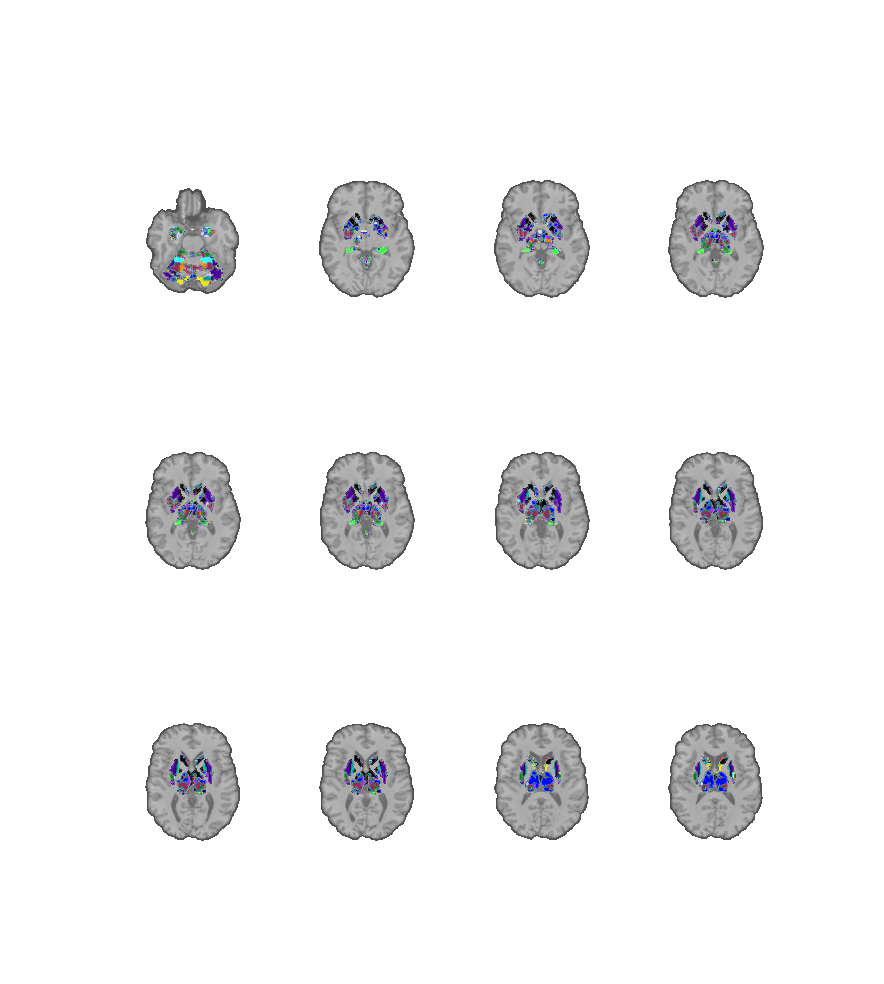

/data/nil-bluearc/GMT/RosCha/Tools/anaconda3/lib/python3.8/site-packages/nilearn/plotting/displays/_slicers.py:438: UserWarning: empty mask
  xmin_, xmax_, ymin_, ymax_, zmin_, zmax_ = get_mask_bounds(
/data/nil-bluearc/GMT/RosCha/Tools/anaconda3/lib/python3.8/site-packages/numpy/ma/core.py:2820: UserWarning: Warning: converting a masked element to nan.
  _data = np.array(data, dtype=dtype, copy=copy,


raw 0 ready
raw 1 ready
raw 2 ready


/tmp/ipykernel_2274/87443132.py:215: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(outdir,dpi=300)
/data/nil-bluearc/GMT/RosCha/Tools/anaconda3/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


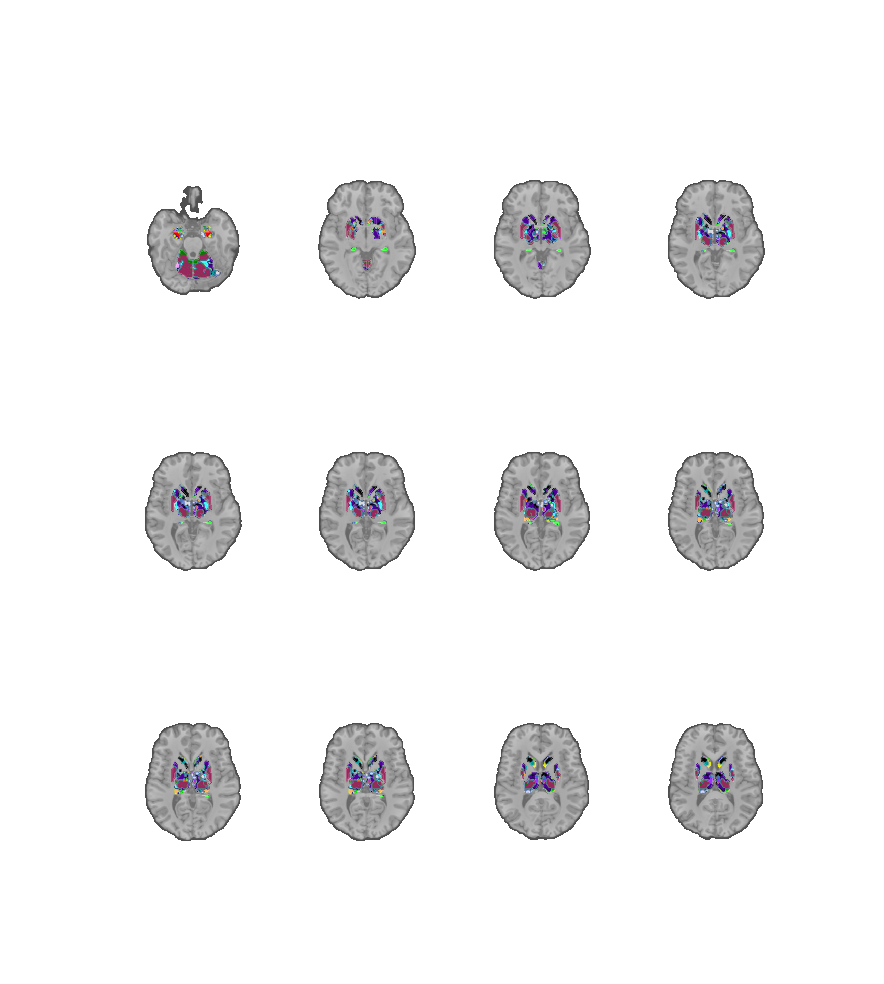

/data/nil-bluearc/GMT/RosCha/Tools/anaconda3/lib/python3.8/site-packages/nilearn/plotting/displays/_slicers.py:438: UserWarning: empty mask
  xmin_, xmax_, ymin_, ymax_, zmin_, zmax_ = get_mask_bounds(
/data/nil-bluearc/GMT/RosCha/Tools/anaconda3/lib/python3.8/site-packages/numpy/ma/core.py:2820: UserWarning: Warning: converting a masked element to nan.
  _data = np.array(data, dtype=dtype, copy=copy,


raw 0 ready
raw 1 ready
raw 2 ready


/tmp/ipykernel_2274/87443132.py:215: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(outdir,dpi=300)
/data/nil-bluearc/GMT/RosCha/Tools/anaconda3/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


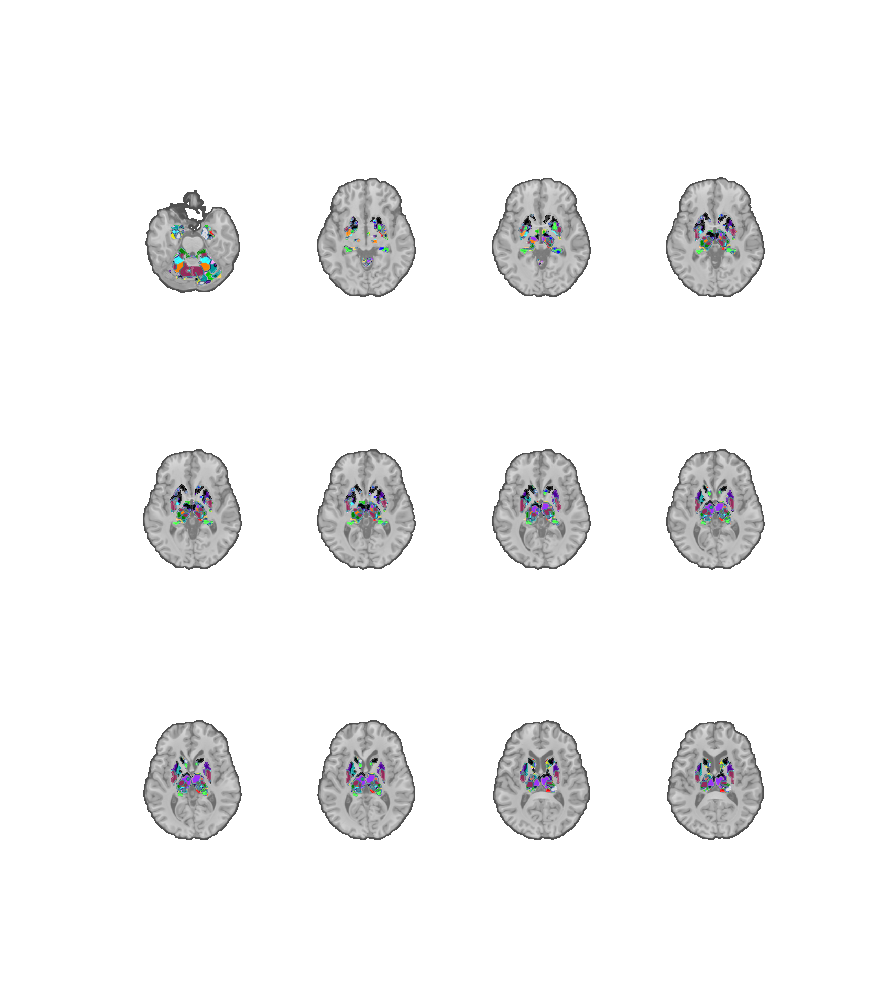

In [259]:
#surface /flat infomap new one
#HERE2310
ciftilocnet=[path+'/RosCha/Tools/nifti/'+sub[s]+'_rawassn_minsize10_regularized_recolored_wCMIas18.dscalar.nii' for s in range(len(sub))]
T1path=[path+'/RosCha/Structurals/cast/bet/'+s+'/T1_masked.nii.gz' for s in sub]

my_cmap = sns.color_palette(netspotcolorMOD).as_hex()
#x = np.arange(18).reshape(6, 3)
#ax = sns.heatmap(x, cmap=my_cmap)
for i in range(3):
    
    ciftiloc=ciftilocnet[i]
    
    

    color_listpos = np.array(netspotcolorMOD)#np.array(my_cmap)#[(mycmap(i)) for i in range(25,50)]#[::-1]

    limpos=np.arange(1,19)-0.1#np.concatenate([[lim[0]],[(lim[1]-lim[0])*(i+1)/24+lim[0] for i in range(24)]],0)
    #lim=[-limmaxall[e],0]
    #limneg=limpos

    
    plt.figure(figsize=[9,10])
    plotvolindivT1(ciftiloc,T1path[i],ortho='z',cut_coords=[-21,-4,-2,-1,0,1,2,3,4,5,8,9],Nraw=3,colorpos=color_listpos,savefig=path+'/RosCha/Results/figures/plasticitypulses/vol_'+sub[i]+'_infomap_T1.pdf',thresholdpos=limpos,Zannotate=False,smoothing=None)#colorneg=color_listneg,#thresholdneg=limneg,
    plt.show()
    
    

# quant pulse subcortical

In [20]:
def subcortquantBASIC_OLD(data,method='bin',threshold=None, absolute=True):
    #method can be binary or weight
    #read the cifti with the voxel
    if type(data)==str:
        raw=nibabel.load(data)
        data=copy.deepcopy(np.array(nibabel.load(data).dataobj))
    else:
        raw=data
        data=copy.deepcopy(np.array(data.dataobj))
    axes = [raw.header.get_axis(i) for i in range(raw.ndim)]
    # You'll want the brain model axis
    time_axis, brain_model_axis = axes
    listname=np.unique(brain_model_axis.name)
    
    
    #print(val)
    if method=='bin':
        if threshold!=None:
            if absolute:
                data[np.where(np.abs(data)<0)]=0
            else:
                data[np.where((data)<0)]=0
        data[np.where(data!=0)]=1
    print(data.shape)
    relsegment=np.zeros((len(listname),len(data)))
    relsegmentsd=np.zeros((len(listname),len(data)))
    relmap=np.zeros((len(listname),len(data)))
    for v2,l in enumerate(listname):
        for d,dataprov in enumerate(data):
            loc=np.where(brain_model_axis.name==l)[0]

            relsegment[v2][d]=np.mean(dataprov[loc])
            relsegmentsd[v2][d]=np.std(dataprov[loc])
            relmap[v2][d]=np.sum(dataprov[loc])/np.sum(dataprov)
        
    return listname,relsegment,relsegmentsd, relmap
                
def subcortquantBASIC(data,raw='',method='bin',threshold=None, absolute=True):
    #method can be binary or weight
    #read the cifti with the voxel
    if type(data)==str:
        raw=nibabel.load(data)
        data=copy.deepcopy(np.array(nibabel.load(data).dataobj[0]))
    axes = [raw.header.get_axis(i) for i in range(raw.ndim)]
    # You'll want the brain model axis
    time_axis, brain_model_axis = axes
    listname=np.unique(brain_model_axis.name)
    
    
    #print(val)
    if method=='bin':
        if threshold!=None:
            if absolute:
                data[np.where(np.abs(data)<0)]=0
            else:
                data[np.where((data)<0)]=0
        data[np.where(data!=0)]=1
    relsegment=np.zeros(len(listname))
    relstructure=np.zeros(len(listname))
    relmap=np.zeros(len(listname))
    for v2,l in enumerate(listname):
        loc=np.where(brain_model_axis.name==l)[0]
    
        relsegment[v2]=np.mean(data[loc])
        relstructure[v2]=np.sum(data[loc])/len(loc)
        relmap[v2]=np.sum(data[loc])/np.sum(data)
        
    return listname,relsegment,relstructure, relmap
                
         

In [21]:
def subcortquant_OLD(subatlaspath, data,method='bin',threshold=None, absolute=True):
    #method can be binary or weight
    #read the cifti with the voxel
    if type(data)==str:
        data=copy.deepcopy(np.array(nibabel.load(data).dataobj))
    else:
        data=copy.deepcopy(np.array(data.dataobj))
        
    subcortdata=nibabel.load(subatlaspath).dataobj[0]
    val=np.array([i for i in np.unique(subcortdata) if i!=0])
    #print(val)
    if method=='bin':
        if threshold!=None:
            if absolute:
                data[np.where(np.abs(data)<0)]=0
            else:
                data[np.where((data)<0)]=0
        data[np.where(data!=0)]=1
    relsegment=np.zeros((len(val),len(data)))
    relsegmentsd=np.zeros((len(val),len(data)))
    relmap=np.zeros((len(val),len(data)))
    for d,dataprov in enumerate(data):
        for v2,v in enumerate(val):
            relsegment[v2][d]=np.mean(dataprov[np.where(subcortdata==v)])
            relsegmentsd[v2][d]=np.std(dataprov[np.where(subcortdata==v)])
            relmap[v2][d]=np.sum(dataprov[np.where(subcortdata==v)])/np.sum(dataprov)
        
    return val,relsegment,relsegmentsd, relmap
                
            
        
def subcortquant(subatlaspath, data,method='bin',threshold=None, absolute=True):
    #method can be binary or weight
    #read the cifti with the voxel
    if type(data)==str:
        data=copy.deepcopy(np.array(nibabel.load(data).dataobj[0]))
    subcortdata=nibabel.load(subatlaspath).dataobj[0]
    val=np.array([i for i in np.unique(subcortdata) if i!=0 and len(np.where(subcortdata==i)[0])>5])
    #print(val)
    if method=='bin':
        if threshold!=None:
            if absolute:
                data[np.where(np.abs(data)<0)]=0
            else:
                data[np.where((data)<0)]=0
        data[np.where(data!=0)]=1
    relsegment=np.zeros(len(val))
    relstructure=np.zeros(len(val))
    relmap=np.zeros(len(val))
    for v2,v in enumerate(val):
        relsegment[v2]=np.mean(data[np.where(subcortdata==v)])
        relstructure[v2]=np.sum(data[np.where(subcortdata==v)])/np.sum(np.sign(subcortdata))
        relmap[v2]=np.sum(data[np.where(subcortdata==v)])/np.sum(data)
        
    return val,relsegment,relstructure, relmap
                
            
        
                

            

        

In [22]:
labelssegment=np.array([['8103','Left-AV','0','85','0','0'],['8104','Left-CeM','170','85','0','0'],['8105','Left-CL','0','170','0','0'],['8106','Left-CM','170','170','0','0'],['8108','Left-LD','170','255','0','0'],['8109','Left-LGN','0','0','127','0'],['8110','Left-LP','0','85','127','0'],['8111','Left-L-Sg','170','85','127','0'],['8112','Left-MDl','0','170','127','0'],['8113','Left-MDm','170','170','127','0'],['8115','Left-MGN','170','255','127','0'],['8116','Left-MV(Re)','0','0','255','0'],['8117','Left-Pc','170','0','255','0'],['8118','Left-Pf','0','85','255','0'],['8119','Left-Pt','170','85','255','0'],['8120','Left-PuA','0','170','255','0'],['8121','Left-PuI','170','170','255','0'],['8122','Left-PuL','0','255','255','0'],['8123','Left-PuM','170','255','255','0'],['8125','Left-R','255','0','0','0'],['8126','Left-VA','85','85','0','0'],['8127','Left-VAmc','255','85','0','0'],['8128','Left-VLa','85','170','0','0'],['8129','Left-VLp','255','170','0','0'],['8130','Left-VM','85','255','0','0'],['8133','Left-VPL','255','0','255','0'],['8203','Right-AV','0','85','0','0'],['8204','Right-CeM','170','85','0','0'],['8205','Right-CL','0','170','0','0'],['8206','Right-CM','170','170','0','0'],['8208','Right-LD','170','255','0','0'],['8209','Right-LGN','0','0','127','0'],['8210','Right-LP','0','85','127','0'],['8211','Right-L-Sg','170','85','127','0'],['8212','Right-MDl','0','170','127','0'],['8213','Right-MDm','170','170','127','0'],['8215','Right-MGN','170','255','127','0'],['8216','Right-MV(Re)','0','0','255','0'],['8217','Right-Pc','170','0','255','0'],['8218','Right-Pf','0','85','255','0'],['8219','Right-Pt','170','85','255','0'],['8220','Right-PuA','0','170','255','0'],['8221','Right-PuI','170','170','255','0'],['8222','Right-PuL','0','255','255','0'],['8223','Right-PuM','170','255','255','0'],['8225','Right-R','255','0','0','0'],['8226','Right-VA','85','85','0','0'],['8227','Right-VAmc','255','85','0','0'],['8228','Right-VLa','85','170','0','0'],['8229','Right-VLp','255','170','0','0'],['8230','Right-VM','85','255','0','0'],['8233','Right-VPL','255','0','255','0'],['226','HP_tail','170','170','255','0'],['227','Polymorphic-Layer','128','255','128','0'],['228','Intracellular-Space','204','153','204','0'],['231','HP_body','0','255','0','0'],['232','HP_head','255','0','0','0'],['7001','Lateral-nucleus','72','132','181','0'],['7002','Basolateral-nucleus','243','243','243','0'],['7003','Basal-nucleus','207','63','79','0'],['7004','Centromedial-nucleus','121','20','135','0'],['7005','Central-nucleus','197','60','248','0'],['7006','Medial-nucleus','2','149','2','0'],['7007','Cortical-nucleus','221','249','166','0'],['7008','Accessory-Basal-nucleus','232','146','35','0'],['7009','Corticoamygdaloid-transitio','20','60','120','0'],['7010','Anterior-amygdaloid-area-AAA','250','250','0','0'],['7011','Fusion-amygdala-HP-FAH','122','187','222','0'],['7012','Hippocampal-amygdala-transition-HATA','237','12','177','0'],['7013','Endopiriform-nucleus','10','49','255','0'],['7014','Lateral-nucleus-olfactory-tract','205','184','144','0'],['7015','Paralaminar-nucleus','45','205','165','0']])

# pulse peak timing

In [26]:
#tstats amplitude
#using the output of the python script


for e,s in enumerate(sub):
    hand=[np.where(HandDillan[e]==1)[0],np.where(HandDillan[e]==2)[0]]
    basefile=path+'/RosCha/Results/Tasks/rest/'+s+'/pulsemodel'
    for side2,side in enumerate(['L','R']):
        peak=basefile+'_'+side+'sm1_peakseries_during.dtseries.nii'
        raw=nibabel.load(peak)
        axes = [raw.header.get_axis(i) for i in range(raw.ndim)]
        # You'll want the brain model axis
        time_axis, brain_model_axis = axes
        peakdata=copy.deepcopy(np.array(raw.dataobj))
        bad=np.where((peakdata<=9)|(peakdata>=20))
        
        peak=basefile+'_'+side+'sm1_spreadseries_during.dtseries.nii'
        raw=nibabel.load(peak)
        axes = [raw.header.get_axis(i) for i in range(raw.ndim)]
        # You'll want the brain model axis
        time_axis, brain_model_axis = axes
        peakdata=copy.deepcopy(np.array(raw.dataobj))
        bad2=np.where(peakdata==4)
        
        
        peak=basefile+'_'+side+'sm1_amplitudeseries_during.dtseries.nii'
        raw=nibabel.load(peak)
        axes = [raw.header.get_axis(i) for i in range(raw.ndim)]
        # You'll want the brain model axis
        time_axis, brain_model_axis = axes
        time_axis2=nibabel.cifti2.cifti2_axes.SeriesAxis(1,1,1)
        peakdata=copy.deepcopy(np.array(raw.dataobj))
        peakdata[bad]=np.nan
        peakdata[bad2]=np.nan
        peakdata2=np.sum(~np.isnan(peakdata),0)
        peakdata2[np.where(np.isnan(peakdata2))]=0
        peakdata2[np.where(np.abs(peakdata2)==np.inf)]=0
        img=ci.Cifti2Image(np.array([peakdata2]), header=(time_axis2, brain_model_axis),
                                    nifti_header=raw.nifti_header)
        ci.save(img,peak.replace('.dtseries.nii','_N.dtseries.nii'))
        subprocess.call(['python',path+'/RosCha/Scripts/tasks/smooth_cifti.py','-sub',s,'-task','motor','-altpath',peak.replace('.dtseries.nii','_N.dtseries.nii')])
        #new mask is top20% of most reproducible pulses (=sucessful detection)
        peak=basefile+'_'+side+'sm1_amplitudeseries_during.dtseries.nii'
        peak2=peak.replace('.dtseries.nii','_N_smooth6.0.dtseries.nii')
        raw=nibabel.load(peak2)
        axes = [raw.header.get_axis(i) for i in range(raw.ndim)]
        # You'll want the brain model axis
        time_axis, brain_model_axis = axes
        time_axis2=nibabel.cifti2.cifti2_axes.SeriesAxis(1,1,1)
        peakdata3=copy.deepcopy(np.array(raw.dataobj))
        
        peakdata3[np.where(peakdata3<np.percentile(peakdata3,80))]=0
        peakdata3=np.sign(peakdata3)
        img=ci.Cifti2Image(np.array(peakdata3), header=(time_axis2, brain_model_axis),
                                    nifti_header=raw.nifti_header)
        ci.save(img,peak.replace('.dtseries.nii','_mask80.dtseries.nii'))
        #tstats
        peakdata=np.nanmean(peakdata,0)/((np.nanstd(peakdata,0)/np.sum(~np.isnan(peakdata),0)))#np.sqrt(len(peakdata)))#
        peakdata[np.where(np.isnan(peakdata))]=0
        peakdata[np.where(np.abs(peakdata)==np.inf)]=0
        img=ci.Cifti2Image(np.array([peakdata]), header=(time_axis2, brain_model_axis),
                                    nifti_header=raw.nifti_header)
        ci.save(img,peak.replace('.dtseries.nii','_tstats.dtseries.nii'))
        subprocess.call(['python',path+'/RosCha/Scripts/tasks/smooth_cifti.py','-sub',s,'-task','motor','-altpath',peak.replace('.dtseries.nii','_tstats.dtseries.nii')])
        #tstats masked
        peak=basefile+'_'+side+'sm1_amplitudeseries_during.dtseries.nii'
        
        raw=nibabel.load(peak.replace('.dtseries.nii','_tstats_smooth6.0.dtseries.nii'))
        peakdata=raw.get_fdata()
        img=ci.Cifti2Image(np.array(peakdata*peakdata3), header=(time_axis2, brain_model_axis),
                                    nifti_header=raw.nifti_header)
        ci.save(img,peak.replace('.dtseries.nii','_tstats_smooth6.0_masked80N.dtseries.nii'))
        
        
        #peak delay
        peak=basefile+'_'+side+'sm1_peakseries_during.dtseries.nii'
        raw=nibabel.load(peak)
        peakdata=copy.deepcopy(np.array(raw.dataobj))
        peakdata[bad]=np.nan
        peakdata[bad2]=np.nan
        peakdata=[p-np.nanmean(p[hand[side2]]) for p in peakdata]
        img=ci.Cifti2Image(np.array([np.nanmean(peakdata,0)]), header=(time_axis2, brain_model_axis),
                                    nifti_header=raw.nifti_header)
        ci.save(img,peak.replace('.dtseries.nii','_avg.dtseries.nii'))
        subprocess.call(['python',path+'/RosCha/Scripts/tasks/smooth_cifti.py','-sub',s,'-task','motor','-altpath',peak.replace('.dtseries.nii','_avg.dtseries.nii')])
        #peakdelay masked
        
        raw=nibabel.load(peak.replace('.dtseries.nii','_avg_smooth6.0.dtseries.nii'))
        peakdata=raw.get_fdata()
        peakdata[np.where(peakdata3==0)]=-10
        img=ci.Cifti2Image(np.array(peakdata), header=(time_axis2, brain_model_axis),
                                    nifti_header=raw.nifti_header)
        ci.save(img,peak.replace('.dtseries.nii','_avg_smooth6.0_masked80N.dtseries.nii'))
        
        

/tmp/ipykernel_2274/3843136666.py:58: RuntimeWarning: Mean of empty slice
  peakdata=np.nanmean(peakdata,0)/((np.nanstd(peakdata,0)/np.sum(~np.isnan(peakdata),0)))#np.sqrt(len(peakdata)))#
/data/nil-bluearc/GMT/RosCha/Tools/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_2274/3843136666.py:58: RuntimeWarning: divide by zero encountered in divide
  peakdata=np.nanmean(peakdata,0)/((np.nanstd(peakdata,0)/np.sum(~np.isnan(peakdata),0)))#np.sqrt(len(peakdata)))#
/tmp/ipykernel_2274/3843136666.py:82: RuntimeWarning: Mean of empty slice
  img=ci.Cifti2Image(np.array([np.nanmean(peakdata,0)]), header=(time_axis2, brain_model_axis),
/tmp/ipykernel_2274/3843136666.py:58: RuntimeWarning: Mean of empty slice
  peakdata=np.nanmean(peakdata,0)/((np.nanstd(peakdata,0)/np.sum(~np.isnan(peakdata),0)))#np.sqrt(len(peakdata)))#
/data/nil-bluearc/GMT/RosCha

In [28]:
#HERE0510
sideval=[1,-1]
#sideval=[[1,3,5],[2,4,6]]
#make figure cortical subcortical
for e,s in enumerate(sub):
    basefile=path+'/RosCha/Results/Tasks/rest/'+s+'/pulsemodel'
    for side2,side in enumerate(['L']):#,'R']):
        #decided to do mask on amplitude (cope) on peak timing std adjusted and peak spread std adjusted
        
        peak=basefile+'_'+side+'sm1_peakseries_during_avg_smooth6.0_masked80N.dtseries.nii'
        pathorig=peak#.replace('.dtseries.nii','_stdadjusted30topthresh.dtseries.nii')
        raw=nibabel.load(pathorig)
        data=raw.get_fdata()
        
        data[np.where(np.isnan(data))]=-10
        data+=10
        
        data[np.where(data>1.1+10)]=0
        
        
        axes = [raw.header.get_axis(i) for i in range(raw.ndim)]
        time_axis, brain_model_axis = axes
        #data=data[0]
        time_axis2=nibabel.cifti2.cifti2_axes.SeriesAxis(1,1,1)
        img=ci.Cifti2Image(np.array(data), header=(time_axis2, brain_model_axis),
                                nifti_header=raw.nifti_header)
        ci.save(img,pathorig.replace('.dtseries.nii','_cut1.1.dtseries.nii'))#os.path.dirname(pathorig)+'/temp.dtseries.nii')
        pathorig=pathorig.replace('.dtseries.nii','_cut1.1.dtseries.nii')

In [29]:
##HERE0510

for e,s in enumerate(sub):
    hand=[np.where(HandDillan[e]==1)[0],np.where(HandDillan[e]==2)[0]]
    basefile=path+'/RosCha/Results/Tasks/rest/'+s+'/pulsemodel'
    for side2,side in enumerate(['L']):
        peak=basefile+'_'+side+'sm1_peakseries_during_avg_smooth6.0_masked80N_cut1.1.dtseries.nii'
        raw=nibabel.load(peak)
        
        
        axes = [raw.header.get_axis(i) for i in range(raw.ndim)]
        time_axis, brain_model_axis = axes
        #data=data[0]
        time_axis2=nibabel.cifti2.cifti2_axes.SeriesAxis(1,1,1)
        mask=copy.deepcopy(np.array(raw.dataobj))
        peak=basefile+'_'+side+'sm1_amplitudeseries_during.dtseries.nii'
        peak=peak.replace('.dtseries.nii','_tstats_smooth6.0_masked80N.dtseries.nii')

        raw=nibabel.load(peak)
        peakdata=copy.deepcopy(np.array(raw.dataobj))
        peakdata[np.where(mask==0)]=0
        
        img=ci.Cifti2Image(np.array(peakdata), header=(time_axis2, brain_model_axis),
                                    nifti_header=raw.nifti_header)
        ci.save(img,peak.replace('.dtseries.nii','_timecut1.1.dtseries.nii'))
        

/data/nil-bluearc/GMT/RosCha/Results/Tasks/rest/SIC01/handseed_valselect.dtseries.nii
nothing on right hemi roi


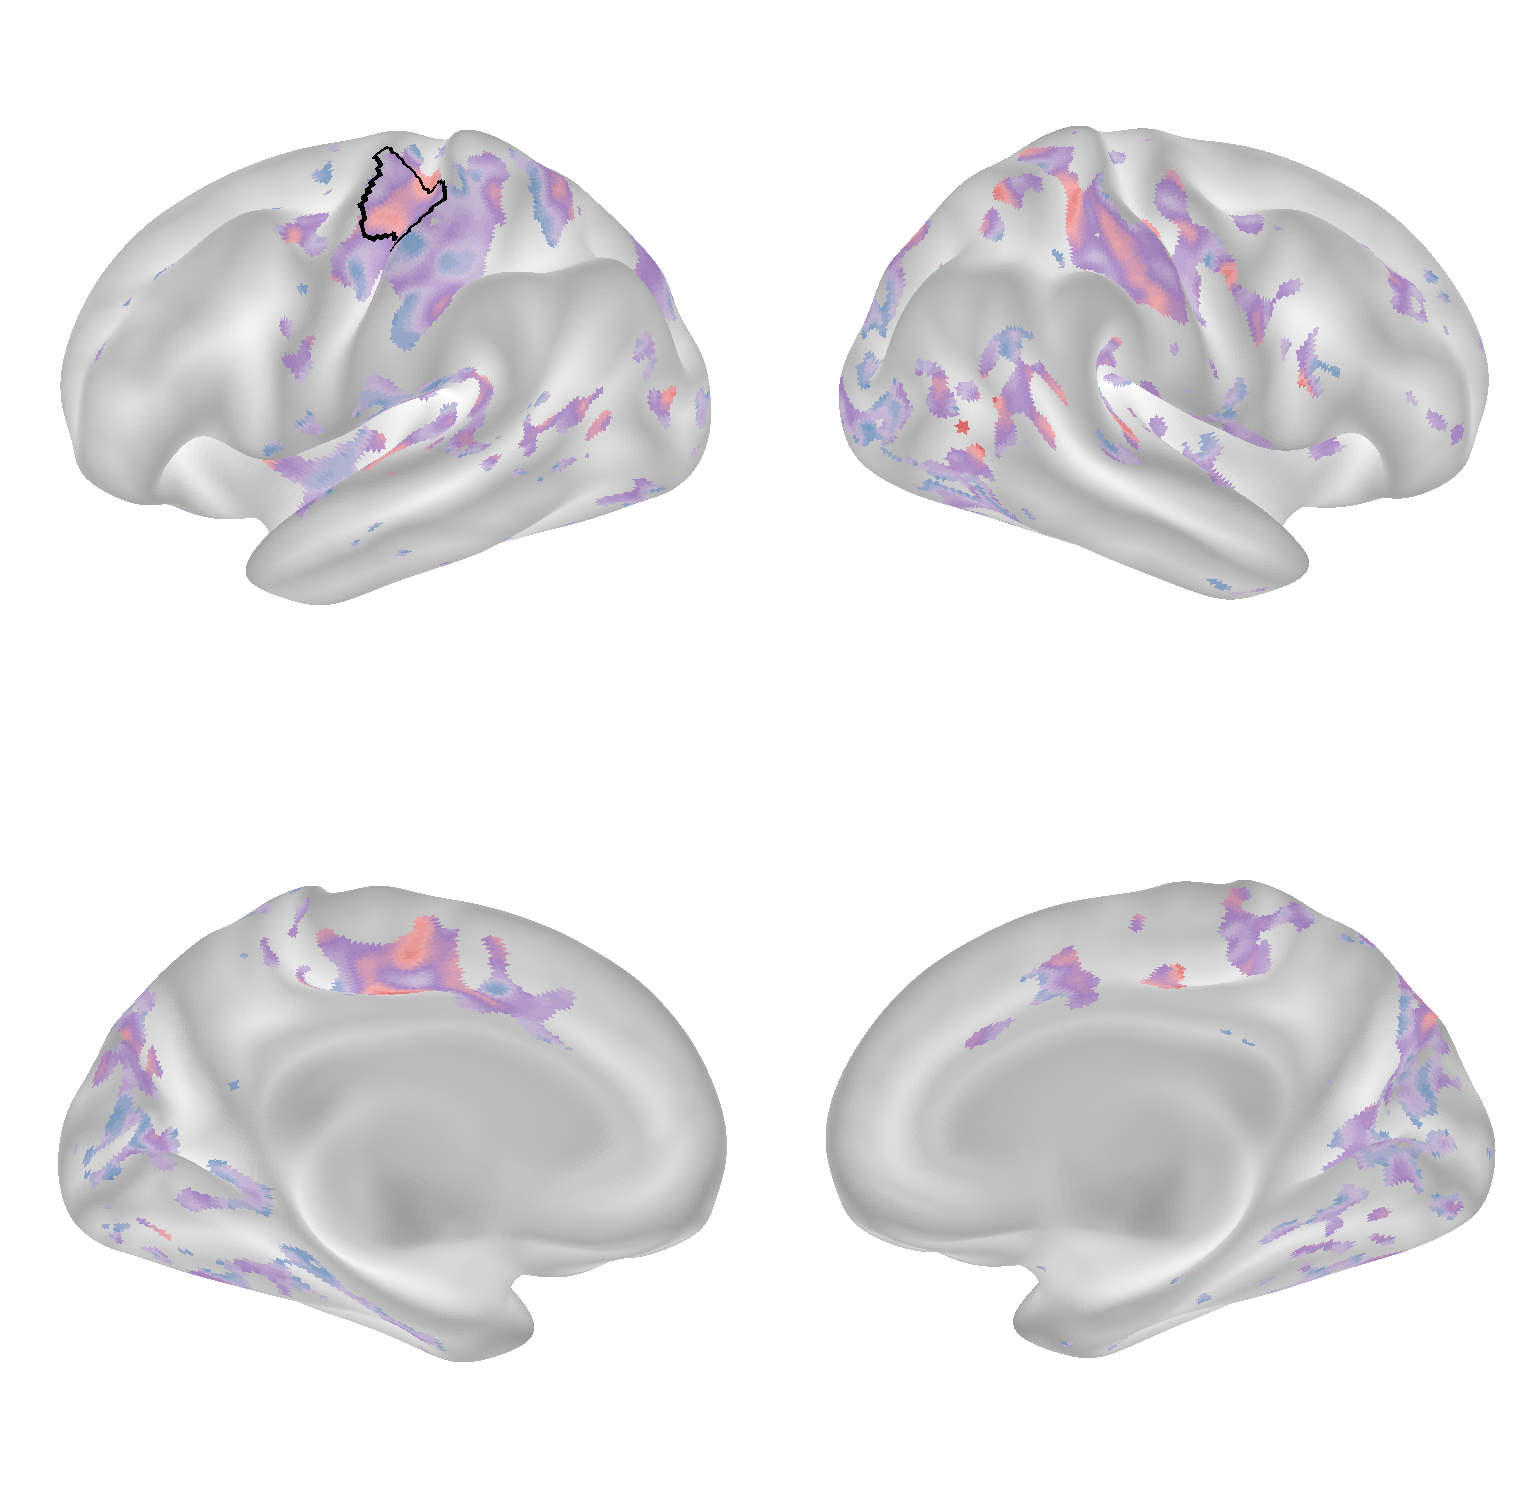

/tmp/ipykernel_25887/3779326731.py:86: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(savefig[:savefig.rfind('.')]+'-colorbar'+savefig[savefig.rfind('.'):])
/tmp/ipykernel_25887/3779326731.py:86: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(savefig[:savefig.rfind('.')]+'-colorbar'+savefig[savefig.rfind('.'):])
/data/nil-bluearc/GMT/RosCha/Tools/anaconda3/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


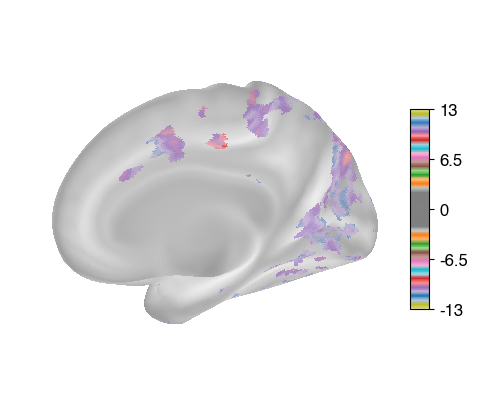

/data/nil-bluearc/GMT/RosCha/Tools/anaconda3/lib/python3.8/site-packages/nilearn/plotting/displays/_slicers.py:438: UserWarning: empty mask
  xmin_, xmax_, ymin_, ymax_, zmin_, zmax_ = get_mask_bounds(
/data/nil-bluearc/GMT/RosCha/Tools/anaconda3/lib/python3.8/site-packages/numpy/ma/core.py:2820: UserWarning: Warning: converting a masked element to nan.
  _data = np.array(data, dtype=dtype, copy=copy,
/data/nil-bluearc/GMT/RosCha/Tools/anaconda3/lib/python3.8/site-packages/matplotlib/contour.py:1454: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
/data/nil-bluearc/GMT/RosCha/Tools/anaconda3/lib/python3.8/site-packages/matplotlib/contour.py:1455: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())
/data/nil-bluearc/GMT/RosCha/Tools/anaconda3/lib/python3.8/site-packages/nilearn/plotting/displays/_slicers.py:433: UserWarning: empty mask
  xmin_, xmax_, ymin_, ymax_, zmin_, zmax_ = get_mask_bounds(


raw 0 ready
raw 1 ready
raw 2 ready


/tmp/ipykernel_25887/87443132.py:215: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(outdir,dpi=300)
/data/nil-bluearc/GMT/RosCha/Tools/anaconda3/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


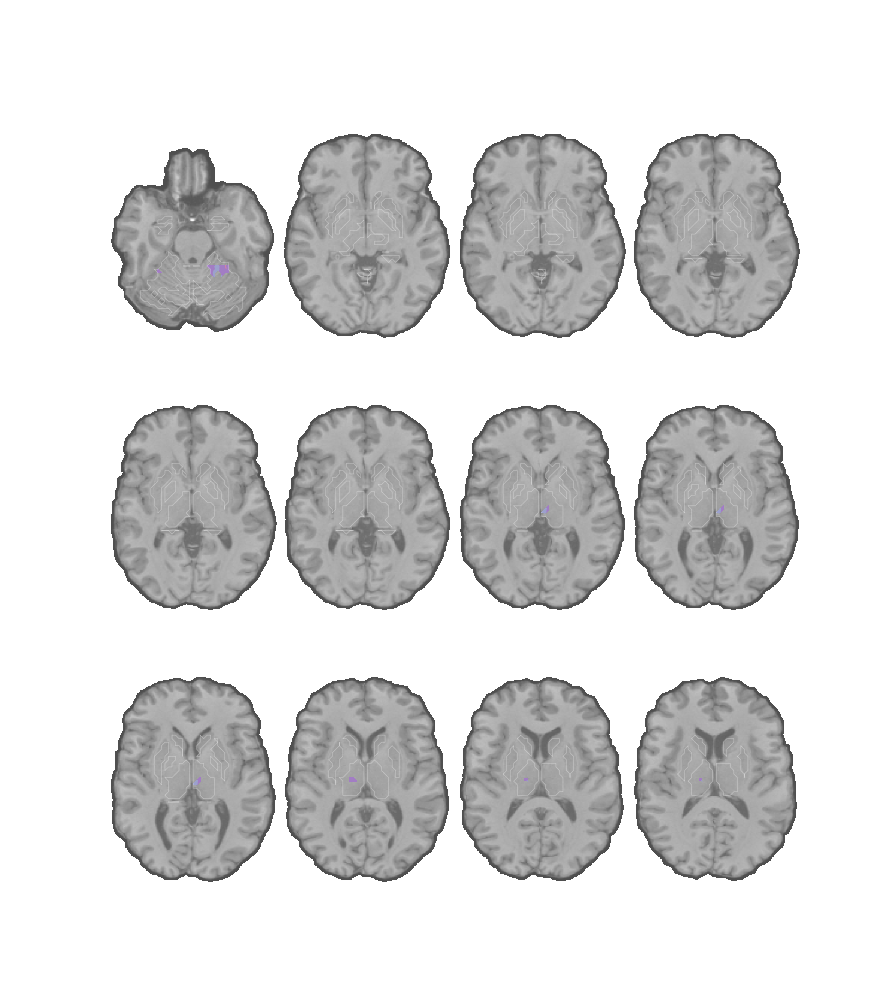

/data/nil-bluearc/GMT/RosCha/Results/Tasks/rest/SIC02/handseed_valselect.dtseries.nii
nothing on right hemi roi


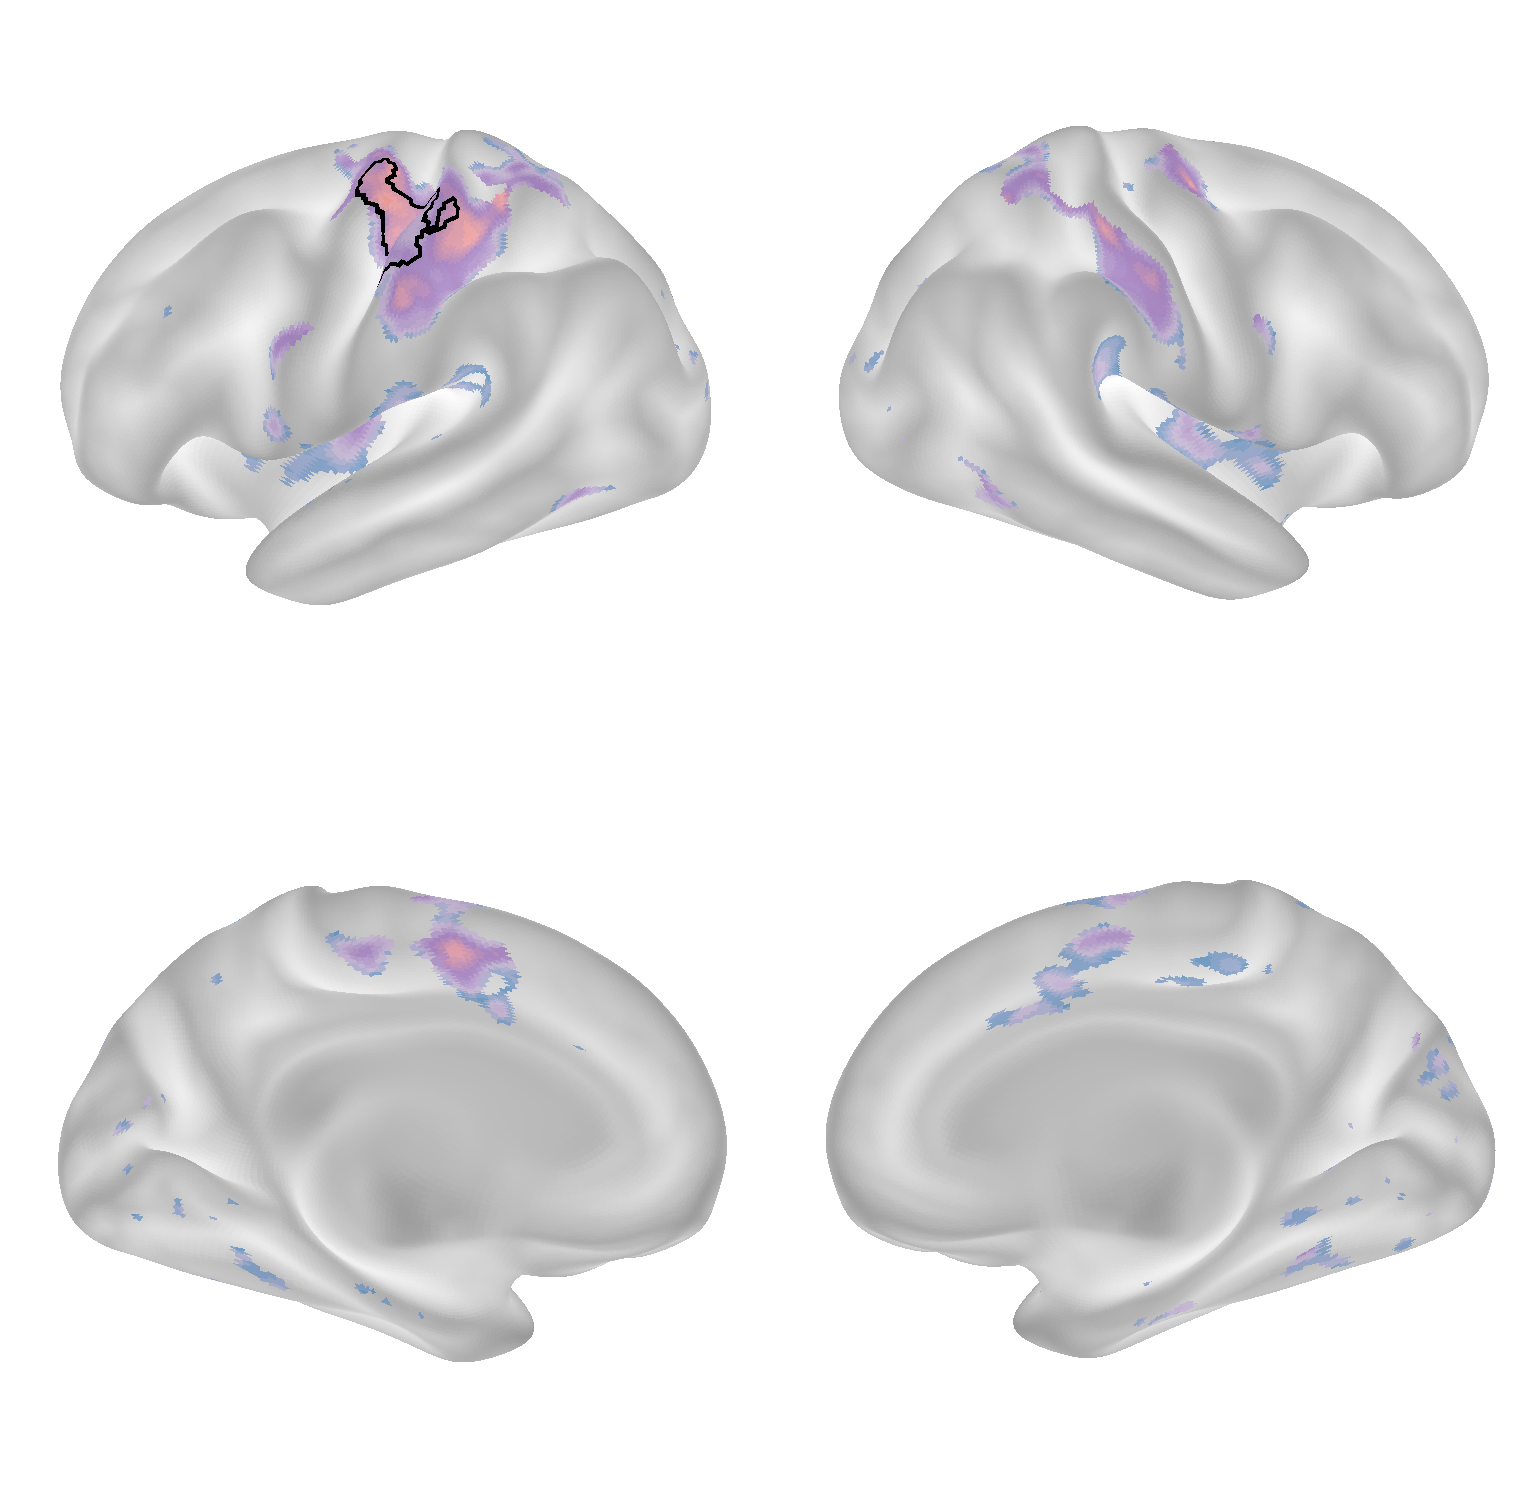

/tmp/ipykernel_25887/3779326731.py:86: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(savefig[:savefig.rfind('.')]+'-colorbar'+savefig[savefig.rfind('.'):])
/tmp/ipykernel_25887/3779326731.py:86: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(savefig[:savefig.rfind('.')]+'-colorbar'+savefig[savefig.rfind('.'):])
/data/nil-bluearc/GMT/RosCha/Tools/anaconda3/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


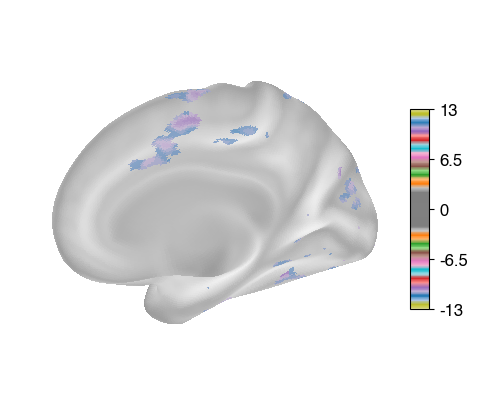

/data/nil-bluearc/GMT/RosCha/Tools/anaconda3/lib/python3.8/site-packages/nilearn/plotting/displays/_slicers.py:438: UserWarning: empty mask
  xmin_, xmax_, ymin_, ymax_, zmin_, zmax_ = get_mask_bounds(
/data/nil-bluearc/GMT/RosCha/Tools/anaconda3/lib/python3.8/site-packages/numpy/ma/core.py:2820: UserWarning: Warning: converting a masked element to nan.
  _data = np.array(data, dtype=dtype, copy=copy,
/data/nil-bluearc/GMT/RosCha/Tools/anaconda3/lib/python3.8/site-packages/nilearn/plotting/displays/_slicers.py:433: UserWarning: empty mask
  xmin_, xmax_, ymin_, ymax_, zmin_, zmax_ = get_mask_bounds(


raw 0 ready
raw 1 ready
raw 2 ready


/tmp/ipykernel_25887/87443132.py:215: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(outdir,dpi=300)
/data/nil-bluearc/GMT/RosCha/Tools/anaconda3/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


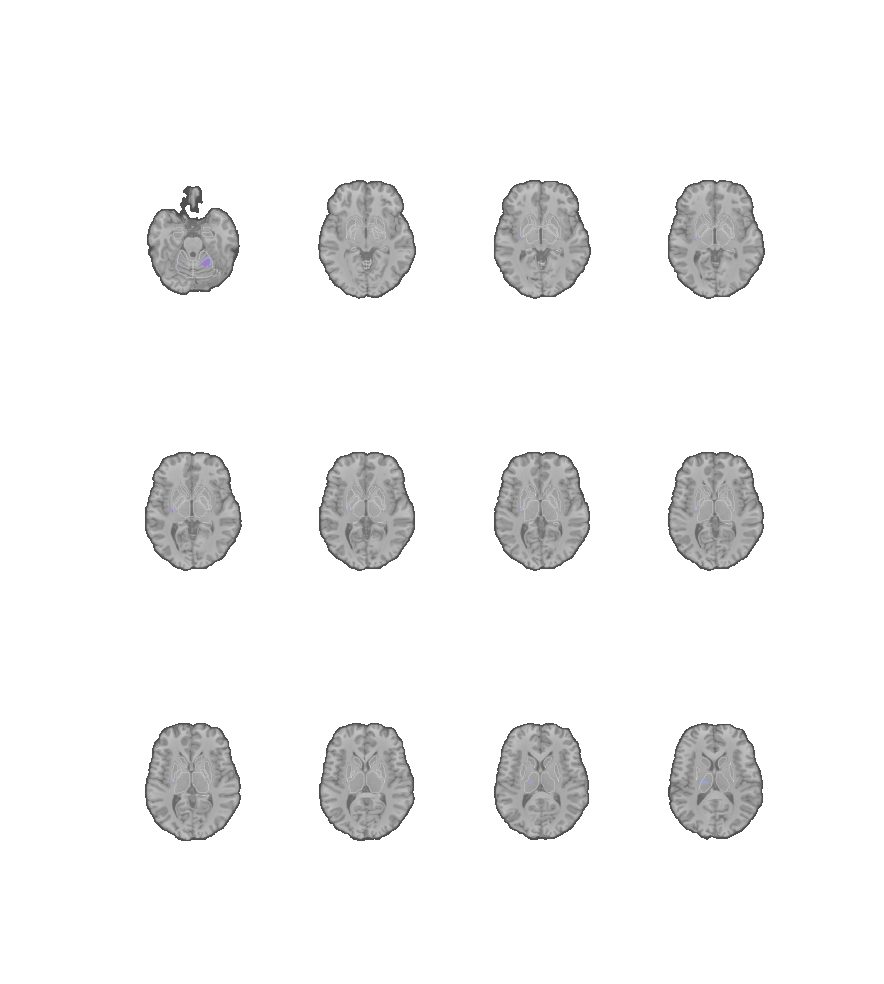

/data/nil-bluearc/GMT/RosCha/Results/Tasks/rest/SIC03/handseed_valselect.dtseries.nii
nothing on right hemi roi


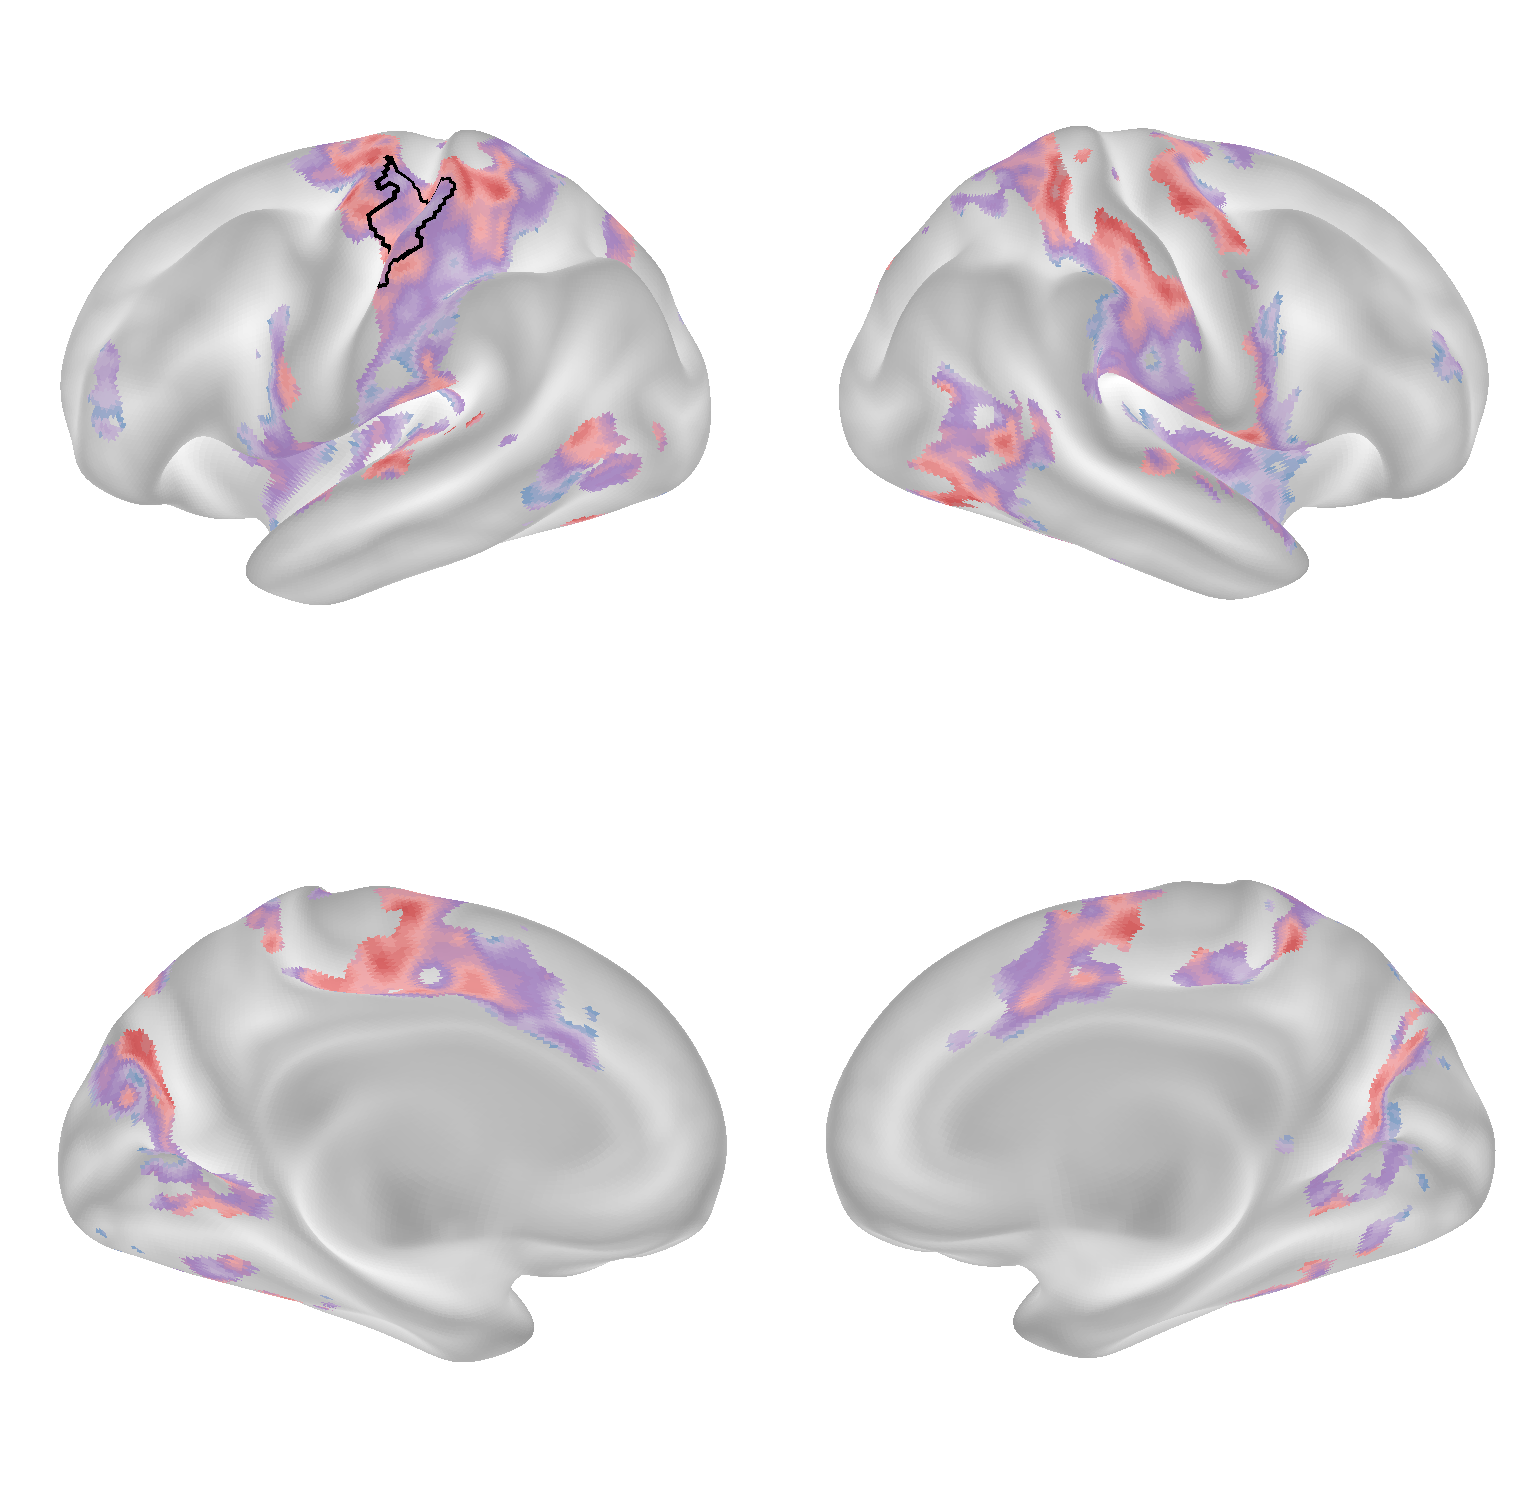

/tmp/ipykernel_25887/3779326731.py:86: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(savefig[:savefig.rfind('.')]+'-colorbar'+savefig[savefig.rfind('.'):])
/tmp/ipykernel_25887/3779326731.py:86: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(savefig[:savefig.rfind('.')]+'-colorbar'+savefig[savefig.rfind('.'):])
/data/nil-bluearc/GMT/RosCha/Tools/anaconda3/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


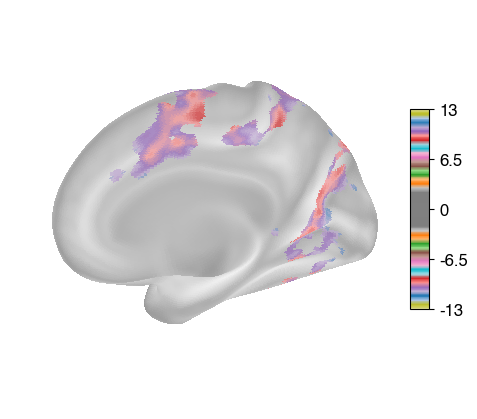

/data/nil-bluearc/GMT/RosCha/Tools/anaconda3/lib/python3.8/site-packages/nilearn/plotting/displays/_slicers.py:438: UserWarning: empty mask
  xmin_, xmax_, ymin_, ymax_, zmin_, zmax_ = get_mask_bounds(
/data/nil-bluearc/GMT/RosCha/Tools/anaconda3/lib/python3.8/site-packages/numpy/ma/core.py:2820: UserWarning: Warning: converting a masked element to nan.
  _data = np.array(data, dtype=dtype, copy=copy,
/data/nil-bluearc/GMT/RosCha/Tools/anaconda3/lib/python3.8/site-packages/matplotlib/contour.py:1454: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
/data/nil-bluearc/GMT/RosCha/Tools/anaconda3/lib/python3.8/site-packages/matplotlib/contour.py:1455: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())
/data/nil-bluearc/GMT/RosCha/Tools/anaconda3/lib/python3.8/site-packages/nilearn/plotting/displays/_slicers.py:433: UserWarning: empty mask
  xmin_, xmax_, ymin_, ymax_, zmin_, zmax_ = get_mask_bounds(


raw 0 ready
raw 1 ready
raw 2 ready


/tmp/ipykernel_25887/87443132.py:215: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(outdir,dpi=300)
/data/nil-bluearc/GMT/RosCha/Tools/anaconda3/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


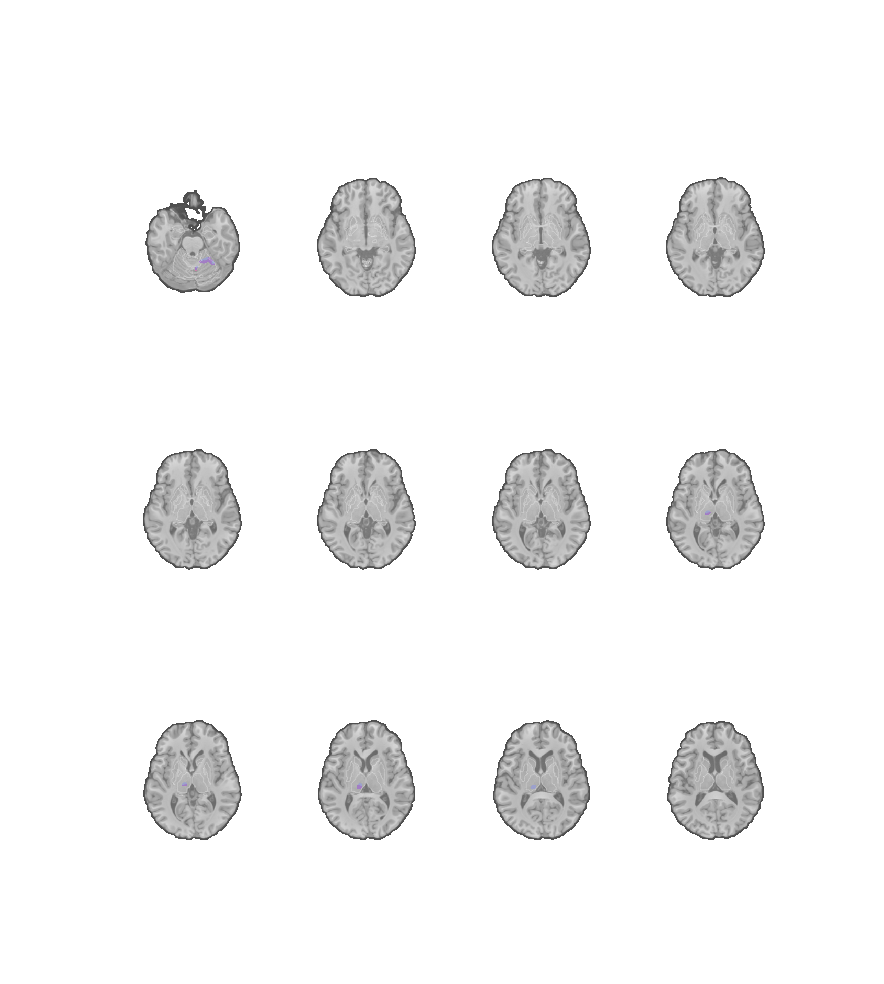

In [52]:
#####mask with time series tmask 
##HERE0510
#T1path=[path+'/croninj/SIC01/T1/SIC01_mpr_debias_avgT_111_t88.nii.gz',path+'/croninj/SIC02/T1/SIC02_mpr_debias_avgT_111_t88.nii.gz',path+'/Dillan/preproc_2018-07-03/SIC03/T1/SIC03_mpr_debias_avgT_111_t88.nii.gz']
T1path=[path+'/RosCha/Structurals/cast/bet/'+s+'/T1_masked.nii.gz' for s in sub]
sideval=[1,-1]
#sideval=[[1,3,5],[2,4,6]]
#make figure cortical subcortical
for e,s in enumerate(sub):
    basefile=path+'/RosCha/Results/Tasks/rest/'+s+'/pulsemodel'
    for side2,side in enumerate(['L']):#,'R']):
        #decided to do mask on amplitude (cope) on peak timing std adjusted and peak spread std adjusted
        
        peak=basefile+'_'+side+'sm1_peakseries_during_avg_smooth6.0_masked80N.dtseries.nii'
        pathorig=peak#.replace('.dtseries.nii','_stdadjusted30topthresh.dtseries.nii')
        raw=nibabel.load(pathorig)
        data=raw.get_fdata()
        
        
        #one color every 0.5, starting at -1 to 3

        #had the sm1 in border to define the "reference of peak"
        flatui=sns.color_palette('tab20')#[::-1]#np.concatenate([sns.color_palette('tab20')[14:16],sns.color_palette('tab20')[:14]],0)
        flatui=np.array(flatui)[[14,15,2,3,4,5,10,11,12,13,18,19,6,7,8,9,0,1,16,17]]
        white=[0,0,0]
        col1=flatui[0]
        mycmap=get_continuous_cmap(sns.color_palette(np.concatenate([flatui[::-1],[col1,col1,col1,white,col1,col1,col1],flatui],0)).as_hex())
        lim=3
            
        img_contour=path+'/RosCha/Results/Tasks/rest/'+s+'/handseed.dtseries.nii'#path+'/RosCha/Results/Tasks/rest/'+s+'/handSMA-MA-cer_seed.dtseries.nii'#
        contval=[sideval[side2]]#11,17,
        contcolor=[(1,1,1)]#,'k','w']#10,16,

        data[np.where(np.isnan(data))]=-10
        data+=10
        
        data[np.where(data>1.1+10)]=0
        
        
        axes = [raw.header.get_axis(i) for i in range(raw.ndim)]
        time_axis, brain_model_axis = axes
        #data=data[0]
        time_axis2=nibabel.cifti2.cifti2_axes.SeriesAxis(1,1,1)
        img=ci.Cifti2Image(np.array(data), header=(time_axis2, brain_model_axis),
                                nifti_header=raw.nifti_header)
        ci.save(img,pathorig.replace('.dtseries.nii','_cut1.1.dtseries.nii'))#os.path.dirname(pathorig)+'/temp.dtseries.nii')
        pathorig=pathorig.replace('.dtseries.nii','_cut1.1.dtseries.nii')##os.path.dirname(pathorig)+'/temp.dtseries.nii'

        #plotsurfwithroi(ciftiloc,roi,roival=sideval[side2],vmin=None,vmax=None,palette='',savefig='', threshold=None, cbar_vmin=None, cbar_vmax=None,background=True,avg='mean',rollZ=0,rollX=0,scale=0.8):
        plotsurfwithroi(pathorig,img_contour,roival=sideval[side2],vmin=-lim-10,vmax=lim+10,threshold=1,palette=mycmap,savefig=path+'/RosCha/Results/figures/plasticitypulses/surf_'+s+side+'SM1_pulsepeakmap_top20N.pdf',rollZ=20,scale=0.7,avg='median')
        
        mycmap=get_continuous_cmap(sns.color_palette(np.concatenate([flatui[::-1],[col1,col1,col1,white,col1,col1,col1],flatui],0)).as_hex(),N=50)

        color_listpos = [(mycmap(i)) for i in range(25,50)]#[::-1]
        color_listneg = [(mycmap(i)) for i in np.arange(24,-1,-1)]#[::-1]
        lim=[1,lim+10]#limmaxall[e]]
        limpos=np.concatenate([[lim[0]],[(lim[1]-lim[0])*(i+1)/24+lim[0] for i in range(24)]],0)
        #lim=[-limmaxall[e],0]
        limneg=limpos
        
        plt.figure(figsize=[9,10])
        plotvolindivT1(pathorig,T1path[e],ortho='z',cut_coords=[-21,-4,-2,-1,0,1,2,3,4,6,8,10],Nraw=3,colorpos=color_listpos,colorneg=color_listneg,savefig=path+'/RosCha/Results/figures/plasticitypulses/vol_'+s+side+'SM1_pulsepeakmap_top20NT1.pdf',thresholdneg=limneg,thresholdpos=limpos,Zannotate=False,smoothing=None)
        plt.show()
        
            

In [322]:
T1path=[path+'/RosCha/Structurals/cast/bet/SIC01/SIC01_mpr_debias_avgT_111_t88.nii.gz',path+'/croninj/SIC02/T1/SIC02_mpr_debias_avgT_111_t88.nii.gz',path+'/Dillan/preproc_2018-07-03/SIC03/T1/SIC03_mpr_debias_avgT_111_t88.nii.gz']
#remove  background
#os.symlink(path+'/croninj/SIC01/T1/SIC01_mpr_debias_avgT_111_t88.nii.gz',path+'/RosCha/Structurals/cast/bet/SIC01/SIC01_mpr_debias_avgT_111_t88.nii.gz')
for e,s in enumerate(sub):
    print(s)
    outpath=path+'/RosCha/Structurals/cast/bet/'+s+'/'
    subcorticalmask='/opt/fsl/data/standard/MNI152_T1_0.5mm.nii.gz'
    #downsample t1
    subprocess.call(['flirt','-in',T1path[e],'-ref',subcorticalmask,'-applyxfm','-usesqform','-out',outpath+'T1_0.5mm.nii.gz'])
    
    path=outpath+'T1_0.5mm.nii.gz'
    subprocess.call(['bet',path,outpath,'-m','-s'])
    
    raw=nibabel.load(path)
    mask=nibabel.load(outpath+'_mask.nii.gz')
    #mask=nilearn.image.smooth_img(mask,-1)
    mask=nilearn.image.smooth_img(mask,1)
    mask=mask.get_fdata()
    data=raw.get_fdata()
    data=data*mask
    nibabel.save(nibabel.Nifti1Image(data, affine=raw.affine),outpath+'T1_masked.nii.gz')

SIC01
SIC02
SIC03


In [47]:
####need to bring subcortical atlas to 222
dim=['333','222','222']
for s in range(3):
    n=0
    raw2=[]
    raw3=[]
    for l in labelssegmentTHOMAS:
        print(l)
        net=path+'/RosCha/Structurals/cast/THOMAS/'+sub[s]+'/'+l+'.nii.gz'
        raw3+=[nibabel.load(net).get_fdata()]
        #subcorticalmask=path+'/Dillan/preproc_2018-07-03/'+sub[s]+'/subcortical_mask_222/subcortical_mask_LR_222.nii'
        subcorticaldir=path+'/Dillan/preproc_2018-07-03/'+sub[s]+'/subcortical_mask_222'
        #if s==0:
        subcorticalmask=path+'/Dillan/preproc_2018-07-03/'+sub[s]+'/subcortical_mask_222/subcortical_mask_LR_'+dim[s]+'.nii'
        if s==0:
            subcorticalmask=path+'/Dillan/preproc_2018-07-03/'+sub[s]+'/subcortical_mask/subcortical_mask_LR_'+dim[s]+'.nii'


        #reshape
        subprocess.call(['flirt','-in',net,'-ref',subcorticalmask,'-applyxfm','-usesqform','-out',net.replace('.nii.gz','_castshape.nii.gz')])
        #>0.5 binarize
        subprocess.call(['fslmaths',net.replace('.nii.gz','_castshape.nii.gz'),'-thr','0.2','-bin',net.replace('.nii.gz','_castshape_BIN.nii.gz')])
        #load
        raw2+=[nibabel.load(net.replace('.nii.gz','_castshape.nii.gz')).get_fdata()]
    raw2_3d=np.argmax(raw2,0)+1
    raw2_3d[np.where(np.sum(raw2,0)==0)]=0
    #save volume
    nibabel.save(nibabel.Nifti1Image(raw2_3d, affine=nibabel.load(net.replace('.nii.gz','_castshape.nii.gz')).affine),os.path.dirname(os.path.dirname(net))+'thomasfull_castshape_'+dim[s]+'.nii.gz')
    raw3_3d=np.argmax(raw3,0)+1
    raw3_3d[np.where(np.sum(raw3,0)==0)]=0
    #save volume
    nibabel.save(nibabel.Nifti1Image(raw3_3d, affine=nibabel.load(net).affine),os.path.dirname(os.path.dirname(net))+'thomasfull_T1.nii.gz')
    

left/2-AV
left/4-VA
left/5-VLa
left/6_VLPv
left/6_VLPd
left/7-VPL
left/8-Pul
left/9-LGN
left/10-MGN
left/11-CM
left/12-MD-Pf
left/13-Hb
left/14-MTT
right/2-AV
right/4-VA
right/5-VLa
right/6_VLPv
right/6_VLPd
right/7-VPL
right/8-Pul
right/9-LGN
right/10-MGN
right/11-CM
right/12-MD-Pf
right/13-Hb
right/14-MTT
left/2-AV
left/4-VA
left/5-VLa
left/6_VLPv
left/6_VLPd
left/7-VPL
left/8-Pul
left/9-LGN
left/10-MGN
left/11-CM
left/12-MD-Pf
left/13-Hb
left/14-MTT
right/2-AV
right/4-VA
right/5-VLa
right/6_VLPv
right/6_VLPd
right/7-VPL
right/8-Pul
right/9-LGN
right/10-MGN
right/11-CM
right/12-MD-Pf
right/13-Hb
right/14-MTT
left/2-AV
left/4-VA
left/5-VLa
left/6_VLPv
left/6_VLPd
left/7-VPL
left/8-Pul
left/9-LGN
left/10-MGN
left/11-CM
left/12-MD-Pf
left/13-Hb
left/14-MTT
right/2-AV
right/4-VA
right/5-VLa
right/6_VLPv
right/6_VLPd
right/7-VPL
right/8-Pul
right/9-LGN
right/10-MGN
right/11-CM
right/12-MD-Pf
right/13-Hb
right/14-MTT


In [82]:
#bring thala atlas to cifti
dim=['333','222','222']

for s,net in enumerate(ciftilocnet):
    subatlaspath=path+'/RosCha/Structurals/cast/THOMAS/'+sub[s]+'thomasfull_castshape_'+dim[s]+'.nii.gz'
    
    subcorticaldir=path+'/Dillan/preproc_2018-07-03/'+sub[s]+'/subcortical_mask_222'
    #if s==0:
    subcorticalmask=path+'/Dillan/preproc_2018-07-03/'+sub[s]+'/subcortical_mask_222/subcortical_mask_LR_'+dim[s]+'.nii'
    if s==0:
        subcorticalmask=path+'/Dillan/preproc_2018-07-03/'+sub[s]+'/subcortical_mask/subcortical_mask_LR_'+dim[s]+'.nii'


    #separate
    tag3='dscalar'
    
    subprocess.call(['wb_command','-cifti-separate-all',net,'-volume',net.replace('.'+tag3+'.nii','_vol.nii.gz'),'-left',net.replace('.'+tag3+'.nii','_L.func.gii'),'-right',net.replace('.'+tag3+'.nii','_R.func.gii')])
    print(net.replace('.'+tag3+'.nii','_vol.nii.gz'))
    
    prov=nibabel.load(net.replace('.'+tag3+'.nii','_L.func.gii'))
    provdata=prov.darrays[0].data
    provdata=provdata*0
    data_lh = nibabel.gifti.gifti.GiftiImage()
    data_lh.add_gifti_data_array(nibabel.gifti.gifti.GiftiDataArray(data=provdata))
    nibabel.save(data_lh,net.replace('.'+tag3+'.nii','_L.func.gii'))
    
    prov=nibabel.load(net.replace('.'+tag3+'.nii','_R.func.gii'))
    provdata=prov.darrays[0].data
    provdata=provdata*0
    data_lh = nibabel.gifti.gifti.GiftiImage()
    data_lh.add_gifti_data_array(nibabel.gifti.gifti.GiftiDataArray(data=provdata))
    nibabel.save(data_lh,net.replace('.'+tag3+'.nii','_R.func.gii'))
    
    Subcortical=subatlaspath
    leftfile=net.replace('.'+tag3+'.nii','_L.func.gii')
    rightfile=net.replace('.'+tag3+'.nii','_R.func.gii')
    #combine to cifti
    subprocess.call(['wb_command','-cifti-create-dense-timeseries',subatlaspath.replace('.nii.gz','.dtseries.nii'),'-volume',Subcortical,subcorticalmask,'-left-metric',leftfile,'-roi-left',subcorticaldir+'/L.atlasroi.32k_fs_LR.shape.gii','-right-metric',rightfile,'-roi-right',subcorticaldir+'/R.atlasroi.32k_fs_LR.shape.gii'])
    
    subprocess.call(['rm',net.replace('.'+tag3+'.nii','_vol.nii.gz'),net.replace('.'+tag3+'.nii','_L.func.gii'),net.replace('.'+tag3+'.nii','_R.func.gii')])

/data/nil-bluearc/GMT/RosCha/Tools/nifti/SIC01_rawassn_minsize10_regularized_recolored_wCMIas18_vol.nii.gz
/data/nil-bluearc/GMT/RosCha/Tools/nifti/SIC02_rawassn_minsize10_regularized_recolored_wCMIas18_vol.nii.gz
/data/nil-bluearc/GMT/RosCha/Tools/nifti/SIC03_rawassn_minsize10_regularized_recolored_wCMIas18_vol.nii.gz


32492

# visu and color palette function

In [13]:
def mycolorscaleDARK(name, show=False, limpos=0,limneg=0, threshold=0,Ncolor=0,reverse=0):
    black=np.array([0,0,0])
    white=np.array([1,1,1])
    
    if name=='grad':
        pos=sns.color_palette("hls", 4)
        neg=sns.color_palette("hls", 4)[::-1]
        zero=[black]
    if name=='salsea':
        pos=sns.color_palette("coolwarm")[::-1][:3]#OrRd")
        pos=np.concatenate([[(pos[0][0]/2.,0,0)],pos])[::-1]
        neg=sns.color_palette('PuBu')#dark_palette("#69d")[1:]
        pos=[(min([neg[x][2]+0.1,1]),max([neg[x][0]-0.1,0]),neg[x][1]-0.2) for x in range(len(neg))][::-1]
        print(pos)
        zero=[black]
        
        
    if name=='greeple':
        #pos=sns.cubehelix_palette(reverse=True, dark=0.1,light=.95)[1:][::-1]
        neg=sns.color_palette('PuBu')[::-1]#dark_palette("#69d")[1:]#trick
        pos=[(neg[x][2],neg[x][0],neg[x][1]) for x in range(len(neg))]
        neg=sns.cubehelix_palette(start=2, rot=0, dark=0.1, light=.85,reverse=True)[::-1]#[1:]
        zero=[black]
    if name=="matket":
        neg=sns.color_palette("mako")[1:][::-1]#mako#np.concatenate([[np.array(sns.color_palette("mako")[1:][0])/2.],sns.color_palette("mako")[1:]],0)
        pos=sns.color_palette("inferno")[1:]#plasma#rocket#np.concatenate([sns.color_palette("rocket")[1:][::-1],[np.array(sns.color_palette("rocket")[1:][0])/2.]],0)
        zero=[black]
        
    if limpos!=0 and threshold!=0:
        if int(len(pos)*threshold/(limpos-threshold))!=0:
        
            zero=np.concatenate([zero,[black for i in range(int(len(pos)*threshold/(limpos-threshold)))]],0)
        
    if limneg!=0 and threshold!=0:
        if int(len(pos)*threshold/(limpos-threshold))!=0:
            zero=np.concatenate([[black for i in range(int(len(neg)*threshold/(np.abs(limneg)-threshold)))],zero],0)
    
        
        
    flatui=np.concatenate([neg,zero,pos],0)
    if reverse:
        flatui=flatui[::-1]
    if Ncolor==0:
        my_cmap = get_continuous_cmap(sns.color_palette(flatui).as_hex())#ListedColormap
    else:
        my_cmap = get_continuous_cmap(sns.color_palette(flatui).as_hex(),N=Ncolor)#ListedColormap
        
    if show:
        x = np.arange(25).reshape(5, 5)
        ax = sns.heatmap(x, cmap=my_cmap)
    return my_cmap


In [279]:
sns.color_palette('PuBu')

[(0.9112802768166091, 0.894717416378316, 0.9429296424452134),
 (0.7678892733564013, 0.7968473663975394, 0.889442522106882),
 (0.5687043444828912, 0.7082660515186466, 0.8390772779700115),
 (0.31378700499807766, 0.6058439061899269, 0.7776239907727797),
 (0.07537101114955785, 0.4756324490580546, 0.7084044598231449),
 (0.01619377162629758, 0.3641061130334487, 0.5707035755478662)]

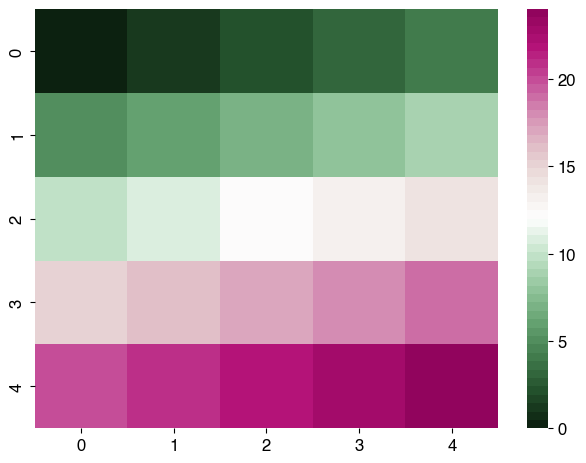

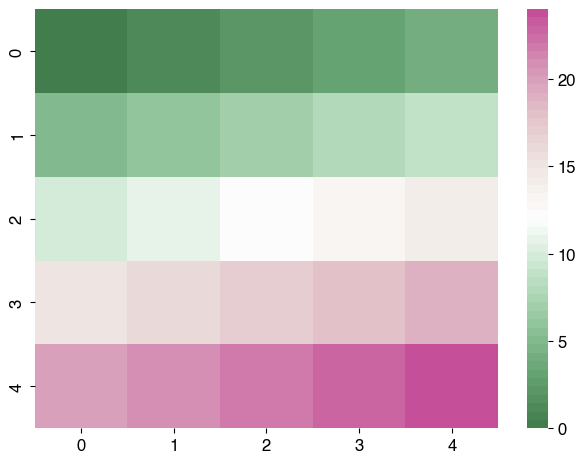

[(1, 0.8112802768166091, 0.6947174163783161), (0.989442522106882, 0.6678892733564014, 0.5968473663975393), (0.9390772779700115, 0.4687043444828912, 0.5082660515186466), (0.8776239907727796, 0.21378700499807765, 0.4058439061899269), (0.8084044598231449, 0, 0.27563244905805456), (0.6707035755478662, 0, 0.1641061130334487)]


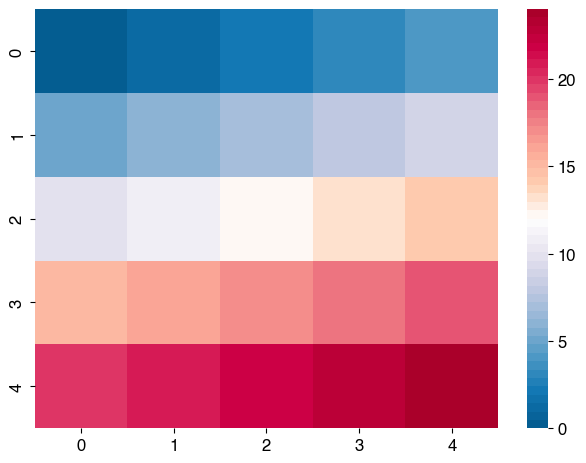

[(1, 0.8112802768166091, 0.6947174163783161), (0.989442522106882, 0.6678892733564014, 0.5968473663975393), (0.9390772779700115, 0.4687043444828912, 0.5082660515186466), (0.8776239907727796, 0.21378700499807765, 0.4058439061899269), (0.8084044598231449, 0, 0.27563244905805456), (0.6707035755478662, 0, 0.1641061130334487)]


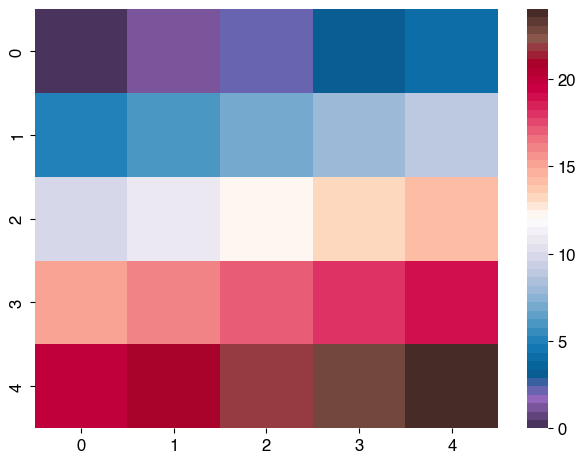

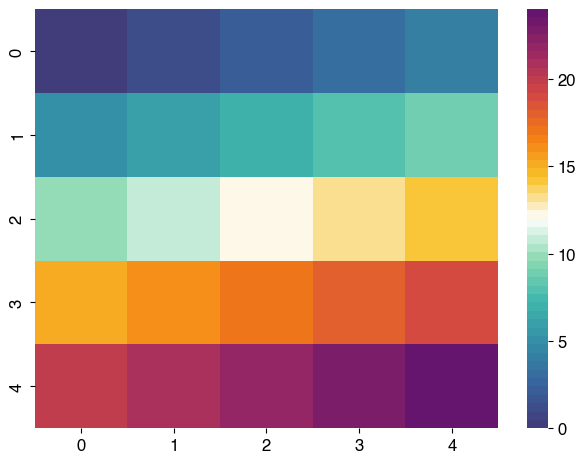

In [66]:
black=np.array([0,0,0])
white=np.array([1,1,1])
# construct cmap
lim=10
thresh=0
x = np.arange(25).reshape(5, 5)
ax = sns.heatmap(x, cmap=mycolorscale("greeple",limpos=lim,limneg=-lim,threshold=thresh,Ncolor=50))
plt.show()
ax = sns.heatmap(x, cmap=mycolorscale("greeple2",limpos=lim,limneg=-lim,threshold=thresh,Ncolor=50))
plt.show()
ax = sns.heatmap(x, cmap=mycolorscale("salsea",limpos=lim,limneg=-lim,threshold=thresh,Ncolor=50))
plt.show()
ax = sns.heatmap(x, cmap=mycolorscale("salsea2",limpos=lim,limneg=-lim,threshold=thresh,Ncolor=50))
plt.show()
ax = sns.heatmap(x, cmap=mycolorscale("matket",limpos=lim,limneg=-lim,threshold=thresh,Ncolor=50))
plt.show()

In [62]:
sns.color_palette('tab20')

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (0.6823529411764706, 0.7803921568627451, 0.9098039215686274),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (1.0, 0.7333333333333333, 0.47058823529411764),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.596078431372549, 0.8745098039215686, 0.5411764705882353),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (1.0, 0.596078431372549, 0.5882352941176471),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.7725490196078432, 0.6901960784313725, 0.8352941176470589),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.7686274509803922, 0.611764705882353, 0.5803921568627451),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.9686274509803922, 0.7137254901960784, 0.8235294117647058),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7803921568627451, 0.7803921568627451, 0.7803921568627451),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.8588235294117647, 0.8588235294117647, 0.5529411764705883),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529),
 (0.6196078431372549, 0.8549019607843137, 0.8980392156862745)]

In [36]:
def mycolorscale(name, show=False, limpos=0,limneg=0, threshold=0,Ncolor=0,rev=False):
    black=np.array([0,0,0])
    white=np.array([1,1,1])
    
    if name=='grad':
        pos=sns.color_palette("hls", 4)
        neg=sns.color_palette("hls", 4)[::-1]
        zero=[white]
    if name=='salsea':
        #pos=sns.color_palette("coolwarm")[::-1][:3]#OrRd")
        #pos=np.concatenate([[(pos[0][0]/2.,0,0)],pos])[::-1]
        neg=sns.color_palette('PuBu')[::-1]#dark_palette("#69d")[1:]
        pos=[(min([neg[x][2]+0.1,1]),max([neg[x][0]-0.1,0]),neg[x][1]-0.2) for x in range(len(neg))][::-1]
        print(pos)
        zero=[white]
    if name=='salsea2':
        #pos=sns.color_palette("coolwarm")[::-1][:3]#OrRd")
        #pos=np.concatenate([[(pos[0][0]/2.,0,0)],pos])[::-1]
        neg=sns.color_palette('PuBu')[::-1]#dark_palette("#69d")[1:]
        pos=[(min([neg[x][2]+0.1,1]),max([neg[x][0]-0.1,0]),neg[x][1]-0.2) for x in range(len(neg))][::-1]
        print(pos)
        neg=np.concatenate([[[i/2. for i in sns.color_palette('tab20')[8]],sns.color_palette('tab20')[8]],neg],0)
        pos=np.concatenate([pos,[sns.color_palette('tab20')[10],[i/2. for i in sns.color_palette('tab20')[10]]]],0)
        zero=[white]
        
    if name=='greeple':
        #pos=sns.cubehelix_palette(reverse=True, dark=0.1,light=.95)[1:][::-1]
        neg=sns.color_palette('PuBu')[::-1]#dark_palette("#69d")[1:]#trick
        pos=[(neg[x][2],neg[x][0],neg[x][1]) for x in range(len(neg))][::-1]
        neg=sns.cubehelix_palette(start=2, rot=0, dark=0.1, light=.85,reverse=True)#[1:]
        zero=[white]
    if name=='greeple2':
        #pos=sns.cubehelix_palette(reverse=True, dark=0.1,light=.95)[1:][::-1]
        neg=sns.color_palette('PuBu')[::-1]#dark_palette("#69d")[1:]#trick
        pos=[(neg[x][2],neg[x][0],neg[x][1]) for x in range(len(neg))][2:][::-1]
        neg=sns.cubehelix_palette(start=2, rot=0, dark=0.1, light=.85,reverse=True)[2:]
        zero=[white]
    if name=="matket":
        neg=sns.color_palette("mako")[1:]#mako#np.concatenate([[np.array(sns.color_palette("mako")[1:][0])/2.],sns.color_palette("mako")[1:]],0)
        pos=sns.color_palette("inferno")[1:][::-1]#plasma#rocket#np.concatenate([sns.color_palette("rocket")[1:][::-1],[np.array(sns.color_palette("rocket")[1:][0])/2.]],0)
        zero=[white]
        
    if limpos!=0 and threshold!=0:
        if int(len(pos)*threshold/(limpos-threshold))!=0:
        
            zero=np.concatenate([zero,[white for i in range(int(len(pos)*threshold/(limpos-threshold)))]],0)
        
    if limneg!=0 and threshold!=0:
        if int(len(pos)*threshold/(limpos-threshold))!=0:
            zero=np.concatenate([[white for i in range(int(len(neg)*threshold/(np.abs(limneg)-threshold)))],zero],0)
    
        
        
    flatui=np.concatenate([neg,zero,pos],0)
    if rev==True:
        flatui=flatui[::-1]
    if Ncolor==0:
        my_cmap = get_continuous_cmap(sns.color_palette(flatui).as_hex())#ListedColormap
    else:
        my_cmap = get_continuous_cmap(sns.color_palette(flatui).as_hex(),N=Ncolor)#ListedColormap
        
    if show:
        x = np.arange(25).reshape(5, 5)
        ax = sns.heatmap(x, cmap=my_cmap)
    return my_cmap


In [254]:
def plotvolindivT1(ciftiloc,T1='',ortho='z',cut_coords='',Nraw=1,colorpos='r',colorneg='b',savefig='', thresholdneg=False,thresholdpos=False,Zannotate='Both',smoothing=0, dilation=0,dilbin=0):
    if ciftiloc[len(ciftiloc)-len('.nii.gz'):]=='.nii.gz':
        niftipath=ciftiloc
        do=0
    else:
        do=1
        if ciftiloc[len(ciftiloc)-len('dtseries.nii'):]=='dtseries.nii':
            tag='dtseries'
        else:
            tag='dscalar'
        raw=nibabel.load(ciftiloc)
        data=np.zeros(len(raw.dataobj[0]))
        axes = [raw.header.get_axis(i) for i in range(raw.ndim)]
        # You'll want the brain model axis
        time_axis, brain_model_axis = axes
        #get the structure and make a temp file with level
        keepstructure=[]
        for e,b in enumerate(brain_model_axis.name):
            if b.find('CORTEX')!=-1:
                keepstructure+=[e+1]
            data[np.where(brain_model_axis.name==b)]=e+1

        time_axis2=nibabel.cifti2.cifti2_axes.SeriesAxis(1,1,1)
        img=ci.Cifti2Image(np.array([data]), header=(time_axis2, brain_model_axis),
                    nifti_header=raw.nifti_header)
        ci.save(img,ciftiloc.replace('.'+tag+'.nii','_structuremask.'+tag+'.nii'))


        subprocess.call(['wb_command','-cifti-separate-all',ciftiloc.replace('.'+tag+'.nii','_structuremask.'+tag+'.nii'),'-volume',ciftiloc.replace('.'+tag+'.nii','_structuremask_vol.nii.gz'),'-left',ciftiloc.replace('.'+tag+'.nii','_structuremask_L.func.gii'),'-right',ciftiloc.replace('.'+tag+'.nii','_structuremask_R.func.gii')])
        subprocess.call(['wb_command','-cifti-separate-all',ciftiloc,'-volume',ciftiloc.replace('.'+tag+'.nii','_vol.nii.gz'),'-left',ciftiloc.replace('.'+tag+'.nii','_L.func.gii'),'-right',ciftiloc.replace('.'+tag+'.nii','_R.func.gii')])
        niftipath=ciftiloc.replace('.'+tag+'.nii','_vol.nii.gz')
        
    if dilation:
        raw=nibabel.load(niftipath)
        rawdata=np.array(raw.get_fdata())
        #s = scipy.ndimage.generate_binary_structure(2,1)
        if ortho=='z':#we don't want thing to appears in another plane
            orthodil=(2,2,1)
        if ortho=='x':
            orthodil=(1,2,2)
        if ortho=='y':
            orthodil=(2,1,2)
        dilated=scipy.ndimage.morphology.grey_dilation(rawdata,size=orthodil)#footprint=s)#size=(3,3,3))
        dilated[np.where(rawdata!=0)]=0
        if dilbin:
            rawdata+=dilated#*3.#/5.
        else:
            rawdata+=dilated*3.#/5.
        nibabel.save(nibabel.Nifti1Image(rawdata, raw.affine, raw.header),niftipath)
        
    
    if do:
        plotZslices_alloptionT1(niftipath,ciftiloc.replace('.'+tag+'.nii','_structuremask_vol.nii.gz'),T1=T1,ortho=ortho,cut_coords=cut_coords,Nraw=Nraw,outdir=savefig,colorpos=colorpos,colorneg=colorneg,Zannotate=Zannotate,thresholdpos=thresholdpos,thresholdneg=thresholdneg,alphamap=1,alphabrain=1,smoothing=smoothing)
        subprocess.call(['rm',ciftiloc.replace('.'+tag+'.nii','_vol.nii.gz'),ciftiloc.replace('.'+tag+'.nii','_L.func.gii'),ciftiloc.replace('.'+tag+'.nii','_R.func.gii')])
        subprocess.call(['rm',ciftiloc.replace('.'+tag+'.nii','_structuremask_vol.nii.gz'),ciftiloc.replace('.'+tag+'.nii','_structuremask_L.func.gii'),ciftiloc.replace('.'+tag+'.nii','_structuremask_R.func.gii'),ciftiloc.replace('.'+tag+'.nii','_structuremask.'+tag+'.nii')])
    else:
        print(niftipath,'/opt/fsl/data/standard/MNI152_T1_1mm_brain.nii.gz',T1)
        plotZslices_alloptionT1(niftipath,'/opt/fsl/data/standard/MNI152_T1_1mm_brain.nii.gz',T1=T1,ortho=ortho,cut_coords=cut_coords,Nraw=Nraw,outdir=savefig,colorpos=colorpos,colorneg=colorneg,Zannotate=Zannotate,thresholdpos=thresholdpos,thresholdneg=thresholdneg,alphamap=1,alphabrain=1,smoothing=smoothing)

In [38]:

black=np.array([0,0,0])
white=np.array([1,1,1])
grayscale=get_continuous_cmap(sns.color_palette([black,white]).as_hex())
grayscale2=get_continuous_cmap(sns.color_palette([white,white]).as_hex())

def plotZslices_alloptionT1(niftipath,mnipath='',T1='',ortho='z',cut_coords='',Nraw=1,smoothing=None,LR=False,outdir='',colorpos='r',colorneg='b',Zannotate=False,thresholdpos='def',Zannotates='def',thresholdneg=False,alphamap=1,alphabrain=1):
    "niftipath: path to the nifti file, can be a 3D - if activation map, specify thresholds,"
    "mnipath : path to the mni T1 brain"
    "cut_coords can be a int as the number of zslices to display of a list of slices number (in MNI) (even list of one to get one specific slice)"
    "Nraw: the number of raw"
    "smoothing: number of voxel to smooth; LR:annotate left and right"
    "outdir:path to save the file"
    "color:list of color for each volume, or only one color, neg or pos if corresponding threshold to display"
    "Zannotate : Number=annotate z number, False=not annotate, Brain=on a X slice, with lign, or Both"
    "thresholdpos: specify threshold to cut and see above (can be a list for activation map: layer effect) or False will not be displayed or 'def' as 0.5 on normalized file"
    "thresholdneg: specify threshold to cut and see bellow (can be a list for activation map: layer effect) or False will not be displayed "
    import matplotlib.pyplot as plt
    import numpy as np
    import nilearn.plotting
    import nilearn.image   
    from nilearn.plotting import plot_roi, plot_stat_map
    from nilearn.plotting.find_cuts import find_cut_slices
    from nilearn.image.image import mean_img
    import nibabel
    import seaborn as sns
    initialcol=sns.light_palette((0,0,0), as_cmap=True)#'Greys'
    data=nibabel.load(niftipath)
    datasize=data.shape
    lineW=1./(Nraw+int((Zannotate=='Brain' or Zannotate=='Both')))
    
    mnipathtour='/opt/fsl/data/standard/MNI152_T1_1mm_brain.nii.gz'
    if not os.path.exists(mnipathtour):
        mnipathtour='/usr/local/pkg/fsl/data/standard/MNI152_T1_1mm_brain.nii.gz'
        
    if mnipath=='':
        mnipath='/opt/fsl/data/standard/MNI152_T1_1mm_brain.nii.gz' ##this only works for the donders institute (Nijmegen, The Neterlands)
        valmni=[5000]
    else:
        valmni=[i for i in np.unique(nibabel.load(mnipath).get_fdata()) if i!=0]
    if type(cut_coords)==int or cut_coords=='':
        if cut_coords=='':
            cut_coords=6
        #find best cut
        if len(datasize)==4:
            #for 4D nifti
            cut_coords=find_cut_slices(mean_img(nibabel.nifti1.Nifti1Image(np.sign(np.abs(data.get_fdata())),data.affine)), n_cuts=cut_coords)
            print('4',cut_coords)
        else:
            #for 3D nifti
            cut_coords=find_cut_slices(data, n_cuts=cut_coords)
            print('3',cut_coords)
    
    #split in N raw
    if cut_coords!=(0,0,0):
        cut_coords=np.array(cut_coords)
        cc=cut_coords
        cut_coords=[cut_coords[int(i*len(cut_coords)/np.float(Nraw)):int((i+1)*len(cut_coords)/np.float(Nraw))] for i in range(Nraw)]
    else:
        cut_coords=[cut_coords]
    #define color as a vector (length :the number of volume):
    #if not enought color are proveded, the last of them is repeated
    #color are defined independantly for negative value display and positive value display
    if type(colorneg)==str:
        colorneg=[colorneg]
    if type(colorpos)==str:
        colorpos=[colorpos]
    if len(datasize)==4 and len(colorpos)!=datasize[3]:
        provcol=colorpos[len(colorpos)-1]
        colorpos=np.concatenate([colorpos,[provcol for i in range(datasize[3]-len(colorpos))]])
    if len(datasize)==4 and len(colorneg)!=datasize[3]:
        provcol=colorneg[len(colorneg)-1]
        colorneg=np.concatenate([colorneg,[provcol for i in range(datasize[3]-len(colorneg))]])

    #adjust threshold by normalizing image in the default version and taking 0.5
    if type(thresholdpos)==str:
        data=nibabel.nifti1.Nifti1Image(data.get_fdata()/np.float(np.max(data.get_fdata())),data.affine)
        thresholdpos=[0.5]
    #organize thresholds, more than 1 threshold to make a layer effect,
    #positive and negative values display are treated independantly:
    if type(thresholdpos)!=bool: thresholdpos=[i for i in np.sort(thresholdpos)]
    if type(thresholdneg)!=bool: 
        if np.sum(thresholdneg)<0:
            thresholdneg=[i for i in -np.sort(-1*np.array(thresholdneg))]
        else:
            thresholdneg=[i for i in np.sort(thresholdneg)]
    #load data to create a white backgroung
    func=mean_img(nibabel.nifti1.Nifti1Image(np.sign(np.abs(data.get_fdata())),data.affine))
    if T1=='':
        T1=nibabel.nifti1.Nifti1Image(np.zeros(func.shape),data.affine)
    ####################subplot
    for i in range(Nraw):
        
        ax=plt.subplot(Nraw+int((Zannotate=='Brain' or Zannotate=='Both')),1,i+1)
        
        #plot the white backgroung as a zeros value brain (without it, the view focus aroung the first area plotted)
        brain=nilearn.plotting.plot_roi(nibabel.nifti1.Nifti1Image(np.zeros(func.shape),data.affine), T1,dim='auto',colorbar=False,cut_coords=cut_coords[i],display_mode=ortho,alpha=1,draw_cross=False,cmap=initialcol,black_bg=False,axes=ax,annotate=False)
        
        ###############plot the volumes for Z brain slices
        if len(datasize)==3:
            iter_imgs=[data]
        else:
            iter_imgs=nilearn.image.iter_img(niftipath)
        
        j=0
        for img in iter_imgs:
            
            ##plot the positive values
            if thresholdpos!=False:
                if len(thresholdpos)==len(colorpos):
                    colorprovpos=colorpos
                else:
                    colorprovpos=sns.light_palette(colorpos[j],len(thresholdpos),reverse=True)[::-1]
                
                
                img2=nilearn.image.smooth_img(img,smoothing)
                ##plot the different threshold (layer effect) for the positive values
                for kn,k in enumerate(thresholdpos):
                    
                    brain.add_contours(img2,filled=True,levels=[k],cmap=None,colors=[[colorprovpos[kn][0],colorprovpos[kn][1],colorprovpos[kn][2]]],alpha=1)#alphamap)       linewidths=lineW,             
            ##plot the negative values   
            if thresholdneg!=False:
                if len(thresholdneg)==len(colorneg):
                    
                    colorprovneg=colorneg
                else:
                    
                    colorprovneg=sns.light_palette(colorneg[j],len(thresholdneg),reverse=True)[::-1]
                #switch negative to positive
                img2=nibabel.nifti1.Nifti1Image(-1*nilearn.image.smooth_img(img,smoothing).get_fdata(),data.affine)
                ##plot the negatives values for each negative threshold
                for kn,k in enumerate(thresholdneg):
                    
                    brain.add_contours(img2,filled=True,levels=[k],cmap=None,colors=[[colorprovneg[kn][0],colorprovneg[kn][1],colorprovneg[kn][2]]],alpha=1)#alphamap)         linewidths=lineW,           
                  
            j+=1
        ##plot the brain contour for Z brain slices
        #externe
        ########brain.add_contours(nilearn.image.smooth_img(mnipathtour,5),alpha=1*alphabrain, levels=[95],linewidths=lineW, cmap=grayscale)#sns.dark_palette('w', as_cmap=True),)       
        if mnipath==mnipathtour:
            keepsmooth=nilearn.image.smooth_img(mnipath,0.5)
            brain.add_contours(keepsmooth,alpha=0.8*alphabrain, levels=[5000],linewidths=lineW, cmap=grayscale)#sns.dark_palette('w', as_cmap=True),)
        else:
            keepsmooth=nibabel.load(mnipath)
            for v in valmni:
                prov=copy.deepcopy(np.array(keepsmooth.get_fdata()))
                prov[np.where(prov!=v)]=0
                keepsmoothprov=nibabel.Nifti1Image(prov, affine=keepsmooth.affine)
                brain.add_contours(keepsmoothprov,alpha=0.5*alphabrain, levels=[v-0.0001],linewidths=lineW, cmap=grayscale2)
        #add annotation if reauested
        if Zannotate=='Both' or Zannotate=='Number' :
            brain.annotate(left_right=LR,size=int(12*lineW))
        
        print('raw '+str(i)+' ready')

        
    ########################## plot the X brain (same process but on X)
    if Zannotate=='Brain' or Zannotate=='Both':
        print('doing annotate X slice')
        ax=plt.subplot(Nraw+1,1,Nraw+1)
        if len(datasize)==4:
            cut_coords=find_cut_slices(mean_img(nibabel.nifti1.Nifti1Image(np.sign(np.abs(data.get_fdata())),data.affine)), n_cuts=1,direction='x')
        else:
            cut_coords=find_cut_slices(data, n_cuts=1,direction='x')
        
        #plot the white background Xbrain
        brain=nilearn.plotting.plot_roi(nibabel.nifti1.Nifti1Image(np.zeros(func.shape),data.affine), nibabel.nifti1.Nifti1Image(np.zeros(func.shape),data.affine),colorbar=False,cut_coords=cut_coords,display_mode='x',alpha=1,draw_cross=False,cmap=initialcol,black_bg=False,axes=ax,annotate=False)
        
        if Zannotate=='Both' or Zannotate=='Number' :
            brain.annotate(left_right=LR,size=int(12*lineW))
            
        if len(datasize)==3:
            iter_imgs=[data]
        else:
            iter_imgs=nilearn.image.iter_img(niftipath)
        #plot the volumes
        j=0
        for img in iter_imgs:
            if thresholdpos!=False:
                if len(thresholdpos)==len(colorpos):
                    colorprovpos=colorpos
                else:
                    colorprovpos=sns.light_palette(colorpos[j],len(thresholdpos),reverse=True)[::-1]
                img2=nilearn.image.smooth_img(img,smoothing)
                
                for kn,k in enumerate(thresholdpos):
                    brain.add_contours(img2,filled=True,levels=[k],cmap=None,colors=[[colorprovpos[kn][0],colorprovpos[kn][1],colorprovpos[kn][2]]],alpha=1)#alphamap)                    linewidths=lineW,
                    
            if thresholdneg!=False:
                if len(thresholdneg)==len(colorneg):
                    colorprovneg=colorpneg
                else:
                    colorprovneg=sns.light_palette(colorneg[j],len(thresholdneg),reverse=True)[::-1]
                img2=nibabel.nifti1.Nifti1Image(-1*nilearn.image.smooth_img(img,smoothing).get_fdata(),data.affine)
                for kn,k in enumerate(thresholdneg):
                    brain.add_contours(img2,filled=True,levels=[k],cmap=None,colors=[[colorprovneg[kn][0],colorprovneg[kn][1],colorprovneg[kn][2]]],alpha=1)#alphamap)                    linewidths=lineW,
                
            j+=1
        brain.add_contours(nilearn.image.smooth_img(mnipathtour,5),alpha=1*alphabrain, levels=[95],linewidths=lineW, cmap=grayscale)#sns.dark_palette('w', as_cmap=True),)       
        if mnipath==mnipathtour:
            keepsmooth=nilearn.image.smooth_img(mnipath,0.5)
            brain.add_contours(keepsmooth,alpha=0.8*alphabrain, levels=[5000],linewidths=lineW, cmap=grayscale)#sns.dark_palette('w', as_cmap=True),)
        else:
            keepsmooth=nibabel.load(mnipath)
            for v in valmni:
                prov=copy.deepcopy(np.array(keepsmooth.get_fdata()))
                prov[np.where(prov!=v)]=0
                keepsmoothprov=nibabel.Nifti1Image(prov, affine=keepsmooth.affine)
                brain.add_contours(keepsmoothprov,alpha=0.5*alphabrain, levels=[v],linewidths=lineW, cmap=grayscale)#sns.dark_palette('w', as_cmap=True),)
        ##plot the line indicating the cut
        for i in cc:
            ax.plot([-100, 100], [i, i], 'k-',lw=lineW)#/(85.+73.)
        ax.axis((-300.0, 300.0, -80.0, 110.0))   
    #save
    if outdir!='':
        plt.savefig(outdir,dpi=300)

In [39]:
def thalamTHOMASquantCIFTI(subatlaspath, data,method='bin',threshold=None, absolute=True):
    
    if type(data)==str:
        data2=nibabel.load(data).get_fdata()[0]
    else:
        data2=data
    #atlas=np.zeros(data2.shape)
    
    atlas=nibabel.load(subatlaspath).get_fdata()[0]
    val=np.arange(1,len(labelssegmentTHOMAS)+1)
    #method can be binary or weight
    #read the cifti with the voxel
    
    #print(val)
    
    if threshold==None:
        thresh=0
    else:
        thresh=threshold
    if absolute:
        data2[np.where(np.abs(data2)<thresh)]=0
    else:
        data2[np.where((data2)<thresh)]=0
    if method=='bin': 
        data2[np.where(data2!=0)]=1
    
    relsegment=np.zeros(len(val))
    relstructure=np.zeros(len(val))
    relmap=np.zeros(len(val))
    for v2,v in enumerate(val):
        relsegment[v2]=np.mean(data2[np.where(atlas==v)])
        relstructure[v2]=np.sum(data2[np.where(atlas==v)])/np.sum(np.sign(atlas))
        relmap[v2]=np.sum(data2[np.where(atlas==v)])/np.sum(data2)
        
        
    
    return relsegment,relstructure, relmap
                
            
        
                

        

In [40]:
def thalamTHOMASquant(subatlaspath, data,method='bin',threshold=None, absolute=True):
    
    if data[len(data)-len('dtseries.nii'):]=='dtseries.nii':
        tag3='dtseries'
    else:
        tag3='dscalar'
    subprocess.call(['wb_command','-cifti-separate-all',data,'-volume',data.replace('.'+tag3+'.nii','_vol.nii.gz'),'-left',data.replace('.'+tag3+'.nii','_L.func.gii'),'-right',data.replace('.'+tag3+'.nii','_R.func.gii')])
    
    data2=data.replace('.'+tag3+'.nii','_vol.nii.gz')
    data2=nibabel.load(data2).get_fdata()
    #atlas=np.zeros(data2.shape)
    print(data2.shape)
    atlas=nibabel.load(subatlaspath).get_fdata()
    print(atlas.shape)
    val=np.arange(1,len(labelssegmentTHOMAS)+1)
    #method can be binary or weight
    #read the cifti with the voxel
    
    #print(val)
    
    if threshold==None:
        thresh=0
    else:
        thresh=threshold
    if absolute:
        data2[np.where(np.abs(data2)<thresh)]=0
    else:
        data2[np.where((data2)<thresh)]=0
    if method=='bin': 
        data2[np.where(data2!=0)]=1
    
    relsegment=np.zeros(len(val))
    relstructure=np.zeros(len(val))
    relmap=np.zeros(len(val))
    for v2,v in enumerate(val):
        relsegment[v2]=np.mean(data2[np.where(atlas==v)])
        relstructure[v2]=np.sum(data2[np.where(atlas==v)])/np.sum(np.sign(atlas))
        relmap[v2]=np.sum(data2[np.where(atlas==v)])/np.sum(data2)
        
        
    subprocess.call(['rm',data.replace('.'+tag3+'.nii','_vol.nii.gz'),data.replace('.'+tag3+'.nii','_L.func.gii'),data.replace('.'+tag3+'.nii','_R.func.gii')])
    
    return relsegment,relstructure, relmap
                
            
        
                

        

In [21]:
labelssegmentTHOMAS=np.array(['left/2-AV','left/4-VA','left/5-VLa','left/6_VLPv','left/6_VLPd','left/7-VPL','left/8-Pul','left/9-LGN','left/10-MGN','left/11-CM','left/12-MD-Pf','left/13-Hb','left/14-MTT','right/2-AV','right/4-VA','right/5-VLa','right/6_VLPv','right/6_VLPd','right/7-VPL','right/8-Pul','right/9-LGN','right/10-MGN','right/11-CM','right/12-MD-Pf','right/13-Hb','right/14-MTT'])

In [22]:
labelssegmentTHOMASalt=np.array(['AV','VA','VLa','VLPv(VIM)','VLPd','VPL','Pul','LGN','MGN','CM','MD-Pf','Hb','MTT','AV right','VA right','VLa right','VLPv(VIM) right','VLPd right','VPL right','Pul right','LGN right','MGN right','CM right','MD-Pf right','Hb right','MTT right'])

In [23]:
orderfix=[0,1,3,4,5,6,7,9,8,10,11,12]

In [ ]:
#representation of FC for the thalamic voxel 

In [ ]:
#first need to bring SIC02 and 03 to 333


In [30]:
def subcortquantnet(subatlaspath, data,method='bin',threshold=None, absolute=True):
    #method can be binary or weight
    #read the cifti with the voxel
    raw=nibabel.load(subatlaspath)
    axes = [raw.header.get_axis(i) for i in range(raw.ndim)]
    # You'll want the brain model axis
    time_axis, brain_model_axis = axes
    listname=np.unique(brain_model_axis.name)
    
    if type(data)==str:
        data=copy.deepcopy(np.array(nibabel.load(data).dataobj[0]))
    
    subcortdata=raw.dataobj[0]
    val=np.arange(0,19)#np.array([i for i in np.unique(subcortdata) if i!=0])
    if threshold!=None:
        if absolute:
            data[np.where(np.abs(data)<threshold)]=0
        else:
            data[np.where((data)<threshold)]=0
    if method=='bin':
        if absolute:
            data[np.where(data!=0)]=1
        else:
            data[np.where(data>0)]=1
            data[np.where(data<0)]=-1
    
            
    relsegment=np.zeros((len(listname),len(val)))
    relstructure=np.zeros((len(listname),len(val)))
    relmap=np.zeros((len(listname),len(val)))
    for l2,l in enumerate(listname):
        loc=np.where(brain_model_axis.name==l)[0]
        for v2,v in enumerate(val):
            
            relsegment[l2][v2]=np.mean(data[loc][np.where(subcortdata[loc]==v)])
            relstructure[l2][v2]=np.sum(data[loc][np.where(subcortdata[loc]==v)])/len(loc)#np.sum(np.sign(subcortdata))
            relmap[l2][v2]=np.sum(data[loc][np.where(subcortdata[loc]==v)])/np.sum(data[loc])
        
    relsegment[np.where(np.isnan(relsegment))]=0
    relstructure[np.where(np.isnan(relstructure))]=0
    relmap[np.where(np.isnan(relmap))]=0
    return relsegment,relstructure, relmap


def subcortquantnetPOSNEG(subatlaspath, data,method='bin',threshold=None, absolute=True,bilat=0):
    #method can be binary or weight
    #read the cifti with the voxel
    raw=nibabel.load(subatlaspath)
    axes = [raw.header.get_axis(i) for i in range(raw.ndim)]
    # You'll want the brain model axis
    time_axis, brain_model_axis = axes
    listname=np.unique(brain_model_axis.name)
    
    if type(data)==str:
        data=copy.deepcopy(np.array(nibabel.load(data).dataobj[0]))
    
    subcortdata=raw.dataobj[0]
    val=np.arange(0,19)#np.array([i for i in np.unique(subcortdata) if i!=0])
    if threshold!=None:
        if absolute:
            data[np.where(np.abs(data)<threshold)]=0
        else:
            data[np.where((data)<threshold)]=0
    if method=='bin':
        if absolute:
            data[np.where(data!=0)]=1
        else:
            data[np.where(data>0)]=1
            data[np.where(data<0)]=-1
    
            
    if bilat==1:
        listname=[i.replace('_LEFT','') for i in listname if i.find('_LEFT')!=-1]
    relmap=np.zeros((len(listname),2,len(val)))
    for l2,l in enumerate(listname):
        if bilat==0:
            loc=np.where(brain_model_axis.name==l)[0]
        if bilat==1:
            loc=np.where((brain_model_axis.name==l+'_LEFT')|(brain_model_axis.name==l+'_RIGHT'))[0]
        for v2,v in enumerate(val):

            relmap[l2][0][v2]=np.sum(data[loc][np.where(subcortdata[loc]==v)][np.where(data[loc][np.where(subcortdata[loc]==v)]>0)])/np.sum(np.abs(data[loc]))
            relmap[l2][1][v2]=np.sum(data[loc][np.where(subcortdata[loc]==v)][np.where(data[loc][np.where(subcortdata[loc]==v)]<0)])/np.sum(np.abs(data[loc]))
    
        
    relmap[np.where(np.isnan(relmap))]=0
    return relmap
                
            
                
            
        
def subcortquantnetall(subatlaspath, data,method='bin',threshold=None, absolute=True,bilat=0):
    #method can be binary or weight
    #read the cifti with the voxel
    raw=nibabel.load(subatlaspath)
    axes = [raw.header.get_axis(i) for i in range(raw.ndim)]
    # You'll want the brain model axis
    time_axis, brain_model_axis = axes
    listname=np.unique(brain_model_axis.name)
    
    if type(data)==str:
        data=copy.deepcopy(np.array(nibabel.load(data).dataobj[0]))
    
    subcortdata=raw.dataobj[0]
    val=np.arange(0,19)#np.array([i for i in np.unique(subcortdata) if i!=0])
    if threshold!=None:
        if absolute:
            data[np.where(np.abs(data)<threshold)]=0
        else:
            data[np.where((data)<threshold)]=0
    if method=='bin':
        if absolute:
            data[np.where(data!=0)]=1
        else:
            data[np.where(data>0)]=1
            data[np.where(data<0)]=-1
    
            
    if bilat==1:
        listname=[i.replace('_LEFT','') for i in listname if i.find('_LEFT')!=-1]
    relmap=np.zeros((len(listname),len(val)))
    for l2,l in enumerate(listname):
        if bilat==0:
            loc=np.where(brain_model_axis.name==l)[0]
        if bilat==1:
            loc=np.where((brain_model_axis.name==l+'_LEFT')|(brain_model_axis.name==l+'_RIGHT'))[0]
        for v2,v in enumerate(val):

            relmap[l2][v2]=np.mean(data[loc][np.where(subcortdata[loc]==v)],0)
            
    
        
    relmap[np.where(np.isnan(relmap))]=0
    return relmap
                

        
        
        
                

        

In [11]:
#have to decide if just positive and just increase
#moran test, should be network quantification, at the structure level
import mat73
from scipy import sparse
import pickle
def prepMoran(distpath,savepath):
    #distpath is a mat file
    if os.path.exists(savepath+'_inverse.npy'):
        w=pickle.load(open(savepath+'_inverse.npy','rb'))
    else:
        weightdistancematrix_dict = mat73.loadmat(distpath)
        weightdistancematrix=weightdistancematrix_dict['distances']
        weightdistancematrix=np.linalg.inv(weightdistancematrix)
        w = sparse.csr_matrix(weightdistancematrix) 
        pickle.dump(w, open(savepath+'_inverse.npy', 'wb'), protocol=4)

    n_rand = 1000

    msr = MoranRandomization(n_rep=n_rand, procedure='singleton', tol=1e-6,random_state=0)
    msr.fit(w)

    pickle.dump(msr, open(savepath+'_moran1000rand.npy', 'wb'), protocol=4)


def testMoran(pathmoran,pathdata):
    msrL=pickle.load(open(pathmoran+'_L.npy', 'rb'))
    msrR=pickle.load(open(pathmoran+'_R.npy', 'rb'))
    msrvol=pickle.load(open(pathmoran+'_vol.npy', 'rb'))
    if type(pathdata)==str:
        mapX = copy.deepcopy(np.array(nibabel.load(pathdata).dataobj))
    else:
        mapX=pathdata
    print(mapX.shape)
    mapX_rand = []
    for m in range(len(mapX)):
        A=msrL.randomize(np.array(mapX[m])[:29696])
        B=msrR.randomize(np.array(mapX[m])[29696:29696+29716])
        C=msrvol.randomize(np.array(mapX[m])[29696+29716:])
        mapX_rand += [np.concatenate([A.T,B.T,C.T],0).T ]
    return mapX_rand

def ptmoran(c,cperm):
    #c is one value, Cperm is of length N (should be 1000)
    
    
    prov=len(np.where(np.array(cperm)>=c)[0])/len(np.array(cperm))
    p=prov#np.min([1-prov,prov])
    if c<0:
        p=1-prov
    if c==0:
        p=1
    t=(c-np.mean(cperm))/np.std(cperm)
    return [p,t]

def testnullnetpercent(real,null,atlaspath):
    t=[]
    p=[]
    val=[]
    valnull=[]
    valnullsd=[]
    if len(real.shape)==2:
        for m in range(len(real)):
            print(m)
            provres=testnullnetpercent(real[m],null[m],atlaspath)
            p+=copy.deepcopy(provres[0])
            t+=copy.deepcopy(provres[1])
            val+=copy.deepcopy(provres[2])
            valnull+=copy.deepcopy(provres[3])
            valnullsd+=copy.deepcopy(provres[4])
        return p,t,val,valnull,valnullsd
    else:
        prov=subcortquantnetPOSNEG(atlaspath, real,method='bin',threshold=None, absolute=False)
        prov=copy.deepcopy(prov)
        #prov=subcortquantnet(atlaspath, real,method='bin',threshold=None, absolute=True)
        #prov=copy.deepcopy(prov[2])
        if type(null)==str:
            prov2=copy.deepcopy(np.array(nibabel.load(null).dataobj))
        else:
            prov2=copy.deepcopy(null)
            
        nullres=[]
        for m in range(1000):
            
            binprov=np.abs(copy.deepcopy(prov2[m]))
            threshpos=binprov[np.argsort(binprov)[::-1][len(np.where(real>0)[0])]]
            threshneg=binprov[np.argsort(binprov)[len(np.where(real<0)[0])]]
            
            #thresh=binprov[np.argsort(binprov)[::-1][len(np.where(real>0)[0])]
            binprov[np.where((binprov<threshpos)&(binprov>threshneg))]=0
            binprov[np.where((binprov<=threshneg)&(binprov!=0))]=-1
            binprov[np.where((binprov>=threshpos)&(binprov!=0))]=1
            #binprov[np.where(binprov!=0)]=1
            #prov3=subcortquantnet(atlaspath, binprov,method='bin',threshold=None, absolute=True)
            #nullres+=[copy.deepcopy(prov3[2])]
            prov3=subcortquantnetPOSNEG(atlaspath, binprov,method='bin',threshold=None, absolute=False)
            
            nullres+=[copy.deepcopy(prov3)]
        nullres=np.array(nullres).T
        p,t=np.array([[[ptmoran(prov[l][i][n],nullres[n][i][l]) for l in range(len(prov))] for i in range(2)] for n in range(len(prov[0][0]))]).T
        #p,t=np.array([[ptmoran(prov[l][n],nullres[n][l]) for l in range(len(prov))] for n in range(len(prov[0]))]).T
        #list structure, network
        return [p],[t],[prov],[np.mean(nullres.T,0)],[np.std(nullres.T,0)]
    
def testnullnetpercentmean(real,null,atlaspath,bilat=0,posneg=1):
    t=[]
    p=[]
    val=[]
    valnull=[]
    valnullsd=[]
    if len(real.shape)==2:
        for m in range(len(real)):
            print(m)
            provres=testnullnetpercentmean(real[m],null[m],atlaspath,bilat=bilat,posneg=posneg)
            p+=copy.deepcopy(provres[0])
            t+=copy.deepcopy(provres[1])
            val+=copy.deepcopy(provres[2])
            valnull+=copy.deepcopy(provres[3])
            valnullsd+=copy.deepcopy(provres[4])
        return p,t,val,valnull,valnullsd
    else:
        if posneg:
            prov=subcortquantnetPOSNEG(atlaspath, real,method='mean',threshold=None, absolute=False,bilat=bilat)
        else:
            prov=subcortquantnetall(atlaspath, real,method='mean',threshold=None, absolute=False,bilat=bilat)
        prov=copy.deepcopy(prov)
        #prov=subcortquantnet(atlaspath, real,method='bin',threshold=None, absolute=True)
        #prov=copy.deepcopy(prov[2])
        if type(null)==str:
            prov2=copy.deepcopy(np.array(nibabel.load(null).dataobj))
        else:
            prov2=copy.deepcopy(null)
            
        nullres=[]
        for m in range(1000):
            
            binprov=copy.deepcopy(prov2[m])
            if posneg:
                prov3=subcortquantnetPOSNEG(atlaspath, binprov,method='mean',threshold=None, absolute=False,bilat=bilat)
            else:
                prov3=subcortquantnetall(atlaspath, binprov,method='mean',threshold=None, absolute=False,bilat=bilat)
            
            nullres+=[copy.deepcopy(prov3)]
        nullres=np.array(nullres).T
        if posneg:
            p,t=np.array([[[ptmoran(prov[l][i][n],nullres[n][i][l]) for l in range(len(prov))] for i in range(2)] for n in range(len(prov[0][0]))]).T
        else:
            p,t=np.array([[ptmoran(prov[l][n],nullres[n][l]) for l in range(len(prov))] for n in range(len(prov[0]))]).T
        #p,t=np.array([[ptmoran(prov[l][n],nullres[n][l]) for l in range(len(prov))] for n in range(len(prov[0]))]).T
        #list structure, network
        return [p],[t],[prov],[np.mean(nullres.T,0)],[np.std(nullres.T,0)]
    

In [98]:
#do the overlap in thalamus between pulse and FC 
#have to work with the 333
#HERE0510
for e,s in enumerate(sub):
    basefile=path+'/RosCha/Results/Tasks/rest/'+s+'/pulsemodel'
    for side2,side in enumerate(['L']):#,'R']):
        if e==0:
            
            pathorig=basefile+'_'+side+'sm1_peakseries_during_avg_smooth6.0_masked80N_cut1.1.dtseries.nii'
        else:
            pathorig=basefile+'_'+side+'sm1_peakseries_during_avg_smooth6.0_masked80N_cut1.1.dtseries.nii'
            #need to binarize and then cut 0.5
            
            



            net=pathorig
            tag3='dtseries'

            subprocess.call(['wb_command','-cifti-separate-all',net,'-volume',net.replace('.'+tag3+'.nii','_vol.nii.gz'),'-left',net.replace('.'+tag3+'.nii','_L.func.gii'),'-right',net.replace('.'+tag3+'.nii','_R.func.gii')])


            netV=net.replace('.'+tag3+'.nii','_vol.nii.gz')
            subprocess.call(['fslmaths',netV,'-bin',netV.replace('.nii.gz','_bin.nii.gz')])
            netV=netV.replace('.nii.gz','_bin.nii.gz')
            #save-flirt-load
            subcorticaldir=path+'/Dillan/preproc_2018-07-03/'+sub[e]+'/subcortical_mask_222'
            #if s==0:
            subcorticalmask=path+'/Dillan/preproc_2018-07-03/'+sub[e]+'/subcortical_mask/subcortical_mask_LR_333.nii'


            #reshape
            subprocess.call(['flirt','-in',netV,'-ref',subcorticalmask,'-applyxfm','-usesqform','-out',netV.replace('.nii.gz','_333.nii.gz')])
            subprocess.call(['fslmaths',netV.replace('.nii.gz','_333.nii.gz'),'-thr','0.33','-bin',netV.replace('.nii.gz','_333_bin.nii.gz')])#from 2 to 3
            rightfile=net.replace('.'+tag3+'.nii','_R.func.gii')
            leftfile=net.replace('.'+tag3+'.nii','_L.func.gii')
            Subcortical=netV.replace('.nii.gz','_333_bin.nii.gz')
            subprocess.call(['wb_command','-cifti-create-dense-timeseries',net.replace('.'+tag3+'.nii','_333.dtseries.nii'),'-volume',Subcortical,subcorticalmask,'-left-metric',leftfile,'-roi-left',subcorticaldir+'/L.atlasroi.32k_fs_LR.shape.gii','-right-metric',rightfile,'-roi-right',subcorticaldir+'/R.atlasroi.32k_fs_LR.shape.gii'])
            maskeddata=nibabel.load(net.replace('.'+tag3+'.nii','_333.dtseries.nii')).get_fdata()[0]
            subprocess.call(['rm',rightfile,leftfile,Subcortical,netV])
            pathorig=pathorig.replace('.'+tag3+'.nii','_333.dtseries.nii')
        
        pathtest=path+'/RosCha/RestProcessing/cast/smooth255/'+s+'/FC/'
        
        fcpath=pathtest+'cast-pre_'+side+'sm1avg_dconn_cohensd_masked2cluster_justpositif.dtseries.nii'
            
            
        raw=nibabel.load(fcpath)
        axes = [raw.header.get_axis(i) for i in range(raw.ndim)]
        # You'll want the brain model axis
        time_axis, brain_model_axis = axes
        data2=copy.deepcopy(np.array(raw.dataobj[0]))
        data2[np.where((brain_model_axis.name!='CIFTI_STRUCTURE_THALAMUS_LEFT'))]=0
        data2[np.where(data2!=0)]=1
        img=ci.Cifti2Image(np.array([data2]), header=raw.header)
        ci.save(img,fcpath.replace('.dtseries.nii','_thalamvox.dtseries.nii'))


        raw=nibabel.load(pathorig)

        data3=copy.deepcopy(np.array(raw.dataobj[0]))
        data3[np.where((brain_model_axis.name!='CIFTI_STRUCTURE_THALAMUS_LEFT'))]=0
        data3[np.where(data3<0.3)]=0
        data3[np.where(data3!=0)]=2

        img=ci.Cifti2Image(np.array([data3]), header=raw.header)
        ci.save(img,pathorig.replace('.dtseries.nii','_cleaned.dtseries.nii'))

        
        prov=data2+data3
        
        img=ci.Cifti2Image(np.array([prov]), header=raw.header)
        ci.save(img,pathorig.replace('.dtseries.nii','-2-_Lsm1FCcastpre-1-_overlap-3.dtseries.nii'))



In [50]:
import scipy.ndimage.morphology

def plotvolindivThalamT1(ciftiloc,thalamseg,T1,segselect='',ortho='z',cut_coords='',Nraw=1,colorpos='r',colorneg='b',savefig='', thresholdneg=False,thresholdpos=False,Zannotate='Both',smoothing=0, scale=0.8,space=5,xy=(0,1),centercoor=0,dilation=0):
    #segselect is the list of index from freesurfer segmentation we want to display, if default, all of them are taken
    raw=nibabel.load(ciftiloc)
    data=np.zeros(len(raw.dataobj[0]))
    axes = [raw.header.get_axis(i) for i in range(raw.ndim)]
    # You'll want the brain model axis
    time_axis, brain_model_axis = axes
    #get the structure and make a temp file with level
    keepstructure=[]
    if thalamseg.find('dtseries')!=-1:
        thalamsegdata=nibabel.load(thalamseg).dataobj[0]
        if segselect=='':
            thalid=[i for i in np.unique(thalamsegdata) if i !=0]
        else:
            thalid=segselect

        data[np.where(brain_model_axis.name=='CIFTI_STRUCTURE_THALAMUS_LEFT')]=1
        data[np.where(brain_model_axis.name=='CIFTI_STRUCTURE_THALAMUS_RIGHT')]=1
        for e,b in enumerate(thalid):
            data[np.where(thalamsegdata==b)[0]]=e+2

        time_axis2=nibabel.cifti2.cifti2_axes.SeriesAxis(1,1,1)
        img=ci.Cifti2Image(np.array([data]), header=(time_axis2, brain_model_axis),
                    nifti_header=raw.nifti_header)
        ci.save(img,ciftiloc.replace('.dtseries.nii','_structuremask.dtseries.nii'))



        subprocess.call(['wb_command','-cifti-separate-all',ciftiloc.replace('.dtseries.nii','_structuremask.dtseries.nii'),'-volume',ciftiloc.replace('.dtseries.nii','_structuremask_vol.nii.gz'),'-left',ciftiloc.replace('.dtseries.nii','_structuremask_L.func.gii'),'-right',ciftiloc.replace('.dtseries.nii','_structuremask_R.func.gii')])
        thalamsegpath=ciftiloc.replace('.dtseries.nii','_structuremask_vol.nii.gz')
    else:
        thalid=segselect
        thalamsegpath=thalamseg
        thalamsegdata=nibabel.load(ciftiloc).dataobj[0]
        
        data[np.where(brain_model_axis.name=='CIFTI_STRUCTURE_THALAMUS_LEFT')]=1
        data[np.where(brain_model_axis.name=='CIFTI_STRUCTURE_THALAMUS_RIGHT')]=1
        
        time_axis2=nibabel.cifti2.cifti2_axes.SeriesAxis(1,1,1)
        img=ci.Cifti2Image(np.array([data]), header=(time_axis2, brain_model_axis),
                    nifti_header=raw.nifti_header)
        ci.save(img,ciftiloc.replace('.dtseries.nii','_structuremask.dtseries.nii'))



        subprocess.call(['wb_command','-cifti-separate-all',ciftiloc.replace('.dtseries.nii','_structuremask.dtseries.nii'),'-volume',ciftiloc.replace('.dtseries.nii','_structuremask_vol.nii.gz'),'-left',ciftiloc.replace('.dtseries.nii','_structuremask_L.func.gii'),'-right',ciftiloc.replace('.dtseries.nii','_structuremask_R.func.gii')])
        thalamstructure=ciftiloc.replace('.dtseries.nii','_structuremask_vol.nii.gz')
    subprocess.call(['wb_command','-cifti-separate-all',ciftiloc,'-volume',ciftiloc.replace('.dtseries.nii','_vol.nii.gz'),'-left',ciftiloc.replace('.dtseries.nii','_L.func.gii'),'-right',ciftiloc.replace('.dtseries.nii','_R.func.gii')])
    niftipath=ciftiloc.replace('.dtseries.nii','_vol.nii.gz')
    
    if centercoor:
        print('hotspot coordinate',nilearn.plotting.find_xyz_cut_coords(niftipath))
        
    if dilation:
        raw=nibabel.load(niftipath)
        rawdata=np.array(raw.get_fdata())
        #s = scipy.ndimage.generate_binary_structure(2,1)
        if ortho=='z':#we don't want thing to appears in another plane
            orthodil=(2,2,1)
        if ortho=='x':
            orthodil=(1,2,2)
        if ortho=='y':
            orthodil=(2,1,2)
        dilated=scipy.ndimage.morphology.grey_dilation(rawdata,size=orthodil)#footprint=s)#size=(3,3,3))
        dilated[np.where(rawdata!=0)]=0
        
        rawdata+=dilated/5.
        nibabel.save(nibabel.Nifti1Image(rawdata, raw.affine, raw.header),niftipath)
        
    #cutctest=copy.deepcopy(np.array(nibabel.load(ciftiloc.replace('.dtseries.nii','_structuremask_vol.nii.gz')).dataobj))
    #cut_coords=np.where(cutctest!=0)
    #print(np.unique(cut_coords[0]),np.unique(cut_coords[1]),np.unique(cut_coords[2]))
    #print(stop)
    if ortho=='z':
        cut_coords=np.arange(-2,18)#np.unique(cut_coords[0])
    if ortho=='y':
        cut_coords=np.unique(cut_coords[1])
    if ortho=='x':
        cut_coords=np.array([-15,-14,-13, -12, -11,-10,  -8,  -6,  -4,  -2,   2,   4,   6,   8,  10, 11,12,13,14,15])#np.arange(-14,14,2)#np.unique(cut_coords[2])
    Nraw=int(np.ceil(len(cut_coords)/5.))
    #adfake=(Nraw-int(len(cut_coords)/5))*5
    #if adfake!=0:
    #    cut_coords=np.concatenate([cut_coords,[0 for i in range(adfake)]])
    print(cut_coords,Nraw)
    
    
    
    #cut_coords=cut_coords[:10]
    #Nraw=2
    
    plt.figure(figsize=[9,2*Nraw])#[9*5,10*Nraw])#3,4
    #cut_coords=[0,1,2,3,4]#13,14,15,16,31]#cut_coords[:5]
    #Nraw=1
    
    
    
    if thalamseg.find('dtseries')!=-1:
        plotZslices_alloptionTHALT1(niftipath,thalamsegpath,T1,valmni=thalid,ortho=ortho,cut_coords=cut_coords,Nraw=Nraw,outdir=savefig,colorpos=colorpos,colorneg=colorneg,Zannotate=Zannotate,thresholdpos=thresholdpos,thresholdneg=thresholdneg,alphamap=1,alphabrain=1,smoothing=smoothing,scale=scale,space=space,xy=xy)
    else:
        plotZslices_alloptionTHALT1(niftipath,thalamsegpath,thalamstructure,T1,valmni=thalid,ortho=ortho,cut_coords=cut_coords,Nraw=Nraw,outdir=savefig,colorpos=colorpos,colorneg=colorneg,Zannotate=Zannotate,thresholdpos=thresholdpos,thresholdneg=thresholdneg,alphamap=1,alphabrain=1,smoothing=smoothing,scale=scale,space=space,xy=xy)
    
    plt.show()
    
    subprocess.call(['rm',ciftiloc.replace('.dtseries.nii','_vol.nii.gz'),ciftiloc.replace('.dtseries.nii','_L.func.gii'),ciftiloc.replace('.dtseries.nii','_R.func.gii')])
    subprocess.call(['rm',ciftiloc.replace('.dtseries.nii','_structuremask_vol.nii.gz'),ciftiloc.replace('.dtseries.nii','_structuremask_L.func.gii'),ciftiloc.replace('.dtseries.nii','_structuremask_R.func.gii'),ciftiloc.replace('.dtseries.nii','_structuremask.dtseries.nii')])

In [233]:
import scipy.ndimage.morphology
def plotvolindivPutamenT1(ciftiloc,T1,ortho='z',cut_coords='',Nraw=1,colorpos='r',colorneg='b',savefig='', thresholdneg=False,thresholdpos=False,Zannotate='Both',smoothing=0, scale=0.8,space=5,xy=(0,1),centercoor=0,dilation=0):
    #segselect is the list of index from freesurfer segmentation we want to display, if default, all of them are taken
    raw=nibabel.load(ciftiloc)
    data=np.zeros(len(raw.dataobj[0]))
    axes = [raw.header.get_axis(i) for i in range(raw.ndim)]
    # You'll want the brain model axis
    time_axis, brain_model_axis = axes
    #get the structure and make a temp file with level
    keepstructure=[]


    data[np.where(brain_model_axis.name=='CIFTI_STRUCTURE_PUTAMEN_LEFT')]=1
    data[np.where(brain_model_axis.name=='CIFTI_STRUCTURE_PUTAMEN_RIGHT')]=1

    time_axis2=nibabel.cifti2.cifti2_axes.SeriesAxis(1,1,1)
    img=ci.Cifti2Image(np.array([data]), header=(time_axis2, brain_model_axis),
                nifti_header=raw.nifti_header)
    ci.save(img,ciftiloc.replace('.dtseries.nii','_structuremask.dtseries.nii'))



    subprocess.call(['wb_command','-cifti-separate-all',ciftiloc.replace('.dtseries.nii','_structuremask.dtseries.nii'),'-volume',ciftiloc.replace('.dtseries.nii','_structuremask_vol.nii.gz'),'-left',ciftiloc.replace('.dtseries.nii','_structuremask_L.func.gii'),'-right',ciftiloc.replace('.dtseries.nii','_structuremask_R.func.gii')])
    thalamsegpath=ciftiloc.replace('.dtseries.nii','_structuremask_vol.nii.gz')
    
    subprocess.call(['wb_command','-cifti-separate-all',ciftiloc,'-volume',ciftiloc.replace('.dtseries.nii','_vol.nii.gz'),'-left',ciftiloc.replace('.dtseries.nii','_L.func.gii'),'-right',ciftiloc.replace('.dtseries.nii','_R.func.gii')])
    niftipath=ciftiloc.replace('.dtseries.nii','_vol.nii.gz')
    
    if centercoor:
        print('hotspot coordinate',nilearn.plotting.find_xyz_cut_coords(niftipath))
        
    if dilation:
        raw=nibabel.load(niftipath)
        rawdata=np.array(raw.get_fdata())
        #s = scipy.ndimage.generate_binary_structure(2,1)
        if ortho=='z':#we don't want thing to appears in another plane
            orthodil=(2,2,1)
        if ortho=='x':
            orthodil=(1,2,2)
        if ortho=='y':
            orthodil=(2,1,2)
        dilated=scipy.ndimage.morphology.grey_dilation(rawdata,size=orthodil)#footprint=s)#size=(3,3,3))
        dilated[np.where(rawdata!=0)]=0
        
        rawdata+=dilated/5.
        nibabel.save(nibabel.Nifti1Image(rawdata, raw.affine, raw.header),niftipath)
        
    #cutctest=copy.deepcopy(np.array(nibabel.load(ciftiloc.replace('.dtseries.nii','_structuremask_vol.nii.gz')).dataobj))
    #cut_coords=np.where(cutctest!=0)
    #print(np.unique(cut_coords[0]),np.unique(cut_coords[1]),np.unique(cut_coords[2]))
    #print(stop)
    if ortho=='z':
        cut_coords=np.arange(-6,14)#np.unique(cut_coords[0])
    #if ortho=='y':
    #    cut_coords=np.unique(cut_coords[1])
    #if ortho=='x':
    #    cut_coords=np.unique(cut_coords[2])
    Nraw=int(np.ceil(len(cut_coords)/5.))
    #adfake=(Nraw-int(len(cut_coords)/5))*5
    #if adfake!=0:
    #    cut_coords=np.concatenate([cut_coords,[0 for i in range(adfake)]])
    print(cut_coords,Nraw)
    
    
    
    #cut_coords=cut_coords[:10]
    #Nraw=2
    
    plt.figure(figsize=[9,2*Nraw])#[9*5,10*Nraw])#3,4
    #cut_coords=[13,14,15,16,31]#cut_coords[:5]
    #Nraw=1
    
    
    
    plotZslices_alloptionTHALT1(niftipath,niftipath,thalamsegpath,T1,valmni=[],ortho=ortho,cut_coords=cut_coords,Nraw=Nraw,outdir=savefig,colorpos=colorpos,colorneg=colorneg,Zannotate=Zannotate,thresholdpos=thresholdpos,thresholdneg=thresholdneg,alphamap=1,alphabrain=1,smoothing=smoothing,scale=scale,space=space,xy=xy)
    
    plt.show()
    
    subprocess.call(['rm',ciftiloc.replace('.dtseries.nii','_vol.nii.gz'),ciftiloc.replace('.dtseries.nii','_L.func.gii'),ciftiloc.replace('.dtseries.nii','_R.func.gii')])
    subprocess.call(['rm',ciftiloc.replace('.dtseries.nii','_structuremask_vol.nii.gz'),ciftiloc.replace('.dtseries.nii','_structuremask_L.func.gii'),ciftiloc.replace('.dtseries.nii','_structuremask_R.func.gii'),ciftiloc.replace('.dtseries.nii','_structuremask.dtseries.nii')])

In [51]:

black=np.array([0,0,0])
white=np.array([1,1,1])
grayscale=get_continuous_cmap(sns.color_palette([black,white]).as_hex())
grayscale2=get_continuous_cmap(sns.color_palette([white,white]).as_hex())
def plotZslices_alloptionTHALT1(niftipath,mnipath='',thalstructure='',T1='',valmni='',ortho='z',cut_coords='',Nraw=1,smoothing=None,LR=False,outdir='',colorpos='r',colorneg='b',Zannotate=False,thresholdpos='def',Zannotates='def',thresholdneg=False,alphamap=1,alphabrain=1,scale=0.8,space=5,xy=(0,1)):
    "niftipath: path to the nifti file, can be a 3D - if activation map, specify thresholds,"
    "mnipath : path to the mni T1 brain"
    "cut_coords can be a int as the number of zslices to display of a list of slices number (in MNI) (even list of one to get one specific slice)"
    "Nraw: the number of raw"
    "smoothing: number of voxel to smooth; LR:annotate left and right"
    "outdir:path to save the file"
    "color:list of color for each volume, or only one color, neg or pos if corresponding threshold to display"
    "Zannotate : Number=annotate z number, False=not annotate, Brain=on a X slice, with lign, or Both"
    "thresholdpos: specify threshold to cut and see above (can be a list for activation map: layer effect) or False will not be displayed or 'def' as 0.5 on normalized file"
    "thresholdneg: specify threshold to cut and see bellow (can be a list for activation map: layer effect) or False will not be displayed "
    import matplotlib.pyplot as plt
    import numpy as np
    import nilearn.plotting
    import nilearn.image   
    from nilearn.plotting import plot_roi, plot_stat_map
    from nilearn.plotting.find_cuts import find_cut_slices
    from nilearn.image.image import mean_img
    import nibabel
    import seaborn as sns
    initialcol=sns.light_palette((0,0,0), as_cmap=True)#'Greys'
    data=nibabel.load(niftipath)
    datasize=data.shape
    lineW=2./(Nraw+int((Zannotate=='Brain' or Zannotate=='Both')))
    mnipathtour='/opt/fsl/data/standard/MNI152_T1_1mm_brain.nii.gz'
    if mnipath=='':
        mnipath='/opt/fsl/data/standard/MNI152_T1_1mm_brain.nii.gz' ##this only works for the donders institute (Nijmegen, The Neterlands)
        valmni=[5000]
    else:
        if valmni=='':
            valmni=np.array([i for i in np.unique(nibabel.load(mnipath).get_fdata()) if i!=0])
            test=nibabel.load(mnipath).get_fdata()
            ignored=np.where(np.array([len(np.where(test==i)[0]) for i in valmni])<=10)[0]
            print('ignored by small size', valmni[ignored])
            valmni=valmni[~ignored]
            print('displayed', valmni)
            
    if type(cut_coords)==int or cut_coords=='':
        if cut_coords=='':
            cut_coords=6
        #find best cut
        if len(datasize)==4:
            #for 4D nifti
            cut_coords=find_cut_slices(mean_img(nibabel.nifti1.Nifti1Image(np.sign(np.abs(data.get_fdata())),data.affine)), n_cuts=cut_coords)
            print(cut_coords)
        else:
            #for 3D nifti
            cut_coords=find_cut_slices(data, n_cuts=cut_coords)
            print(cut_coords)
    
    #split in N raw
    if cut_coords!=(0,0,0):
        cut_coords=np.array(cut_coords)
        cc=cut_coords
        cut_coords=[cut_coords[int(i*len(cut_coords)/np.float(Nraw)):int((i+1)*len(cut_coords)/np.float(Nraw))] for i in range(Nraw)]
    else:
        cut_coords=[cut_coords]
    #define color as a vector (length :the number of volume):
    #if not enought color are proveded, the last of them is repeated
    #color are defined independantly for negative value display and positive value display
    if type(colorneg)==str:
        colorneg=[colorneg]
    if type(colorpos)==str:
        colorpos=[colorpos]
    if len(datasize)==4 and len(colorpos)!=datasize[3]:
        provcol=colorpos[len(colorpos)-1]
        colorpos=np.concatenate([colorpos,[provcol for i in range(datasize[3]-len(colorpos))]])
    if len(datasize)==4 and len(colorneg)!=datasize[3]:
        provcol=colorneg[len(colorneg)-1]
        colorneg=np.concatenate([colorneg,[provcol for i in range(datasize[3]-len(colorneg))]])

    #adjust threshold by normalizing image in the default version and taking 0.5
    if type(thresholdpos)==str:
        data=nibabel.nifti1.Nifti1Image(data.get_fdata()/np.float(np.max(data.get_fdata())),data.affine)
        thresholdpos=[0.5]
    #organize thresholds, more than 1 threshold to make a layer effect,
    #positive and negative values display are treated independantly:
    if type(thresholdpos)!=bool: thresholdpos=[i for i in np.sort(thresholdpos)]
    if type(thresholdneg)!=bool: 
        if np.sum(thresholdneg)<0:
            thresholdneg=[i for i in -np.sort(-1*np.array(thresholdneg))]
        else:
            thresholdneg=[i for i in np.sort(thresholdneg)]
    #load data to create a white backgroung
    func=mean_img(nibabel.nifti1.Nifti1Image(np.sign(np.abs(data.get_fdata())),data.affine))
    if T1=='':
        T1=nibabel.nifti1.Nifti1Image(np.zeros(func.shape),data.affine)
    ####################subplot
    for i in range(Nraw):
        
        ax=plt.subplot(Nraw+int((Zannotate=='Brain' or Zannotate=='Both')),1,i+1)
        
        #plot the white backgroung as a zeros value brain (without it, the view focus aroung the first area plotted)
        #brain=nilearn.plotting.plot_roi(nibabel.nifti1.Nifti1Image(np.zeros(func.shape),data.affine), nibabel.nifti1.Nifti1Image(np.zeros(func.shape),data.affine),colorbar=False,cut_coords=cut_coords[i],display_mode=ortho,alpha=1,draw_cross=False,cmap=initialcol,black_bg=False,axes=ax,annotate=False)
        brain=nilearn.plotting.plot_roi(nibabel.nifti1.Nifti1Image(np.zeros(func.shape),data.affine), T1,dim=-0.1,colorbar=False,cut_coords=cut_coords[i],display_mode=ortho,alpha=1,draw_cross=False,cmap=initialcol,black_bg=False,axes=ax,annotate=False)
        
            
        ###############plot the volumes for Z brain slices
        if len(datasize)==3:
            iter_imgs=[data]
        else:
            iter_imgs=nilearn.image.iter_img(niftipath)
        
        j=0
        for img in iter_imgs:
            
            ##plot the positive values
            if thresholdpos!=False:
                if len(thresholdpos)==len(colorpos):
                    colorprovpos=colorpos
                else:
                    colorprovpos=sns.light_palette(colorpos[j],len(thresholdpos),reverse=True)[::-1]
                
                
                img2=img#nilearn.image.smooth_img(img,smoothing)
                ##plot the different threshold (layer effect) for the positive values
                for kn,k in enumerate(thresholdpos):
                    #print(kn,k,[[colorprovpos[kn][0],colorprovpos[kn][1],colorprovpos[kn][2]]],k/np.max(thresholdpos))
                    brain.add_contours(img2,filled=True,levels=[k],cmap=None,colors=[[colorprovpos[kn][0],colorprovpos[kn][1],colorprovpos[kn][2]]],alpha=1)#k/np.max(thresholdpos))#alphamap)       linewidths=lineW,             
            ##plot the negative values   
            if thresholdneg!=False:
                if len(thresholdneg)==len(colorneg):
                    colorprovneg=colorneg
                else:
                    colorprovneg=sns.light_palette(colorneg[j],len(thresholdneg),reverse=True)[::-1]
                #switch negative to positive
                img2=nibabel.nifti1.Nifti1Image(-1*nilearn.image.smooth_img(img,smoothing).get_fdata(),data.affine)
                ##plot the negatives values for each negative threshold
                for kn,k in enumerate(thresholdneg):
                    brain.add_contours(img2,filled=True,levels=[k],cmap=None,colors=[[colorprovneg[kn][0],colorprovneg[kn][1],colorprovneg[kn][2]]],alpha=1)#k/np.max(thresholdpos))#alphamap)         linewidths=lineW,           
                    
            j+=1
        
        keepsmooth=nibabel.load(mnipath)
        
        for v in valmni:
            
            prov=copy.deepcopy(np.array(keepsmooth.get_fdata()))
            prov[np.where(prov!=v)]=0
            
            
            keepsmoothprov=nibabel.nifti1.Nifti1Image(prov, affine=keepsmooth.affine)
            brain.add_contours(keepsmoothprov,alpha=0.5*alphabrain, levels=[v-0.000001],linewidths=lineW, cmap=grayscale)#,colors=[[1,1,1]])#grayscale)0.5*alphabrain
        if thalstructure!='':
            print('yes')
            keepsmooth=nilearn.image.smooth_img(thalstructure,0.5)
            prov=copy.deepcopy(np.array(keepsmooth.get_fdata()))
            prov=np.sign(prov)
            keepsmoothprov=nibabel.nifti1.Nifti1Image(prov, affine=keepsmooth.affine)
            brain.add_contours(keepsmoothprov,alpha=0.5*alphabrain, linewidths=lineW, cmap=grayscale2, levels=[1.-0.000001])
        
            #to gain space around
            #if space!=None:
            #    keepsmooth=nilearn.image.smooth_img(keepsmooth,space)
            #    prov=copy.deepcopy(np.array(keepsmooth.get_fdata()))
            #    prov=np.sign(prov)
            #    keepsmoothprov=nibabel.Nifti1Image(prov, affine=keepsmooth.affine)
            #    brain.add_contours(keepsmoothprov,alpha=0.5*alphabrain, levels=[1.],linewidths=lineW, cmap=grayscale2)
        #add annotation if reauested
        if Zannotate=='Both' or Zannotate=='Number' :
            brain.annotate(left_right=LR,size=int(12*lineW))
        
        print('raw '+str(i)+' ready')
        #ax.margins(x=5, y=5)
        
        
            
        #prov=ax.get_xlim()
        
        #ax.set_xlim(prov[0]*scale,prov[1]*scale)
        #prov=ax.get_ylim()
        #ax.set_ylim(prov[0]*scale,prov[1]*scale)
        
        #print(brain.axes)
        #for k in brain.axes.keys():
        #    prov=brain.axes[k].ax.get_xlim()
        #    brain.axes[k].ax.set_xlim(xy[0],xy[1])#0.2)prov[0]+(prov[1]-prov[0])*scale)
        #    brain.axes[k].ax.set_ylim(xy[0],xy[1])#brain.axes[k].ax.get_ylim()*scale)
        if ortho=='z':
            for cut_ax in brain.axes.values():
                cut_ax.ax.set_xlim(-40, 40)
                cut_ax.ax.set_ylim(-45, 35)
        if ortho=='x':
            for cut_ax in brain.axes.values():
                cut_ax.ax.set_xlim(-45, 35)
                cut_ax.ax.set_ylim(-45, 35)
        
    ########################## plot the X brain (same process but on X)
    if Zannotate=='Brain' or Zannotate=='Both':
        print('doing annotate X slice')
        ax=plt.subplot(Nraw+1,1,Nraw+1)
        if len(datasize)==4:
            cut_coords=find_cut_slices(mean_img(nibabel.nifti1.Nifti1Image(np.sign(np.abs(data.get_fdata())),data.affine)), n_cuts=1,direction='x')
        else:
            cut_coords=find_cut_slices(data, n_cuts=1,direction='x')
        
        #plot the white background Xbrain
        brain=nilearn.plotting.plot_roi(nibabel.nifti1.Nifti1Image(np.zeros(func.shape),data.affine), nibabel.nifti1.Nifti1Image(np.zeros(func.shape),data.affine),colorbar=False,cut_coords=cut_coords,display_mode='x',alpha=1,draw_cross=False,cmap=initialcol,black_bg=False,axes=ax,annotate=False)
        
        if Zannotate=='Both' or Zannotate=='Number' :
            brain.annotate(left_right=LR,size=int(12*lineW))
            
        if len(datasize)==3:
            iter_imgs=[data]
        else:
            iter_imgs=nilearn.image.iter_img(niftipath)
        #plot the volumes
        j=0
        for img in iter_imgs:
            if thresholdpos!=False:
                if len(thresholdpos)==len(colorpos):
                    colorprovpos=colorpos
                else:
                    colorprovpos=sns.light_palette(colorpos[j],len(thresholdpos),reverse=True)[::-1]
                img2=nilearn.image.smooth_img(img,smoothing)
                
                for kn,k in enumerate(thresholdpos):
                    brain.add_contours(img2,filled=True,levels=[k],cmap=None,colors=[[colorprovpos[kn][0],colorprovpos[kn][1],colorprovpos[kn][2]]],alpha=k/np.max(thresholdpos))#alphamap)                    linewidths=lineW,
                    
            if thresholdneg!=False:
                if len(thresholdneg)==len(colorneg):
                    colorprovneg=colorpneg
                else:
                    colorprovneg=sns.light_palette(colorneg[j],len(thresholdneg),reverse=True)[::-1]
                img2=nibabel.nifti1.Nifti1Image(-1*nilearn.image.smooth_img(img,smoothing).get_fdata(),data.affine)
                for kn,k in enumerate(thresholdneg):
                    brain.add_contours(img2,filled=True,levels=[k],cmap=None,colors=[[colorprovneg[kn][0],colorprovneg[kn][1],colorprovneg[kn][2]]],alpha=k/np.max(thresholdpos))#alphamap)                    linewidths=lineW,
                
            j+=1

        keepsmooth=nibabel.load(mnipath)
        for v in valmni:
            prov=copy.deepcopy(np.array(keepsmooth.get_fdata()))
            prov[np.where(prov!=v)]=0
            keepsmoothprov=nibabel.Nifti1Image(prov, affine=keepsmooth.affine)
            brain.add_contours(keepsmoothprov,alpha=0.5*alphabrain, levels=[v-0.000001],linewidths=lineW, cmap=grayscale)#sns.dark_palette('w', as_cmap=True),)
        if thalstructure!='':
            keepsmooth=nilearn.image.smooth_img(thalstructure,0.5)
            prov=copy.deepcopy(np.array(keepsmooth.get_fdata()))
            prov=np.sign(prov)
            keepsmoothprov=nibabel.Nifti1Image(prov, affine=keepsmooth.affine)
            brain.add_contours(keepsmoothprov,alpha=0.5*alphabrain, levels=[1.-0.000001],linewidths=lineW, cmap=grayscale2)
            #to gain space around
            '''
            if space!=None:
                keepsmooth=nilearn.image.smooth_img(keepsmooth,5)
                prov=copy.deepcopy(np.array(keepsmooth.get_fdata()))
                prov=np.sign(prov)
                keepsmoothprov=nibabel.Nifti1Image(prov, affine=keepsmooth.affine)
                brain.add_contours(keepsmoothprov,alpha=0.5*alphabrain, levels=[1.],linewidths=lineW, cmap=grayscale2)
            '''
        ##plot the line indicating the cut
        for i in cc:
            ax.plot([-100, 100], [i, i], 'k-',lw=lineW)#/(85.+73.)
        ax.axis((-300.0, 300.0, -80.0, 110.0))   
    #save
    if outdir!='':
        plt.savefig(outdir,dpi=300)

In [52]:

black=np.array([0,0,0])
white=np.array([1,1,1])
grayscale=get_continuous_cmap(sns.color_palette([black,white]).as_hex())
grayscale2=get_continuous_cmap(sns.color_palette([white,white]).as_hex())
def plotZslices_alloptionTHAL(niftipath,mnipath='',thalstructure='',valmni='',ortho='z',cut_coords='',Nraw=1,smoothing=None,LR=False,outdir='',colorpos='r',colorneg='b',Zannotate=False,thresholdpos='def',Zannotates='def',thresholdneg=False,alphamap=1,alphabrain=1,scale=0.8,space=5,xy=(0,1)):
    "niftipath: path to the nifti file, can be a 3D - if activation map, specify thresholds,"
    "mnipath : path to the mni T1 brain"
    "cut_coords can be a int as the number of zslices to display of a list of slices number (in MNI) (even list of one to get one specific slice)"
    "Nraw: the number of raw"
    "smoothing: number of voxel to smooth; LR:annotate left and right"
    "outdir:path to save the file"
    "color:list of color for each volume, or only one color, neg or pos if corresponding threshold to display"
    "Zannotate : Number=annotate z number, False=not annotate, Brain=on a X slice, with lign, or Both"
    "thresholdpos: specify threshold to cut and see above (can be a list for activation map: layer effect) or False will not be displayed or 'def' as 0.5 on normalized file"
    "thresholdneg: specify threshold to cut and see bellow (can be a list for activation map: layer effect) or False will not be displayed "
    import matplotlib.pyplot as plt
    import numpy as np
    import nilearn.plotting
    import nilearn.image   
    from nilearn.plotting import plot_roi, plot_stat_map
    from nilearn.plotting.find_cuts import find_cut_slices
    from nilearn.image.image import mean_img
    import nibabel
    import seaborn as sns
    initialcol=sns.light_palette((0,0,0), as_cmap=True)#'Greys'
    data=nibabel.load(niftipath)
    datasize=data.shape
    lineW=1./(Nraw+int((Zannotate=='Brain' or Zannotate=='Both')))
    mnipathtour='/opt/fsl/data/standard/MNI152_T1_1mm_brain.nii.gz'
    if mnipath=='':
        mnipath='/opt/fsl/data/standard/MNI152_T1_1mm_brain.nii.gz' ##this only works for the donders institute (Nijmegen, The Neterlands)
        valmni=[5000]
    else:
        if valmni=='':
            valmni=np.array([i for i in np.unique(nibabel.load(mnipath).get_fdata()) if i!=0])
            test=nibabel.load(mnipath).get_fdata()
            ignored=np.where(np.array([len(np.where(test==i)[0]) for i in valmni])<=10)[0]
            print('ignored by small size', valmni[ignored])
            valmni=valmni[~ignored]
            print('displayed', valmni)
            
    if type(cut_coords)==int or cut_coords=='':
        if cut_coords=='':
            cut_coords=6
        #find best cut
        if len(datasize)==4:
            #for 4D nifti
            cut_coords=find_cut_slices(mean_img(nibabel.nifti1.Nifti1Image(np.sign(np.abs(data.get_fdata())),data.affine)), n_cuts=cut_coords)
            print(cut_coords)
        else:
            #for 3D nifti
            cut_coords=find_cut_slices(data, n_cuts=cut_coords)
            print(cut_coords)
    
    #split in N raw
    if cut_coords!=(0,0,0):
        cut_coords=np.array(cut_coords)
        cc=cut_coords
        cut_coords=[cut_coords[int(i*len(cut_coords)/np.float(Nraw)):int((i+1)*len(cut_coords)/np.float(Nraw))] for i in range(Nraw)]
    else:
        cut_coords=[cut_coords]
    #define color as a vector (length :the number of volume):
    #if not enought color are proveded, the last of them is repeated
    #color are defined independantly for negative value display and positive value display
    if type(colorneg)==str:
        colorneg=[colorneg]
    if type(colorpos)==str:
        colorpos=[colorpos]
    if len(datasize)==4 and len(colorpos)!=datasize[3]:
        provcol=colorpos[len(colorpos)-1]
        colorpos=np.concatenate([colorpos,[provcol for i in range(datasize[3]-len(colorpos))]])
    if len(datasize)==4 and len(colorneg)!=datasize[3]:
        provcol=colorneg[len(colorneg)-1]
        colorneg=np.concatenate([colorneg,[provcol for i in range(datasize[3]-len(colorneg))]])

    #adjust threshold by normalizing image in the default version and taking 0.5
    if type(thresholdpos)==str:
        data=nibabel.nifti1.Nifti1Image(data.get_fdata()/np.float(np.max(data.get_fdata())),data.affine)
        thresholdpos=[0.5]
    #organize thresholds, more than 1 threshold to make a layer effect,
    #positive and negative values display are treated independantly:
    if type(thresholdpos)!=bool: thresholdpos=[i for i in np.sort(thresholdpos)]
    if type(thresholdneg)!=bool: 
        if np.sum(thresholdneg)<0:
            thresholdneg=[i for i in -np.sort(-1*np.array(thresholdneg))]
        else:
            thresholdneg=[i for i in np.sort(thresholdneg)]
    #load data to create a white backgroung
    func=mean_img(nibabel.nifti1.Nifti1Image(np.sign(np.abs(data.get_fdata())),data.affine))
    
    ####################subplot
    for i in range(Nraw):
        
        ax=plt.subplot(Nraw+int((Zannotate=='Brain' or Zannotate=='Both')),1,i+1)
        
        #plot the white backgroung as a zeros value brain (without it, the view focus aroung the first area plotted)
        brain=nilearn.plotting.plot_roi(nibabel.nifti1.Nifti1Image(np.zeros(func.shape),data.affine), nibabel.nifti1.Nifti1Image(np.zeros(func.shape),data.affine),colorbar=False,cut_coords=cut_coords[i],display_mode=ortho,alpha=1,draw_cross=False,cmap=initialcol,black_bg=False,axes=ax,annotate=False)
        
            
        ###############plot the volumes for Z brain slices
        if len(datasize)==3:
            iter_imgs=[data]
        else:
            iter_imgs=nilearn.image.iter_img(niftipath)
        
        j=0
        for img in iter_imgs:
            
            ##plot the positive values
            if thresholdpos!=False:
                if len(thresholdpos)==len(colorpos):
                    colorprovpos=colorpos
                else:
                    colorprovpos=sns.light_palette(colorpos[j],len(thresholdpos),reverse=True)[::-1]
                
                
                img2=nilearn.image.smooth_img(img,smoothing)
                ##plot the different threshold (layer effect) for the positive values
                for kn,k in enumerate(thresholdpos):
                    brain.add_contours(img2,filled=True,levels=[k],cmap=None,colors=[[colorprovpos[kn][0],colorprovpos[kn][1],colorprovpos[kn][2]]],alpha=k/np.max(thresholdpos))#alphamap)       linewidths=lineW,             
            ##plot the negative values   
            if thresholdneg!=False:
                if len(thresholdneg)==len(colorneg):
                    colorprovneg=colorneg
                else:
                    colorprovneg=sns.light_palette(colorneg[j],len(thresholdneg),reverse=True)[::-1]
                #switch negative to positive
                img2=nibabel.nifti1.Nifti1Image(-1*nilearn.image.smooth_img(img,smoothing).get_fdata(),data.affine)
                ##plot the negatives values for each negative threshold
                for kn,k in enumerate(thresholdneg):
                    brain.add_contours(img2,filled=True,levels=[k],cmap=None,colors=[[colorprovneg[kn][0],colorprovneg[kn][1],colorprovneg[kn][2]]],alpha=k/np.max(thresholdpos))#alphamap)         linewidths=lineW,           
                    
            j+=1
        
        keepsmooth=nibabel.load(mnipath)
        for v in valmni:
            prov=copy.deepcopy(np.array(keepsmooth.get_fdata()))
            prov[np.where(prov!=v)]=0
            keepsmoothprov=nibabel.Nifti1Image(prov, affine=keepsmooth.affine)
            brain.add_contours(keepsmoothprov,alpha=0.5*alphabrain, levels=[v],linewidths=lineW, cmap=grayscale)
        if thalstructure!='':
            print('yes')
            keepsmooth=nilearn.image.smooth_img(thalstructure,0.5)
            prov=copy.deepcopy(np.array(keepsmooth.get_fdata()))
            prov=np.sign(prov)
            keepsmoothprov=nibabel.Nifti1Image(prov, affine=keepsmooth.affine)
            brain.add_contours(keepsmoothprov,alpha=0.5*alphabrain, linewidths=lineW, cmap=grayscale, levels=[1.])
            
            #to gain space around
            if space!=None:
                keepsmooth=nilearn.image.smooth_img(keepsmooth,space)
                prov=copy.deepcopy(np.array(keepsmooth.get_fdata()))
                prov=np.sign(prov)
                keepsmoothprov=nibabel.Nifti1Image(prov, affine=keepsmooth.affine)
                brain.add_contours(keepsmoothprov,alpha=0.5*alphabrain, levels=[1.],linewidths=lineW, cmap=grayscale2)
        #add annotation if reauested
        if Zannotate=='Both' or Zannotate=='Number' :
            brain.annotate(left_right=LR,size=int(12*lineW))
        
        print('raw '+str(i)+' ready')
        #ax.margins(x=5, y=5)
        
        
            
        prov=ax.get_xlim()
        
        ax.set_xlim(prov[0]*scale,prov[1]*scale)
        prov=ax.get_ylim()
        ax.set_ylim(prov[0]*scale,prov[1]*scale)
        
        print(brain.axes)
        #for k in brain.axes.keys():
        #    prov=brain.axes[k].ax.get_xlim()
        #    brain.axes[k].ax.set_xlim(xy[0],xy[1])#0.2)prov[0]+(prov[1]-prov[0])*scale)
        #    brain.axes[k].ax.set_ylim(xy[0],xy[1])#brain.axes[k].ax.get_ylim()*scale)
        for cut_ax in brain.axes.values():
            cut_ax.ax.set_xlim(-30, 30)
            cut_ax.ax.set_ylim(-40, 40)
        
    ########################## plot the X brain (same process but on X)
    if Zannotate=='Brain' or Zannotate=='Both':
        print('doing annotate X slice')
        ax=plt.subplot(Nraw+1,1,Nraw+1)
        if len(datasize)==4:
            cut_coords=find_cut_slices(mean_img(nibabel.nifti1.Nifti1Image(np.sign(np.abs(data.get_fdata())),data.affine)), n_cuts=1,direction='x')
        else:
            cut_coords=find_cut_slices(data, n_cuts=1,direction='x')
        
        #plot the white background Xbrain
        brain=nilearn.plotting.plot_roi(nibabel.nifti1.Nifti1Image(np.zeros(func.shape),data.affine), nibabel.nifti1.Nifti1Image(np.zeros(func.shape),data.affine),colorbar=False,cut_coords=cut_coords,display_mode='x',alpha=1,draw_cross=False,cmap=initialcol,black_bg=False,axes=ax,annotate=False)
        
        if Zannotate=='Both' or Zannotate=='Number' :
            brain.annotate(left_right=LR,size=int(12*lineW))
            
        if len(datasize)==3:
            iter_imgs=[data]
        else:
            iter_imgs=nilearn.image.iter_img(niftipath)
        #plot the volumes
        j=0
        for img in iter_imgs:
            if thresholdpos!=False:
                if len(thresholdpos)==len(colorpos):
                    colorprovpos=colorpos
                else:
                    colorprovpos=sns.light_palette(colorpos[j],len(thresholdpos),reverse=True)[::-1]
                img2=nilearn.image.smooth_img(img,smoothing)
                
                for kn,k in enumerate(thresholdpos):
                    brain.add_contours(img2,filled=True,levels=[k],cmap=None,colors=[[colorprovpos[kn][0],colorprovpos[kn][1],colorprovpos[kn][2]]],alpha=k/np.max(thresholdpos))#alphamap)                    linewidths=lineW,
                    
            if thresholdneg!=False:
                if len(thresholdneg)==len(colorneg):
                    colorprovneg=colorpneg
                else:
                    colorprovneg=sns.light_palette(colorneg[j],len(thresholdneg),reverse=True)[::-1]
                img2=nibabel.nifti1.Nifti1Image(-1*nilearn.image.smooth_img(img,smoothing).get_fdata(),data.affine)
                for kn,k in enumerate(thresholdneg):
                    brain.add_contours(img2,filled=True,levels=[k],cmap=None,colors=[[colorprovneg[kn][0],colorprovneg[kn][1],colorprovneg[kn][2]]],alpha=k/np.max(thresholdpos))#alphamap)                    linewidths=lineW,
                
            j+=1

        keepsmooth=nibabel.load(mnipath)
        for v in valmni:
            prov=copy.deepcopy(np.array(keepsmooth.get_fdata()))
            prov[np.where(prov!=v)]=0
            keepsmoothprov=nibabel.Nifti1Image(prov, affine=keepsmooth.affine)
            brain.add_contours(keepsmoothprov,alpha=0.5*alphabrain, levels=[v],linewidths=lineW, cmap=grayscale)#sns.dark_palette('w', as_cmap=True),)
        if thalstructure!='':
            keepsmooth=nilearn.image.smooth_img(thalstructure,0.5)
            prov=copy.deepcopy(np.array(keepsmooth.get_fdata()))
            prov=np.sign(prov)
            keepsmoothprov=nibabel.Nifti1Image(prov, affine=keepsmooth.affine)
            brain.add_contours(keepsmoothprov,alpha=0.5*alphabrain, levels=[1.],linewidths=lineW, cmap=grayscale)
            #to gain space around
            if space!=None:
                keepsmooth=nilearn.image.smooth_img(keepsmooth,5)
                prov=copy.deepcopy(np.array(keepsmooth.get_fdata()))
                prov=np.sign(prov)
                keepsmoothprov=nibabel.Nifti1Image(prov, affine=keepsmooth.affine)
                brain.add_contours(keepsmoothprov,alpha=0.5*alphabrain, levels=[1.],linewidths=lineW, cmap=grayscale2)

        ##plot the line indicating the cut
        for i in cc:
            ax.plot([-100, 100], [i, i], 'k-',lw=lineW)#/(85.+73.)
        ax.axis((-300.0, 300.0, -80.0, 110.0))   
    #save
    if outdir!='':
        plt.savefig(outdir,dpi=300)

# overlap FC and pulses

/data/nil-bluearc/GMT/RosCha/Results/Tasks/rest/SIC03/handseed_valselect.dtseries.nii
nothing on right hemi roi


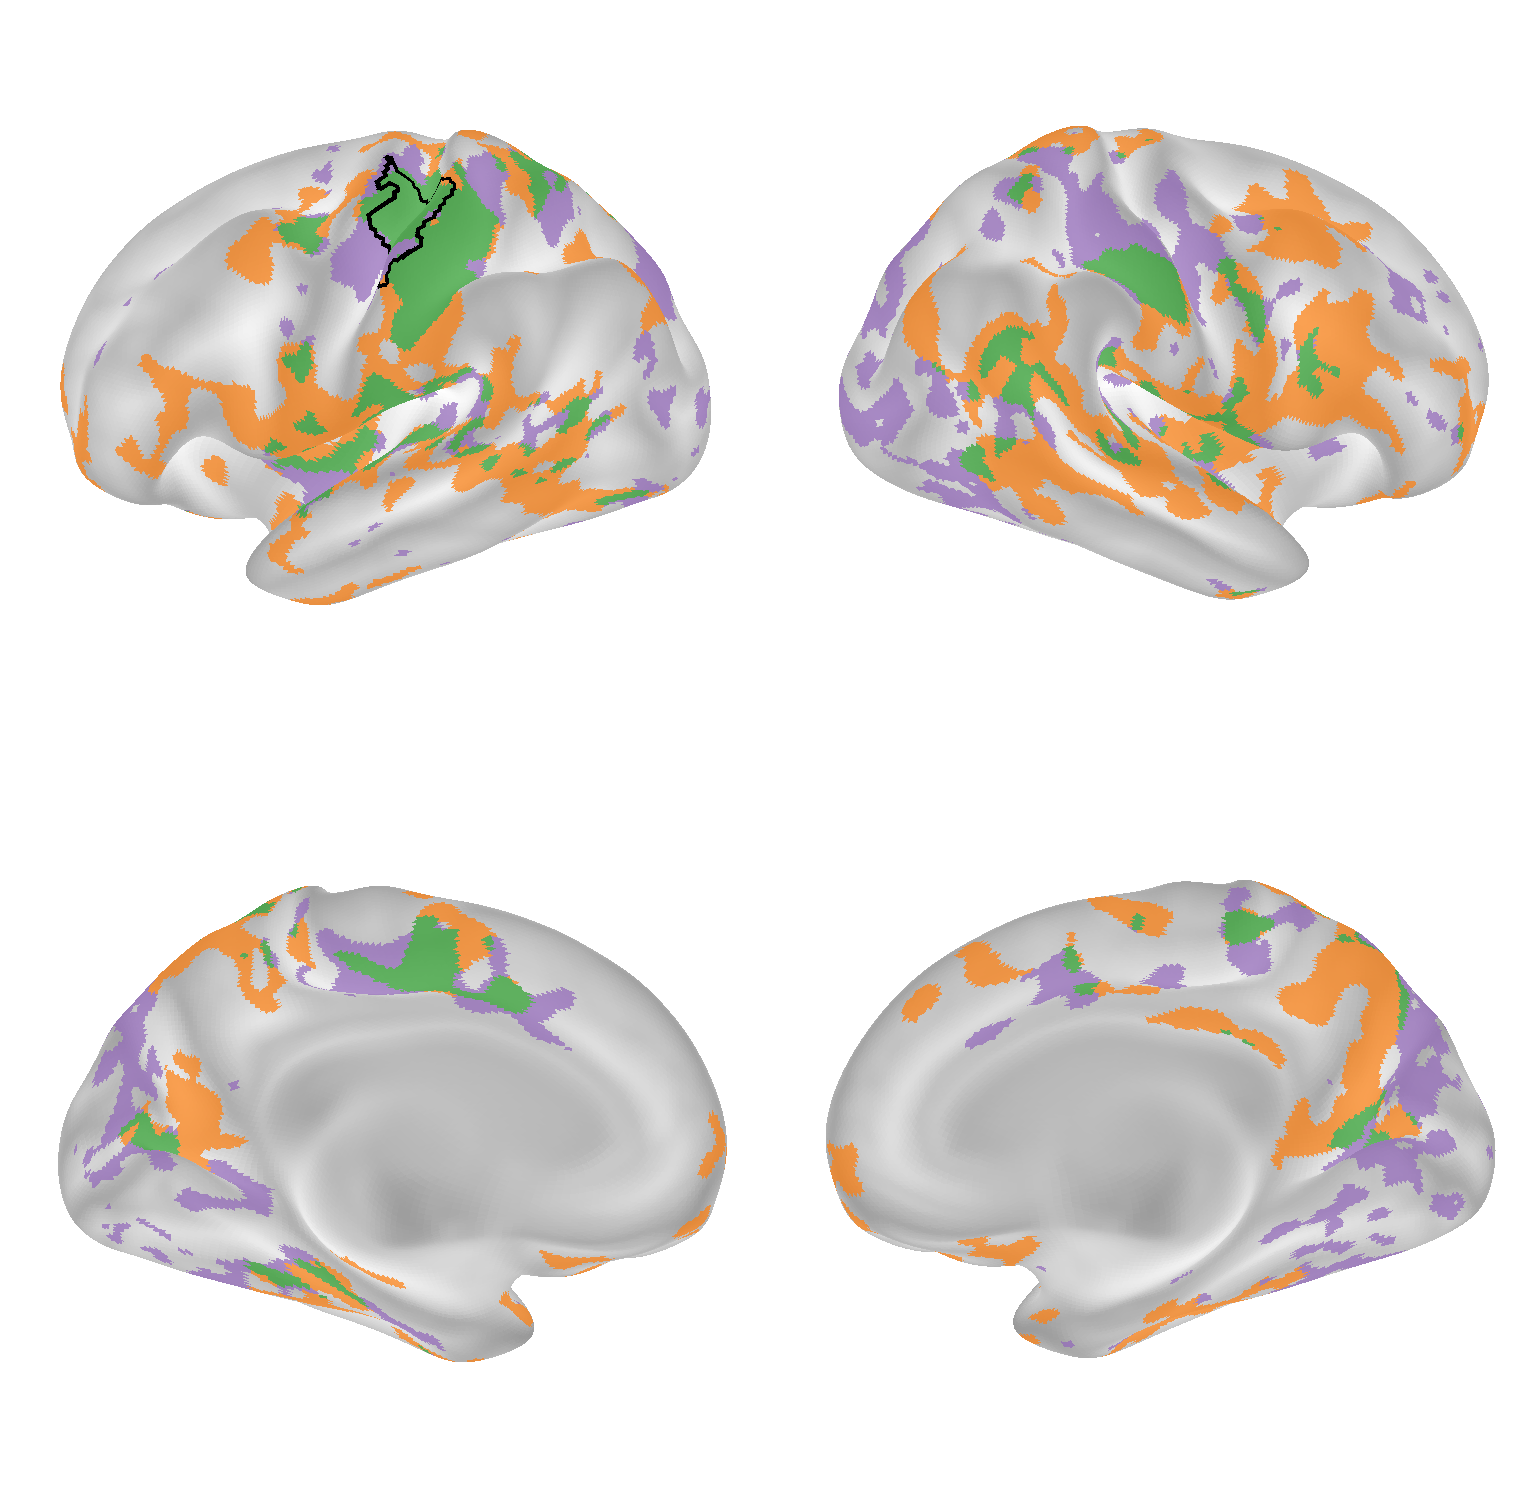

/tmp/ipykernel_2274/3779326731.py:86: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(savefig[:savefig.rfind('.')]+'-colorbar'+savefig[savefig.rfind('.'):])
/tmp/ipykernel_2274/3779326731.py:86: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(savefig[:savefig.rfind('.')]+'-colorbar'+savefig[savefig.rfind('.'):])
/data/nil-bluearc/GMT/RosCha/Tools/anaconda3/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


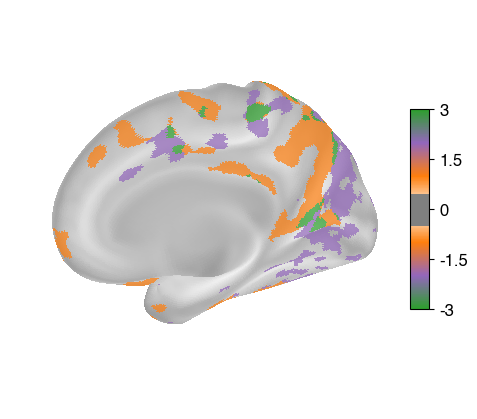

/data/nil-bluearc/GMT/RosCha/Tools/anaconda3/lib/python3.8/site-packages/nilearn/plotting/displays/_slicers.py:438: UserWarning: empty mask
  xmin_, xmax_, ymin_, ymax_, zmin_, zmax_ = get_mask_bounds(
/data/nil-bluearc/GMT/RosCha/Tools/anaconda3/lib/python3.8/site-packages/numpy/ma/core.py:2820: UserWarning: Warning: converting a masked element to nan.
  _data = np.array(data, dtype=dtype, copy=copy,


raw 0 ready
raw 1 ready
raw 2 ready


/tmp/ipykernel_2274/87443132.py:215: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(outdir,dpi=300)
/data/nil-bluearc/GMT/RosCha/Tools/anaconda3/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


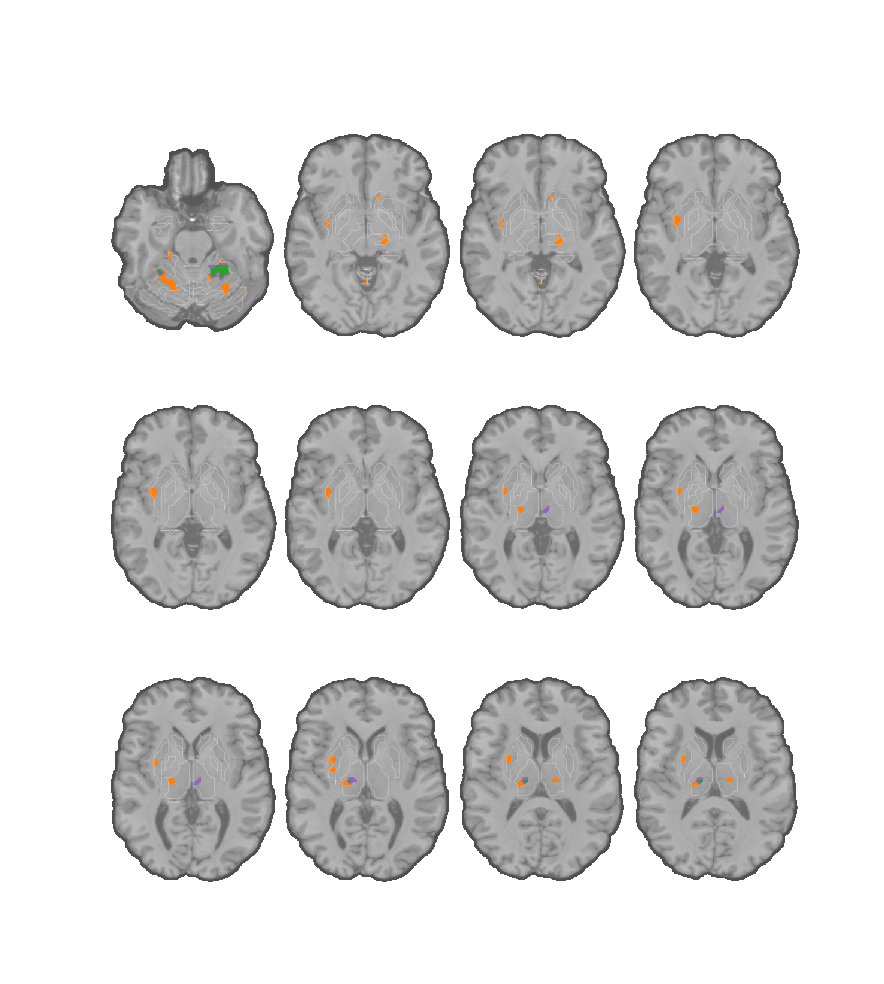

/data/nil-bluearc/GMT/RosCha/Results/Tasks/rest/SIC03/handseed_valselect.dtseries.nii
nothing on right hemi roi


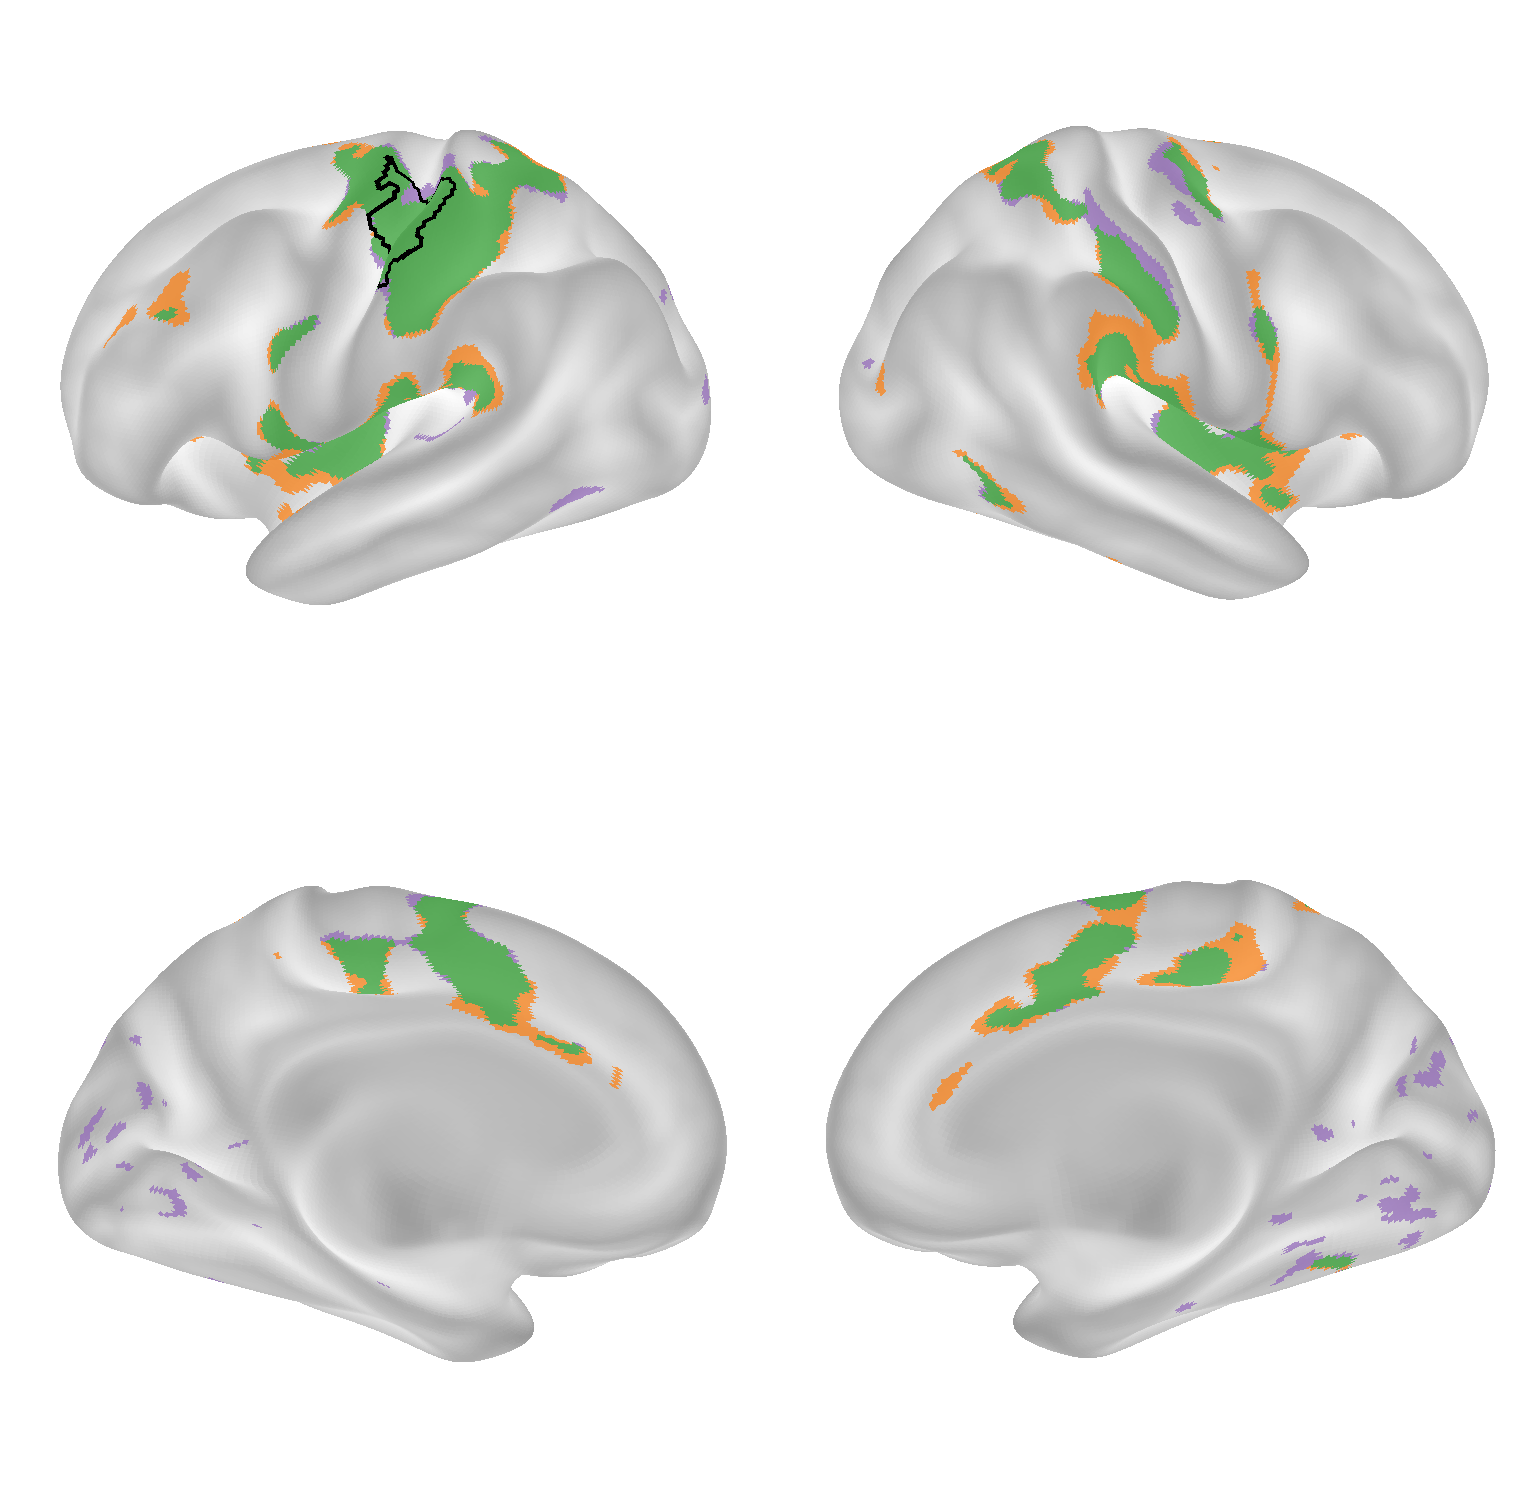

/tmp/ipykernel_2274/3779326731.py:86: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(savefig[:savefig.rfind('.')]+'-colorbar'+savefig[savefig.rfind('.'):])
/tmp/ipykernel_2274/3779326731.py:86: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(savefig[:savefig.rfind('.')]+'-colorbar'+savefig[savefig.rfind('.'):])
/data/nil-bluearc/GMT/RosCha/Tools/anaconda3/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


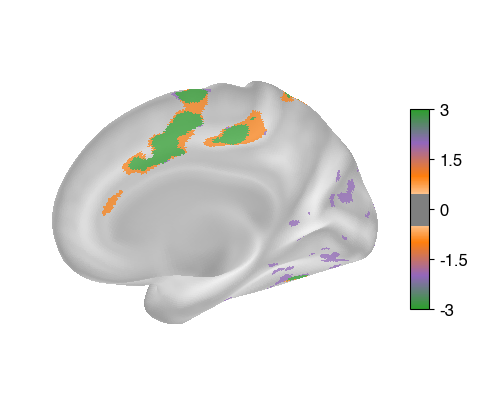

/data/nil-bluearc/GMT/RosCha/Tools/anaconda3/lib/python3.8/site-packages/nilearn/plotting/displays/_slicers.py:438: UserWarning: empty mask
  xmin_, xmax_, ymin_, ymax_, zmin_, zmax_ = get_mask_bounds(
/data/nil-bluearc/GMT/RosCha/Tools/anaconda3/lib/python3.8/site-packages/numpy/ma/core.py:2820: UserWarning: Warning: converting a masked element to nan.
  _data = np.array(data, dtype=dtype, copy=copy,


raw 0 ready
raw 1 ready
raw 2 ready


/tmp/ipykernel_2274/87443132.py:215: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(outdir,dpi=300)
/data/nil-bluearc/GMT/RosCha/Tools/anaconda3/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


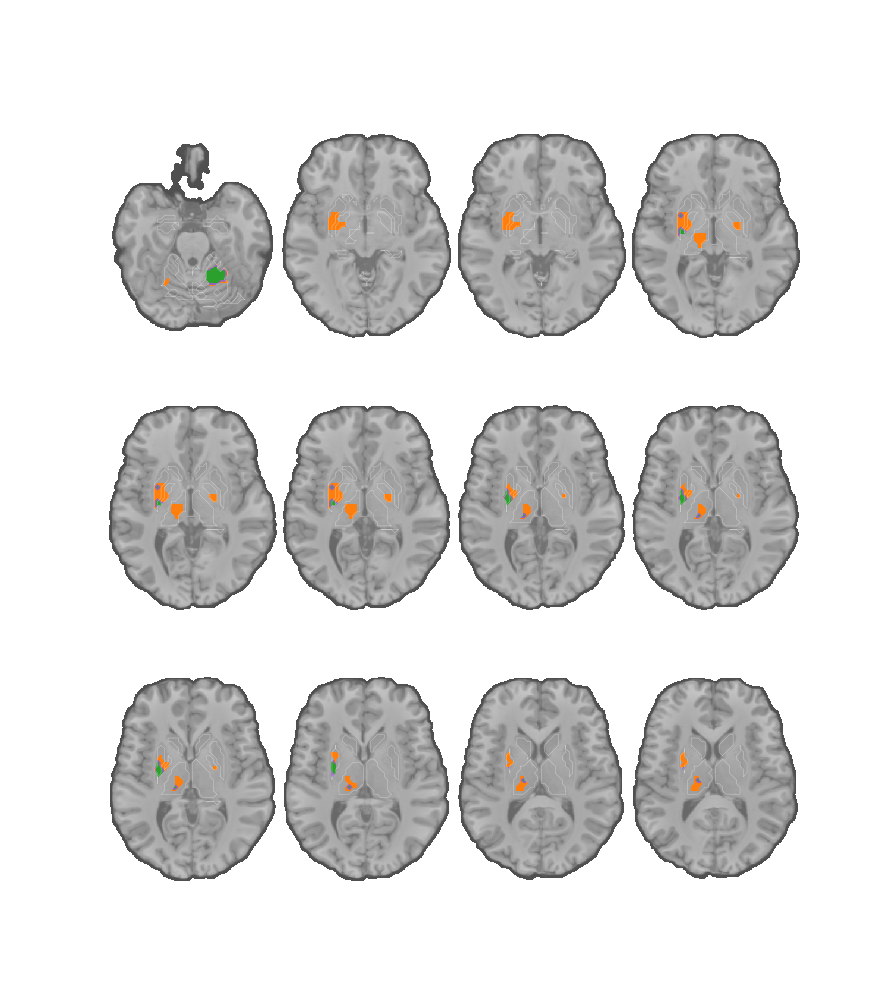

/data/nil-bluearc/GMT/RosCha/Results/Tasks/rest/SIC03/handseed_valselect.dtseries.nii
nothing on right hemi roi


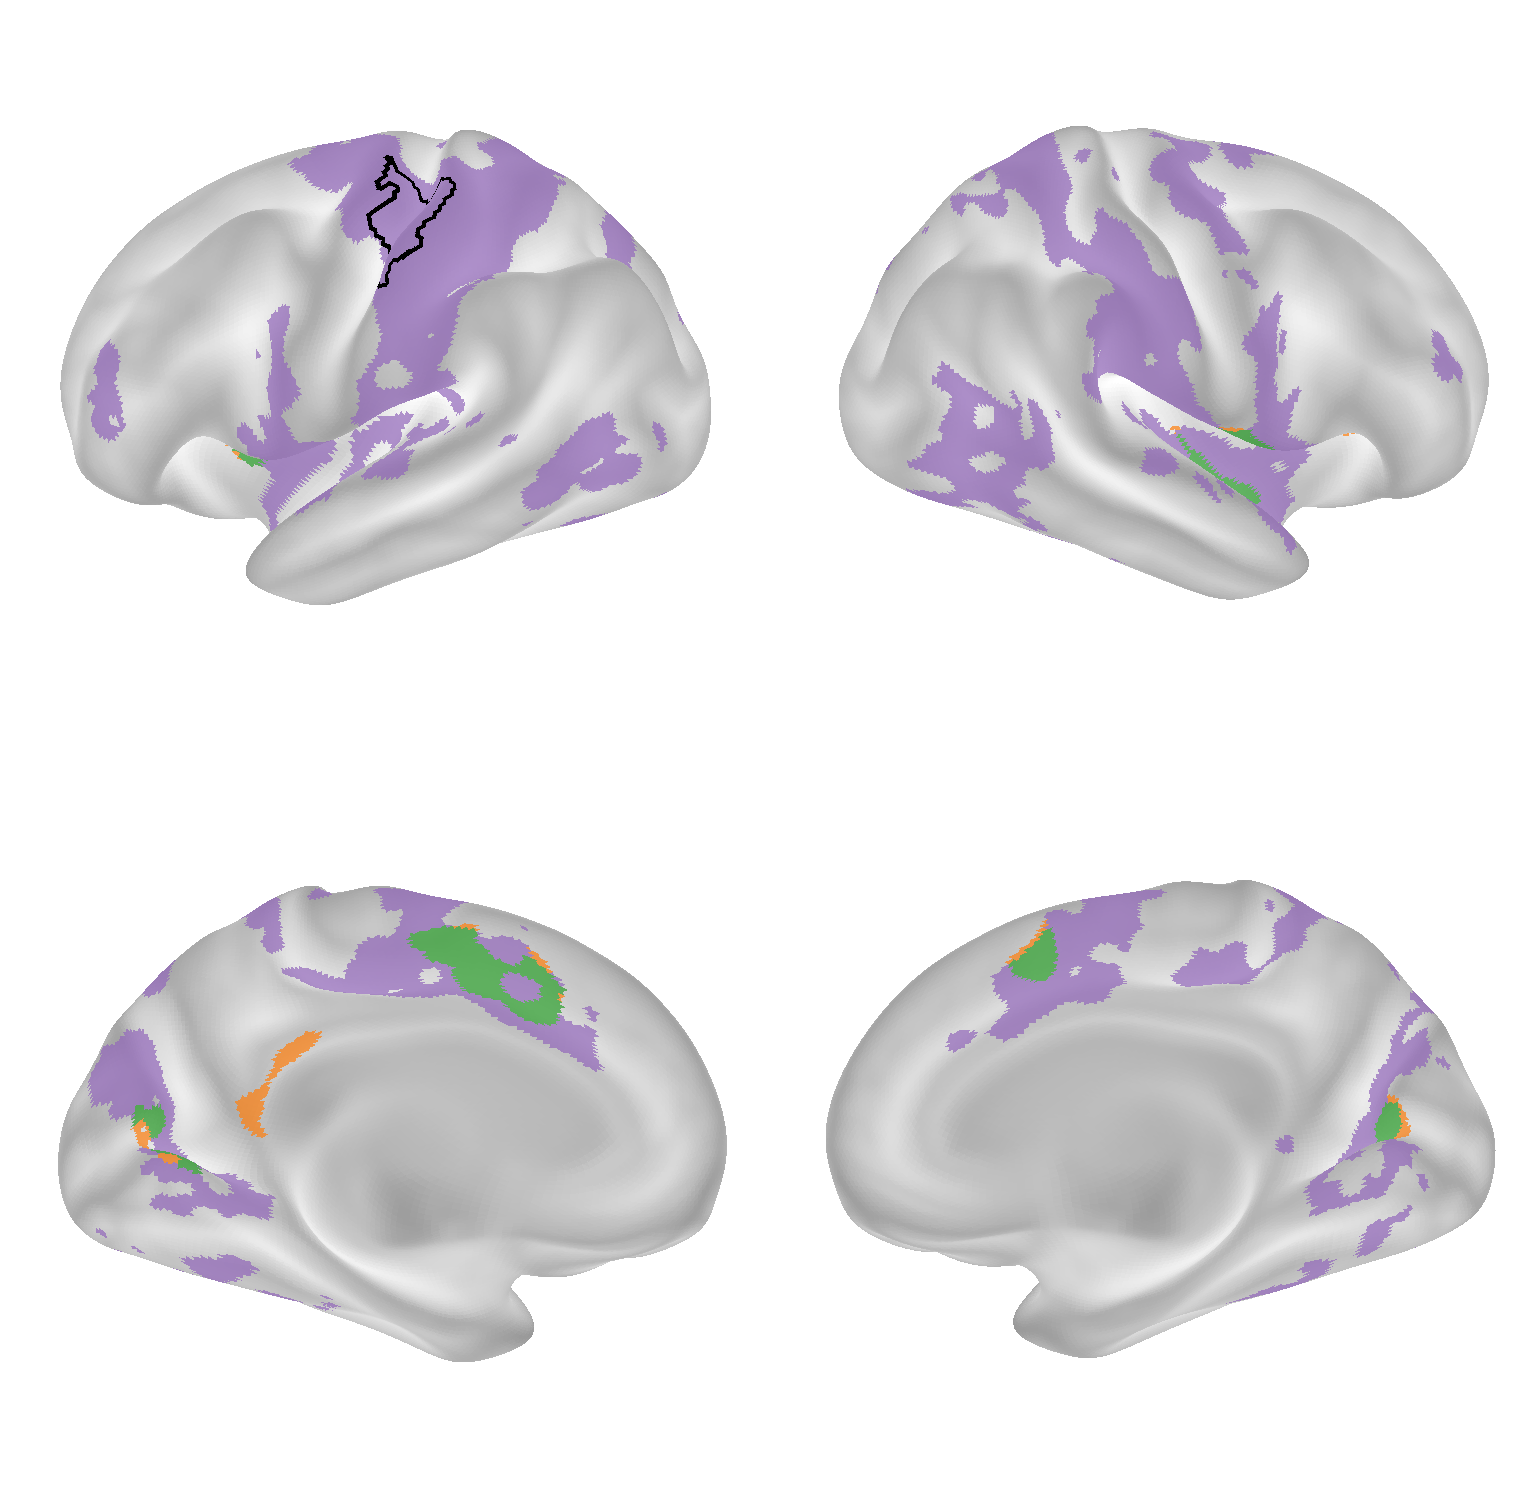

/tmp/ipykernel_2274/3779326731.py:86: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(savefig[:savefig.rfind('.')]+'-colorbar'+savefig[savefig.rfind('.'):])
/tmp/ipykernel_2274/3779326731.py:86: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(savefig[:savefig.rfind('.')]+'-colorbar'+savefig[savefig.rfind('.'):])
/data/nil-bluearc/GMT/RosCha/Tools/anaconda3/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


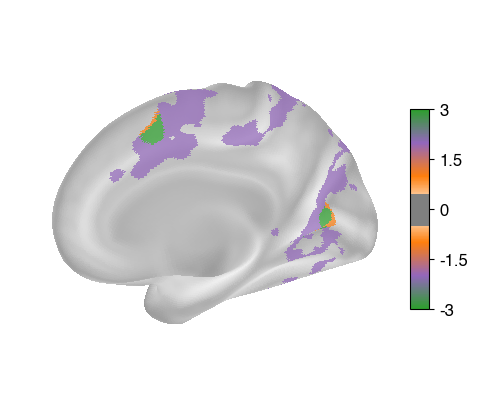

/data/nil-bluearc/GMT/RosCha/Tools/anaconda3/lib/python3.8/site-packages/nilearn/plotting/displays/_slicers.py:438: UserWarning: empty mask
  xmin_, xmax_, ymin_, ymax_, zmin_, zmax_ = get_mask_bounds(
/data/nil-bluearc/GMT/RosCha/Tools/anaconda3/lib/python3.8/site-packages/numpy/ma/core.py:2820: UserWarning: Warning: converting a masked element to nan.
  _data = np.array(data, dtype=dtype, copy=copy,


raw 0 ready
raw 1 ready
raw 2 ready


/tmp/ipykernel_2274/87443132.py:215: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(outdir,dpi=300)
/data/nil-bluearc/GMT/RosCha/Tools/anaconda3/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


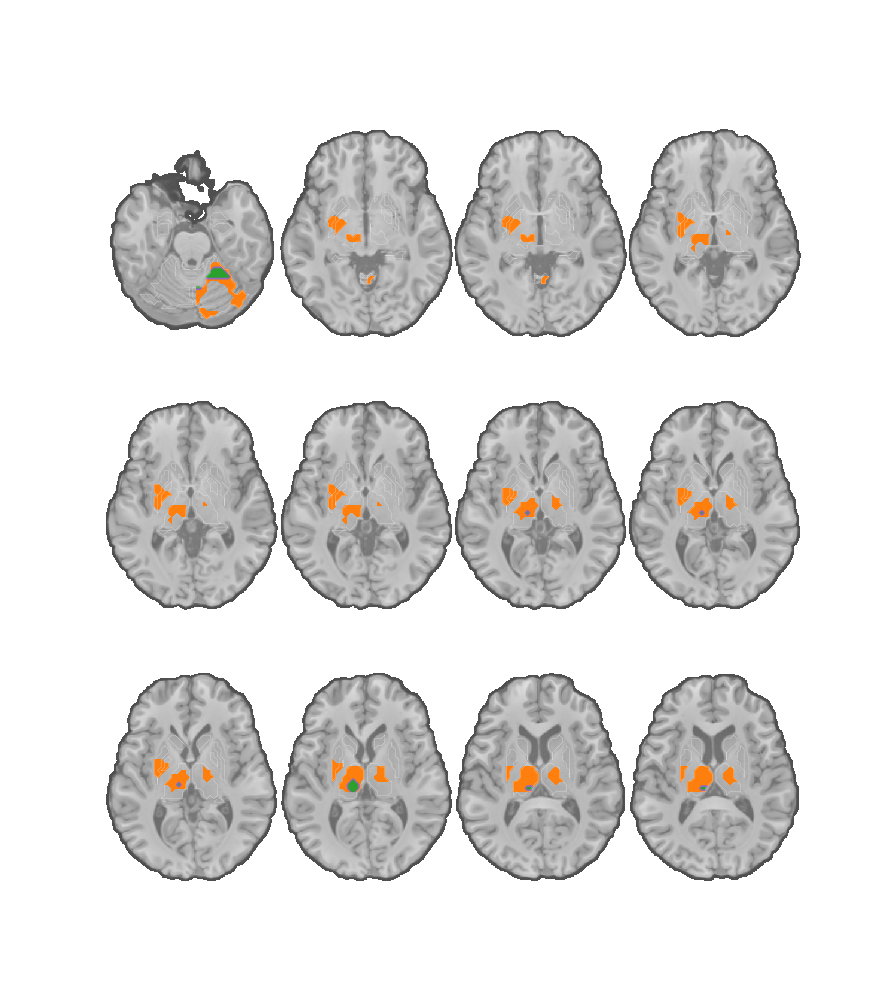

In [225]:
##HERE2310
black=np.array([0,0,0])
white=np.array([1,1,1])

#T1path=[path+'/croninj/SIC01/T1/SIC01_mpr_debias_avgT_111_t88.nii.gz',path+'/croninj/SIC02/T1/SIC02_mpr_debias_avgT_111_t88.nii.gz',path+'/Dillan/preproc_2018-07-03/SIC03/T1/SIC03_mpr_debias_avgT_111_t88.nii.gz']
T1path=[path+'/RosCha/Structurals/cast/bet/'+s+'/T1_masked.nii.gz' for s in sub]
sideval=[1,-1]
#e=1
#s=sub[e]
for e,s in enumerate(sub):#just changing the scaling of the thalamus

    basefile=path+'/RosCha/Results/Tasks/rest/'+s+'/pulsemodel'
    for side2,side in enumerate(['L']):#,'R']):
        if e==0:

            pathorig=basefile+'_'+side+'sm1_peakseries_during_avg_smooth6.0_masked80N_cut1.1-2-_Lsm1FCcastpre-1-_overlap-3_ALL.dtseries.nii'
        else:
            pathorig=basefile+'_'+side+'sm1_peakseries_during_avg_smooth6.0_masked80N_cut1.1_333-2-_Lsm1FCcastpre-1-_overlap-3_ALL.dtseries.nii'

        mycmap = get_continuous_cmap(sns.color_palette(np.concatenate([flatui[::-1],[white],flatui],0)).as_hex())
        plotsurfwithroi(pathorig,img_contour,roival=sideval[side2],vmin=-3,vmax=3,threshold=0.5,palette=mycmap,savefig=path+'/RosCha/Results/figures/plasticitypulses/surf_'+s+side+'SM1fc_overlap_pulsetop20N_T1.pdf',rollZ=20,scale=0.7,avg='median')
        
        flatui=np.array(sns.color_palette('tab20'))[[2,8,4]]#np.array(sns.color_palette('tab20'))[[2,8,4]]#[(102/255., 143/255., 244/255.),(244/255., 102/255., 143/255.),(244/255., 231/255., 102/255.)]#(1, 0, 0),(0, 0, 1),(0.75, 0.75, 0)]
        mycmap = get_continuous_cmap(sns.color_palette(np.concatenate([flatui[::-1],[white],flatui],0)).as_hex(),N=50)
        color_listpos = flatui#[(mycmap(i)) for i in range(25,50)]#[::-1]
        #color_listneg = [(mycmap(i)) for i in np.arange(24,-1,-1)]#[::-1]
        lim=[0,3]#limmaxall[e]]
        limpos=np.arange(1,4)-0.1#np.concatenate([[lim[0]],[(lim[1]-lim[0])*(i+1)/24+lim[0] for i in range(24)]],0)
        #lim=[-limmaxall[e],0]
        #limneg=limpos

        provlab=np.array([4, 6, 7, 10, 11] )
        net=path+'/RosCha/Structurals/cast/THOMAS/'+s+'thomasfull_T1.nii.gz'#path+'/RosCha/Structurals/cast/TRIO/'+s+'/ThalamicNuclei.v12.T1_on_TRIO_Y_NDC_222_BIN.nii.gz'

        #plotvolindivThalamT1(pathorig,net,T1path[e],segselect=provlab,ortho='z',colorpos=color_listpos,thresholdpos=limpos,Zannotate=False,smoothing=0,savefig=path+'/RosCha/Results/figures/plasticitypulses/vol_thalamus_'+s+side+'SM1fc_overlap_pulsetop20N_T1.pdf')#scale=5,space=None)
        
        
        
        plt.figure(figsize=[9,10])
        plotvolindivT1(pathorig,T1path[e],ortho='z',cut_coords=[-21,-4,-2,-1,0,1,2,3,4,5,8,9],Nraw=3,colorpos=color_listpos,savefig=path+'/RosCha/Results/figures/plasticitypulses/vol_'+s+side+'SM1fc_overlap_pulsetop20N_T1.pdf',thresholdpos=limpos,Zannotate=False,smoothing=None)#colorneg=color_listneg,#thresholdneg=limneg,
        plt.show()

# more visu function

In [46]:
#!!!!!!!!!!!!!!!!! this one works
import matplotlib.font_manager as font_manager

font_dirs = '/.fonts/'#]#Helvetica', ]
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)
for f in font_files:
    font_manager.fontManager.addfont(f)
    #font_manager.fontManager.ttflist.extend(font_list)

plt.rcParams['font.family'] = 'Helvetica'

In [12]:
def testplotnuclei2(s,pathdata1,pathdata2,pathdata3,pathdata,color,savename):
    #
    data=pathdata


    subatlaspath=path+'/RosCha/Structurals/cast/THOMAS/'+s+'thomasfull_castshape.nii.gz'

    prov4=thalamTHOMASquant(subatlaspath,data,threshold=0.5)[0]
    prov4[np.isnan(prov4)]=0
    prov4=np.array([100*np.round(np.float(i),2) for i in prov4])

    prov3=thalamTHOMASquant(subatlaspath,pathdata1,threshold=0.5)[0]
    prov3[np.isnan(prov3)]=0
    prov3=np.array([100*np.round(np.float(i),2) for i in prov3])

    prov2=thalamTHOMASquant(subatlaspath,pathdata2,threshold=0.5)[0]
    prov2[np.isnan(prov2)]=0
    prov2=np.array([100*np.round(np.float(i),2) for i in prov2])

    prov1=thalamTHOMASquant(subatlaspath,pathdata3,threshold=0.5)[0]
    prov1[np.isnan(prov1)]=0
    prov1=np.array([100*np.round(np.float(i),2) for i in prov1])


    order=np.argsort(prov4)

    order=orderfix#np.array([o for o in order if prov4[o]!=0])

    y_pos=np.arange(len(order))

    plt.figure(figsize=(3,3))#fig, ax = plt.subplots()
    plt.rcParams.update({'font.sans-serif':'Helvetica','font.size': 12})

    plt.barh(y_pos, prov4[order], align='center',color=color)#colorpic[2])
    plt.barh(y_pos, (prov4-prov2)[order], align='center',color=np.array(sns.color_palette('tab20')[6]))#colorpic[2])#motor
    plt.barh(y_pos, (prov3+prov1)[order], align='center',color=np.array(sns.color_palette('tab20')[7]))#colorpic[2]) #overlap
    plt.barh(y_pos, prov3[order], align='center',color=np.array([0.45364210443800146, 0.26235001796898216, 0.4572502050039957]))#colorpic[2]) #FC
    
    plt.vlines(0,-1,len(order),'k')

    plt.yticks(y_pos, labels=labelssegmentTHOMASalt[order])
    #ax.invert_yaxis()  # labels read top-to-bottom
    plt.xlim([0,100])
    plt.xticks([0,25,50,100],[0,25,50,100])
    plt.savefig(savename)
    plt.show()

In [13]:
def testplotnuclei(s,pathdata):

    data=pathdata


    subatlaspath=path+'/RosCha/Structurals/cast/THOMAS/'+s+'thomasfull_castshape.nii.gz'

    prov4=thalamTHOMASquant(subatlaspath,data,threshold=0.5)[0]
    prov4[np.isnan(prov4)]=0
    prov4=np.array([100*np.round(np.float(i),2) for i in prov4])


    order=np.argsort(prov4)

    order=orderfix#np.array([o for o in order if prov4[o]!=0])

    y_pos=np.arange(len(order))

    plt.figure(figsize=(3,3))#fig, ax = plt.subplots()
    plt.rcParams.update({'font.sans-serif':'Helvetica','font.size': 12})

    plt.barh(y_pos, prov4[order], align='center',color=np.array([0,0,0]))#colorpic[2])
    
    plt.vlines(0,-1,len(order),'k')

    plt.yticks(y_pos, labels=labelssegmentTHOMASalt[order])
    #ax.invert_yaxis()  # labels read top-to-bottom
    plt.xlim([0,100])
    plt.xticks([0,25,50,100],[0,25,50,100])
    plt.show()

In [14]:
def plotvolindivThalam(ciftiloc,thalamseg,segselect='',ortho='z',cut_coords='',Nraw=1,colorpos='r',colorneg='b',savefig='', thresholdneg=False,thresholdpos=False,Zannotate='Both',smoothing=0, scale=0.8,space=5,xy=(0,1)):
    #segselect is the list of index from freesurfer segmentation we want to display, if default, all of them are taken
    raw=nibabel.load(ciftiloc)
    data=np.zeros(len(raw.dataobj[0]))
    axes = [raw.header.get_axis(i) for i in range(raw.ndim)]
    # You'll want the brain model axis
    time_axis, brain_model_axis = axes
    #get the structure and make a temp file with level
    keepstructure=[]
    if thalamseg.find('dtseries')!=-1:
        thalamsegdata=nibabel.load(thalamseg).dataobj[0]
        if segselect=='':
            thalid=[i for i in np.unique(thalamsegdata) if i !=0]
        else:
            thalid=segselect

        data[np.where(brain_model_axis.name=='CIFTI_STRUCTURE_THALAMUS_LEFT')]=1
        data[np.where(brain_model_axis.name=='CIFTI_STRUCTURE_THALAMUS_RIGHT')]=1
        for e,b in enumerate(thalid):
            data[np.where(thalamsegdata==b)[0]]=e+2

        time_axis2=nibabel.cifti2.cifti2_axes.SeriesAxis(1,1,1)
        img=ci.Cifti2Image(np.array([data]), header=(time_axis2, brain_model_axis),
                    nifti_header=raw.nifti_header)
        ci.save(img,ciftiloc.replace('.dtseries.nii','_structuremask.dtseries.nii'))



        subprocess.call(['wb_command','-cifti-separate-all',ciftiloc.replace('.dtseries.nii','_structuremask.dtseries.nii'),'-volume',ciftiloc.replace('.dtseries.nii','_structuremask_vol.nii.gz'),'-left',ciftiloc.replace('.dtseries.nii','_structuremask_L.func.gii'),'-right',ciftiloc.replace('.dtseries.nii','_structuremask_R.func.gii')])
        thalamsegpath=ciftiloc.replace('.dtseries.nii','_structuremask_vol.nii.gz')
    else:
        thalid=segselect
        thalamsegpath=thalamseg
        thalamsegdata=nibabel.load(ciftiloc).dataobj[0]
        
        data[np.where(brain_model_axis.name=='CIFTI_STRUCTURE_THALAMUS_LEFT')]=1
        data[np.where(brain_model_axis.name=='CIFTI_STRUCTURE_THALAMUS_RIGHT')]=1
        
        time_axis2=nibabel.cifti2.cifti2_axes.SeriesAxis(1,1,1)
        img=ci.Cifti2Image(np.array([data]), header=(time_axis2, brain_model_axis),
                    nifti_header=raw.nifti_header)
        ci.save(img,ciftiloc.replace('.dtseries.nii','_structuremask.dtseries.nii'))



        subprocess.call(['wb_command','-cifti-separate-all',ciftiloc.replace('.dtseries.nii','_structuremask.dtseries.nii'),'-volume',ciftiloc.replace('.dtseries.nii','_structuremask_vol.nii.gz'),'-left',ciftiloc.replace('.dtseries.nii','_structuremask_L.func.gii'),'-right',ciftiloc.replace('.dtseries.nii','_structuremask_R.func.gii')])
        thalamstructure=ciftiloc.replace('.dtseries.nii','_structuremask_vol.nii.gz')
    subprocess.call(['wb_command','-cifti-separate-all',ciftiloc,'-volume',ciftiloc.replace('.dtseries.nii','_vol.nii.gz'),'-left',ciftiloc.replace('.dtseries.nii','_L.func.gii'),'-right',ciftiloc.replace('.dtseries.nii','_R.func.gii')])
    niftipath=ciftiloc.replace('.dtseries.nii','_vol.nii.gz')
    #cutctest=copy.deepcopy(np.array(nibabel.load(ciftiloc.replace('.dtseries.nii','_structuremask_vol.nii.gz')).dataobj))
    #cut_coords=np.where(cutctest!=0)
    #print(np.unique(cut_coords[0]),np.unique(cut_coords[1]),np.unique(cut_coords[2]))
    #print(stop)
    if ortho=='z':
        cut_coords=np.arange(-2,18)#np.unique(cut_coords[0])
    #if ortho=='y':
    #    cut_coords=np.unique(cut_coords[1])
    #if ortho=='x':
    #    cut_coords=np.unique(cut_coords[2])
    Nraw=int(np.ceil(len(cut_coords)/5.))
    #adfake=(Nraw-int(len(cut_coords)/5))*5
    #if adfake!=0:
    #    cut_coords=np.concatenate([cut_coords,[0 for i in range(adfake)]])
    print(cut_coords,Nraw)
    
    
    
    #cut_coords=cut_coords[:5]
    #Nraw=1
    
    plt.figure(figsize=[9,2*Nraw])#[9*5,10*Nraw])#3,4
    #cut_coords=[13,14,15,16,31]#cut_coords[:5]
    #Nraw=1
    
    
    
    if thalamseg.find('dtseries')!=-1:
        plotZslices_alloptionTHAL(niftipath,thalamsegpath,valmni=thalid,ortho=ortho,cut_coords=cut_coords,Nraw=Nraw,outdir=savefig,colorpos=colorpos,colorneg=colorneg,Zannotate=Zannotate,thresholdpos=thresholdpos,thresholdneg=thresholdneg,alphamap=1,alphabrain=1,smoothing=smoothing,scale=scale,space=space,xy=xy)
    else:
        plotZslices_alloptionTHAL(niftipath,thalamsegpath,thalamstructure,valmni=thalid,ortho=ortho,cut_coords=cut_coords,Nraw=Nraw,outdir=savefig,colorpos=colorpos,colorneg=colorneg,Zannotate=Zannotate,thresholdpos=thresholdpos,thresholdneg=thresholdneg,alphamap=1,alphabrain=1,smoothing=smoothing,scale=scale,space=space,xy=xy)
    
    plt.show()
    
    subprocess.call(['rm',ciftiloc.replace('.dtseries.nii','_vol.nii.gz'),ciftiloc.replace('.dtseries.nii','_L.func.gii'),ciftiloc.replace('.dtseries.nii','_R.func.gii')])
    subprocess.call(['rm',ciftiloc.replace('.dtseries.nii','_structuremask_vol.nii.gz'),ciftiloc.replace('.dtseries.nii','_structuremask_L.func.gii'),ciftiloc.replace('.dtseries.nii','_structuremask_R.func.gii'),ciftiloc.replace('.dtseries.nii','_structuremask.dtseries.nii')])

In [15]:
def testplotnucleiavg(s,pathdata,savename,xlim,color,thresh=None,select=[]):

    data=pathdata


    subatlaspath=path+'/RosCha/Structurals/cast/THOMAS/'+s+'thomasfull_castshape.nii.gz'

    prov4=thalamTHOMASquant(subatlaspath,data,method='mean',threshold=thresh)[0]
    prov4[np.isnan(prov4)]=0
    if len(select)!=0:
        order=np.array(orderfix)[np.array(select)]
        plt.figure(figsize=(3,6))#fig, ax = plt.subplots()
    else:
        order=orderfix#np.array([o for o in order if prov4[o]!=0])
        plt.figure(figsize=(3,3))#fig, ax = plt.subplots()

    y_pos=np.arange(len(order))

    
    plt.rcParams.update({'font.sans-serif':'Helvetica','font.size': 12})

    plt.barh(y_pos, prov4[order], align='center',color=color)#np.array([0,0,0]))#colorpic[2])
    
    plt.vlines(0,-1,len(order),'k')

    plt.yticks(y_pos, labels=labelssegmentTHOMASalt[order])
    #ax.invert_yaxis()  # labels read top-to-bottom
    plt.xlim([0,xlim])
    plt.savefig(savename)
    plt.show()

In [ ]:
#then the same for motor mouth Rhand Rfoot R-Lhand ("salsea") + nuclei average

taskname=['tongue','righthand','rightfoot','L-Rhand']

for e,s in enumerate(sub):
    data2=[]
    for n2,n in enumerate(['1','3','5','6']):
        basefile=path+'/RosCha/Results/Tasks/rest/'+s+'/pulsemodel'
        #reference
        if e==0:
            
            pathref=basefile+'_'+side+'sm1_peakseries_statistics_smooth6.0_tripletop40adjustedAMP-PEAK-SPREAD_thlamicvox-2-_Lsm1FCcastpre-1-_overlap-3.dtseries.nii'
        else:
            pathref=basefile+'_'+side+'sm1_peakseries_statistics_smooth6.0_tripletop20adjustedAMP-PEAK-SPREAD_thlamicvox_333-2-_Lsm1FCcastpre-1-_overlap-3.dtseries.nii'


        raw=nibabel.load(pathref)
        axes = [raw.header.get_axis(i) for i in range(raw.ndim)]
        # You'll want the brain model axis
        time_axis, brain_model_axis = axes

        #reshape if not e==0
        if e==0:
            
            pathorig=path+'/RosCha/Results/Tasks/motor/'+s+'/second_level_cifti_precast_vs_postcast/cifti_cope'+n+'/zstat3_smooth6.0.dtseries.nii'
        else:
            pathorig=path+'/RosCha/Results/Tasks/motor/'+s+'/second_level_cifti_precast_vs_postcast/cifti_cope'+n+'/zstat3_smooth6.0.dtseries.nii'





            net=pathorig
            tag3='dtseries'

            subprocess.call(['wb_command','-cifti-separate-all',net,'-volume',net.replace('.'+tag3+'.nii','_vol.nii.gz'),'-left',net.replace('.'+tag3+'.nii','_L.func.gii'),'-right',net.replace('.'+tag3+'.nii','_R.func.gii')])


            netV=net.replace('.'+tag3+'.nii','_vol.nii.gz')

            #save-flirt-load
            subcorticaldir=path+'/Dillan/preproc_2018-07-03/'+sub[e]+'/subcortical_mask_222'
            #if s==0:
            subcorticalmask=path+'/Dillan/preproc_2018-07-03/'+sub[e]+'/subcortical_mask/subcortical_mask_LR_333.nii'


            #reshape
            subprocess.call(['flirt','-in',netV,'-ref',subcorticalmask,'-applyxfm','-usesqform','-out',netV.replace('.nii.gz','_333.nii.gz')])
            rightfile=net.replace('.'+tag3+'.nii','_R.func.gii')
            leftfile=net.replace('.'+tag3+'.nii','_L.func.gii')
            Subcortical=netV.replace('.nii.gz','_333.nii.gz')
            subprocess.call(['wb_command','-cifti-create-dense-timeseries',net.replace('.'+tag3+'.nii','_333.dtseries.nii'),'-volume',Subcortical,subcorticalmask,'-left-metric',leftfile,'-roi-left',subcorticaldir+'/L.atlasroi.32k_fs_LR.shape.gii','-right-metric',rightfile,'-roi-right',subcorticaldir+'/R.atlasroi.32k_fs_LR.shape.gii'])
            maskeddata=nibabel.load(net.replace('.'+tag3+'.nii','_333.dtseries.nii')).get_fdata()[0]
            subprocess.call(['rm',rightfile,leftfile,Subcortical,netV])
            pathorig=pathorig.replace('.'+tag3+'.nii','_333.dtseries.nii')
        
        
        
        if n=='6':
            raw=nibabel.load(pathorig)
            data=raw.get_fdata()
            data=-data
            img=ci.Cifti2Image(np.array(data), header=raw.header)
            ci.save(img,pathorig.replace('.dtseries.nii','inverse.dtseries.nii'))
            pathorig=pathorig.replace('.dtseries.nii','inverse.dtseries.nii')
            
        raw=nibabel.load(pathorig)
        data=raw.get_fdata()[0]
        
        limmax=8#np.percentile(data[np.where(brain_model_axis.name=='CIFTI_STRUCTURE_THALAMUS_LEFT')],99)
        thresh=np.percentile(data[np.where(brain_model_axis.name=='CIFTI_STRUCTURE_THALAMUS_LEFT')],90)
        mycmap=mycolorscale("salsea",limpos=limmax,limneg=-limmax,threshold=0,Ncolor=50)
        color_listpos = [(mycmap(i)) for i in range(25,50)]#[::-1]
        color_listneg = [(mycmap(i)) for i in np.arange(24,-1,-1)]#[::-1]
        
        lim=[0,8]#limmax]#limmaxall[e]]
        limpos=np.concatenate([[lim[0]],[(lim[1]-lim[0])*(i+1)/24+lim[0] for i in range(24)]],0)
        cutoff=np.where(limpos>=thresh)[0][0]
        limpos=limpos[cutoff:]
        color_listpos=color_listpos[cutoff:]
        color_listneg=color_listneg[cutoff:]
        #lim=[-limmaxall[e],0]
        limneg=limpos

        provlab=np.array([4, 6, 7, 10, 11] )
        net=path+'/RosCha/Structurals/cast/THOMAS/'+s+'thomasfull_T1.nii.gz'#path+'/RosCha/Structurals/cast/TRIO/'+s+'/ThalamicNuclei.v12.T1_on_TRIO_Y_NDC_222_BIN.nii.gz'
        #print(stop)
        plotvolindivThalamT1(pathorig,net,T1path[e],segselect=provlab,ortho='z',colorneg=color_listneg,thresholdneg=limneg,colorpos=color_listpos,thresholdpos=limpos,Zannotate=False,smoothing=0,savefig=path+'/RosCha/Results/figures/plasticitypulses/vol__'+s+'_'+taskname[n2]+'_motorprecast.pdf')#scale=5,space=None)
        testplotnucleiavg(s,pathorig,path+'/RosCha/Results/figures/plasticitypulses/bar_'+s+'_'+taskname[n2]+'_motorprecast.pdf',4,color_listpos[::-1][0],thresh)


[(1, 0.8112802768166091, 0.6947174163783161), (0.989442522106882, 0.6678892733564014, 0.5968473663975393), (0.9390772779700115, 0.4687043444828912, 0.5082660515186466), (0.8776239907727796, 0.21378700499807765, 0.4058439061899269), (0.8084044598231449, 0, 0.27563244905805456), (0.6707035755478662, 0, 0.1641061130334487)]
[-2 -1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17] 4


/tmp/ipykernel_25887/171493490.py:34: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if valmni=='':
/tmp/ipykernel_25887/171493490.py:42: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if type(cut_coords)==int or cut_coords=='':
/tmp/ipykernel_25887/171493490.py:56: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if cut_coords!=(0,0,0):
/data/nil-bluearc/GMT/RosCha/Tools/anaconda3/lib/python3.8/site-packages/nilearn/plotting/displays/_slicers.py:438: UserWarning: empty mask
  xmin_, xmax_, ymin_, ymax_, zmin_, zmax_ = get_mask_bounds(
/data/nil-bluearc/GMT/RosCha/Tools/anaconda3/lib/python3.8/site-packages/numpy/ma/core.py:2820: UserWarning: Warning: converting a masked element to nan.
  _data = np.array(data, dtype=dtype, copy=copy,
/data/nil-bluearc/GMT/RosCha/Tools/anaconda3/lib/

yes
raw 0 ready
yes
raw 1 ready


In [ ]:
##back to trio and cifti

#import
import os
import glob
import subprocess
import nibabel
import copy
import numpy as np
import sys
import argparse
from nibabel import cifti2 as ci

#function#

def map_vol_to_cifti(funcvol,outfile,fsLRfolder='',subcort_mask='',TR=''):

    #map_vol_to_cifti(funcvol,[fsLRfolder],[subcort_mask])
    #funcvol a nifti file in atlas TRYO registration
    #fslLRfolder a directory e.g. /data/nil-bluearc/GMT/Laumann/MSC/MSM_nativeresampled2_TYNDC/MSC02/
    #subcort_mask a nifti file e.g. /data/nil-bluearc/GMT/Dillan/preproc_2018-07-03/SIC01/subcortical_mask/subcortical_mask_LR_333.nii

    if not os.path.exists(subcort_mask) and subcort_mask!='':
        subcort_mask = '/data/cn4/laumannt/subcortical_mask/subcortical_mask_LR_333.nii'

    if os.path.exists(fsLRfolder) and fsLRfolder!='':
        print('mapping data to subject-specific surface')
        subspecific = True
    else:
        print('mapping data to group surface')
        fsLRfolder = '/data/cn/data1/scripts/CIFTI_RELATED/Resources/Conte69_atlas-v2.LR.32k_fs_LR.wb/'
        subspecific = False
        

    medial_masks = [path+'/Evan/Scripts/CoEScripts/Resources/cifti_masks/L.atlasroi.32k_fs_LR.shape.gii',path+'/Evan/Scripts/CoEScripts/Resources/cifti_masks/R.atlasroi.32k_fs_LR.shape.gii']
    #workbenchdir = '/data/cn/data1/linux/bin/'
    HEMS = ['L','R']
    surfname_final=[]
    if subspecific:
        examplefile = glob.glob(fsLRfolder+'/Native/*.L.midthickness.native.surf.gii')[0]
        subname_start = examplefile.find('/Native/') + len('/Native/')
        subname_stop = examplefile.find('.L.midthickness.native.surf.gii')
        subject = examplefile[subname_start : subname_stop]

    outname=outfile.replace('.dtseries.nii','')#dir+funcvol.replace(os.dirname(funcvol)+'/','').replace('.nii','').replace('.gz','')


    for hem in HEMS:
        surfname = outname+'_'+hem
        
        if subspecific:
            
            midsurf = fsLRfolder+'/Native/'+subject+'.'+hem+'.midthickness.native.surf.gii'
            midsurf_LR32k = fsLRfolder+'/fsaverage_LR32k/'+subject+'.'+hem+'.midthickness.32k_fs_LR.surf.gii'
            whitesurf = fsLRfolder+'/Native/'+ subject+ '.'+hem+ '.white.native.surf.gii'
            pialsurf = fsLRfolder+'/Native/'+subject+'.'+hem+'.pial.native.surf.gii'
            nativedefsphere = fsLRfolder +'/Native/'+subject+'.' +hem+'.sphere.reg.reg_LR.native.surf.gii'
            outsphere = fsLRfolder+'/fsaverage_LR32k/'+subject+'.' +hem+ '.sphere.32k_fs_LR.surf.gii'
            
            #subprocess.call(['wb_command','-volume-to-surface-mapping',funcvol,midsurf,surfname+'_32k_fs_LR.func.gii','-ribbon-constrained',whitesurf,pialsurf])
            subprocess.call(['wb_command','-volume-to-surface-mapping',funcvol,midsurf,surfname+'.func.gii','-ribbon-constrained',whitesurf,pialsurf])
            
            print(' '.join(['wb_command','-volume-to-surface-mapping',funcvol,midsurf,surfname+'_32k_fs_LR.func.gii','-ribbon-constrained',whitesurf,pialsurf]))
            subprocess.call(['wb_command','-metric-resample',surfname+'.func.gii',nativedefsphere,outsphere,'ADAP_BARY_AREA', surfname+'_32k_fs_LR.func.gii','-area-surfs',midsurf,midsurf_LR32k])
            

        else:
            print('WARNING: not subejct specific')
            midsurf = fsLRfolder+ 'Conte69.' +hem+ '.midthickness.32k_fs_LR.surf.gii'
            whitesurf = fsLRfolder+ 'Conte69.' +hem+ '.white.32k_fs_LR.surf.gii'
            pialsurf = fsLRfolder +'Conte69.' +hem+ '.pial.32k_fs_LR.surf.gii'
            
            subprocess.call(['wb_command','-volume-to-surface-mapping',funcvol,midsurf,surfname+ '_32k_fs_LR.func.gii','-ribbon-constrained',whitesurf,pialsurf])
            
            
        
        surfname_final+=[surfname+'_32k_fs_LR.func.gii']
        #%systemcall_silent(['/usr/local/caret/bin_linux64/caret_command -file-convert -format-convert XML_BASE64 ' surfname_final{hem}]);
        
    
    subprocess.call(['wb_command','-cifti-create-dense-timeseries',outname+'.dtseries.nii','-volume',funcvol,subcort_mask,'-left-metric', surfname_final[0],'-roi-left', medial_masks[0],'-right-metric', surfname_final[1],'-roi-right',medial_masks[1],'-timestep','0','-timestart','0'])
    subprocess.call(['rm',surfname_final[0]])
    subprocess.call(['rm',surfname_final[1]])
    subprocess.call(['rm',surfname_final[0].replace('_32k_fs_LR','')])
    subprocess.call(['rm',surfname_final[1].replace('_32k_fs_LR','')])

#-main-
for e,sub2 in enumerate(['SIC01','SIC02','SIC03']):

    sub=sub2

    print(sub)

    if sub=='SIC01':
        t1native=path+'/Dillan/preproc_2018-07-03/SIC01/T1/SIC01_mpr_debias_avgT.nii.gz'
        outdir= path+'/RosCha/Structurals/cast/TRIO/'+sub+'/'
        if not os.path.exists(outdir):
            os.makedirs(outdir)
        zeronii=nibabel.load(t1native)
        zerodata=(np.array(zeronii.get_fdata())*0).T
        zerodata=np.array([zerodata[0],zerodata[0],zerodata[0]]).T
        zero=outdir+'zero.nii.gz'
        nibabel.save(nibabel.Nifti1Image(zerodata, zeronii.affine, zeronii.header),zero)
        t4file=path+'/Laumann/MSC/MSC02/T1/MSC02_mpr1T_debias_to_TRIO_Y_NDC_t4'
        matfile=outdir+'SIC01_mpr_debias_avgT_to_TRIO_Y_NDC_t4'###############
        fsLRfolder=path+'/Laumann/MSC/MSM_nativeresampled2_TYNDC/MSC02/'
        subcorticalmask=path+'/Dillan/preproc_2018-07-03/SIC01/subcortical_mask_222/subcortical_mask_LR_222.nii'
    
        fsLRfolder333=path+'/Laumann/MSC/MSM_nativeresampled2_TYNDC/MSC02/'
        subcorticalmask333=path+'/Dillan/preproc_2018-07-03/SIC01/subcortical_mask/subcortical_mask_LR_333.nii'

    elif sub=='SIC02':
        t1native=path+'/Dillan/preproc_2018-07-03/SIC02/T1/SIC02_mpr_debias_avgT.nii.gz'
        outdir= path+'/RosCha/Structurals/cast/TRIO/'+sub+'/'
        if not os.path.exists(outdir):
            os.makedirs(outdir)
        zeronii=nibabel.load(t1native)
        zerodata=(np.array(zeronii.get_fdata())*0).T
        zerodata=np.array([zerodata[0],zerodata[0],zerodata[0]]).T
        zero=outdir+'zero.nii.gz'
        nibabel.save(nibabel.Nifti1Image(zerodata, zeronii.affine, zeronii.header),zero)
        t4file=path+'/Dillan/preproc_2018-07-03/SIC02/T1/atlas/SIC02_mpr_debias_avgT_to_TRIO_Y_NDC_t4'
        matfile=outdir+'SIC02_mpr_debias_avgT_to_TRIO_Y_NDC_t4'


        fsLRfolder=path+'/Dillan/preproc_2018-07-03/SIC02/7112b_fs_LR/'
        subcorticalmask=path+'/Dillan/preproc_2018-07-03/SIC02/subcortical_mask_222/subcortical_mask_LR_222.nii'
    elif sub=='SIC03':
        t1native=path+'/Dillan/preproc_2018-07-03/SIC03/T1/SIC03_mpr_debias_avgT.nii.gz'
        outdir= path+'/RosCha/Structurals/cast/TRIO/'+sub+'/'
        if not os.path.exists(outdir):
            os.makedirs(outdir)
        zeronii=nibabel.load(t1native)
        zerodata=(np.array(zeronii.get_fdata())*0).T
        zerodata=np.array([zerodata[0],zerodata[0],zerodata[0]]).T
        zero=outdir+'zero.nii.gz'
        nibabel.save(nibabel.Nifti1Image(zerodata, zeronii.affine, zeronii.header),zero)
        t4file=path+'/Dillan/preproc_2018-07-03//SIC03//T1/SIC03_mpr1T_debias_to_TRIO_Y_NDC_t4'
        matfile=outdir+'SIC03_mpr_debias_avgT_to_TRIO_Y_NDC_t4'
        fsLRfolder=path+'/Dillan/preproc_2018-07-03/SIC03/7112b_fs_LR/'
        subcorticalmask=path+'/Dillan/preproc_2018-07-03/SIC03/subcortical_mask_222/subcortical_mask_LR_222.nii'



    filenativenii=path+'/RosCha/Structurals/cast/ACPC/'+sub2+'/aparc.a2009s+aseg_WIMmarkers_native.nii.gz'
    subprocess.call(['fslmaths',filenativenii,'-thr','0.000001','-bin',filenativenii.replace('.nii.gz','_bin.nii.gz')])
    filenativenii=filenativenii.replace('.nii.gz','_bin.nii.gz')
    filemni=filenativenii.replace('_native_bin.nii.gz','_trio.nii.gz')

    #need to be back in trio


    subprocess.Popen(['flirt','-ref',subcorticalmask,'-in',filenativenii,'-applyxfm','-init',matfile,'-interp','nearestneighbour','-out',filemni]).wait()
    #can make a max value per voxel, back to 3D using the higher value, back to it's original value
    
    

    map_vol_to_cifti(filemni,filemni.replace('.nii.gz','.dtseries.nii'),fsLRfolder,subcorticalmask)
    
    
    subcorticalmask=path+'/Dillan/preproc_2018-07-03/'+sub+'/subcortical_mask/subcortical_mask_LR_333.nii'
    subcorticaldir=path+'/Dillan/preproc_2018-07-03/'+sub+'/subcortical_mask_222'
    if e==0:
        subcorticaldir=path+'/Dillan/preproc_2018-07-03/'+sub+'/subcortical_mask'

            #reshape
    net=filemni.replace('.nii.gz','.dtseries.nii')
    tag3='dtseries'

    subprocess.call(['wb_command','-cifti-separate-all',net,'-volume',net.replace('.'+tag3+'.nii','_vol.nii.gz'),'-left',net.replace('.'+tag3+'.nii','_L.func.gii'),'-right',net.replace('.'+tag3+'.nii','_R.func.gii')])

    netV=net.replace('.'+tag3+'.nii','_vol.nii.gz')
    subprocess.call(['flirt','-in',netV,'-ref',subcorticalmask,'-applyxfm','-usesqform','-out',netV.replace('.nii.gz','_333.nii.gz')])
    rightfile=net.replace('.'+tag3+'.nii','_R.func.gii')
    leftfile=net.replace('.'+tag3+'.nii','_L.func.gii')
    Subcortical=netV.replace('.nii.gz','_333.nii.gz')
    subprocess.call(['wb_command','-cifti-create-dense-timeseries',net.replace('.'+tag3+'.nii','_333.dtseries.nii'),'-volume',Subcortical,subcorticalmask,'-left-metric',leftfile,'-roi-left',subcorticaldir+'/L.atlasroi.32k_fs_LR.shape.gii','-right-metric',rightfile,'-roi-right',subcorticaldir+'/R.atlasroi.32k_fs_LR.shape.gii'])
    maskeddata=nibabel.load(net.replace('.'+tag3+'.nii','_333.dtseries.nii')).get_fdata()[0]
    subprocess.call(['rm',rightfile,leftfile,netV])
    